In [1]:
#pip install mpld3

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import glob
import os
#from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

Text(0.5, 1.0, 'Gaussmeter Calibration')

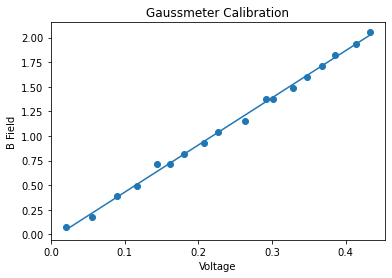

In [20]:
df_calibration = pd.read_csv('GaussmeterCalibration.csv')
df_calibration = df_calibration.rename(columns={'-0.052': 'Voltage', '-0.3137': 'B Field'})
plt.scatter(df_calibration['Voltage'], df_calibration["B Field"])


def func(x, m, b):
    return m*x +b

popt, pcov = curve_fit(func, df_calibration['Voltage'], df_calibration["B Field"])
 
plt.plot(df_calibration['Voltage'], func(df_calibration['Voltage'], *popt))
         
plt.xlabel("Voltage")
plt.ylabel("B Field")
plt.title("Gaussmeter Calibration")

<ipython-input-4-e4ae328f0602>:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(14,12))


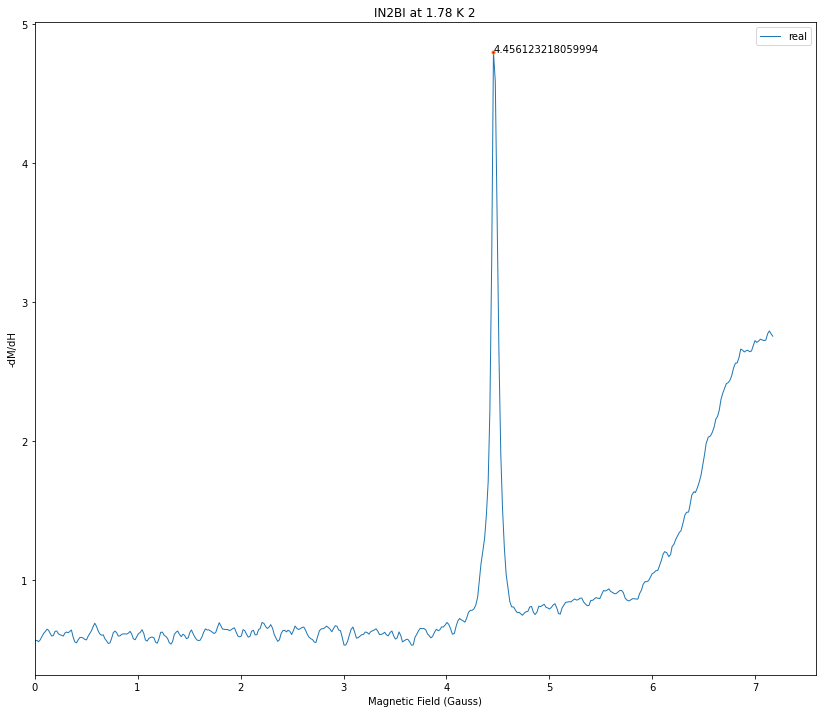

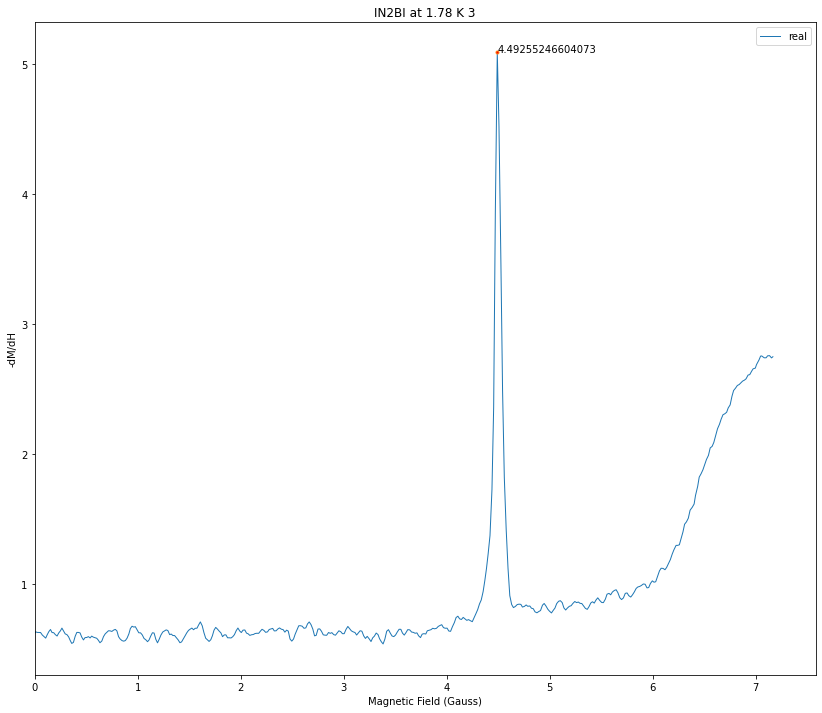

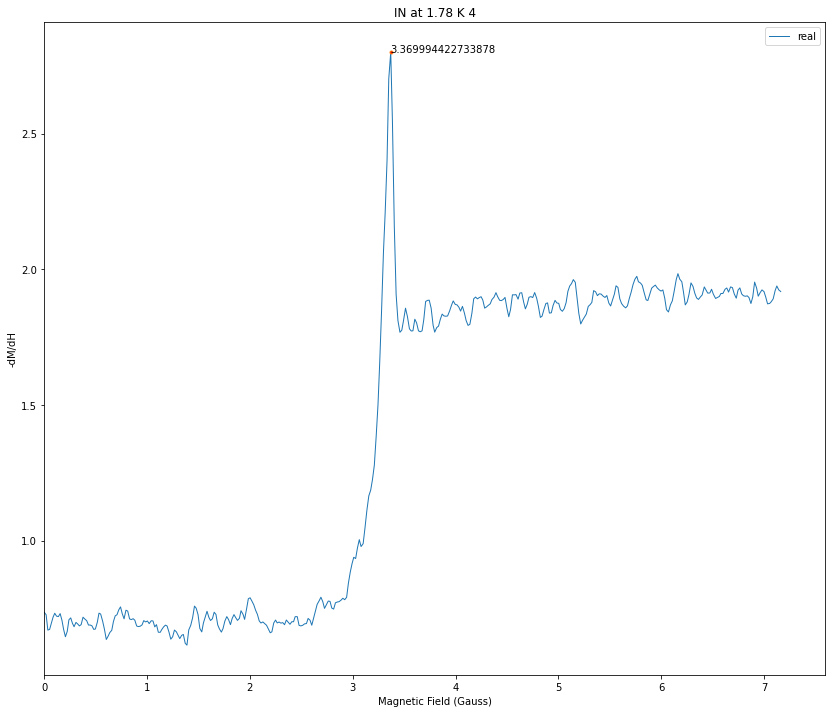

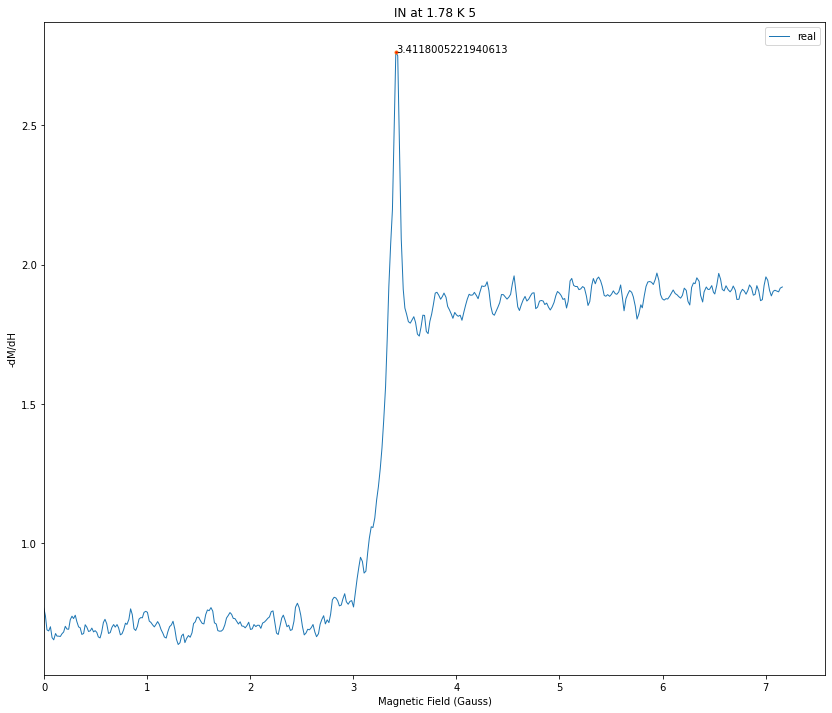

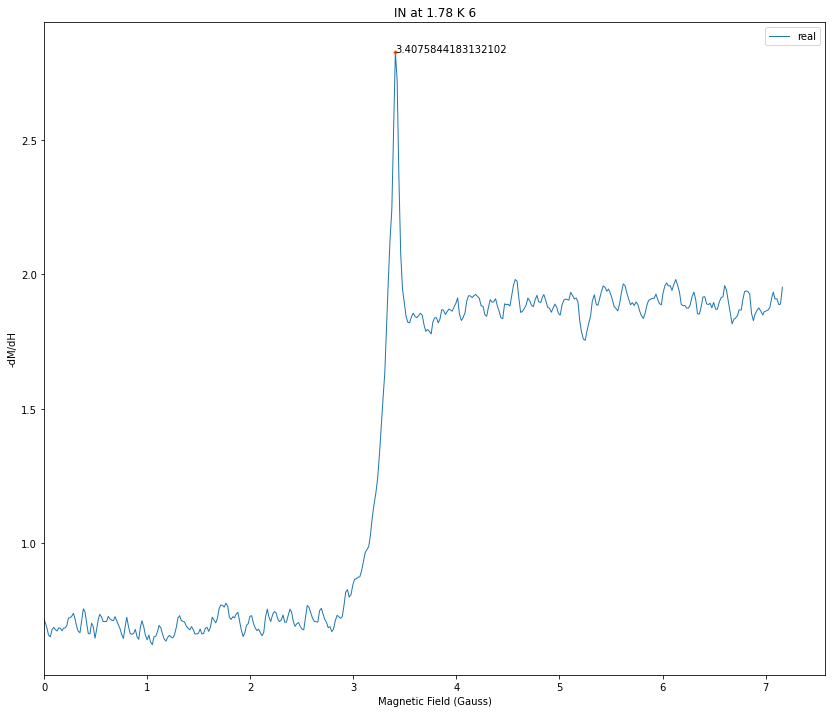

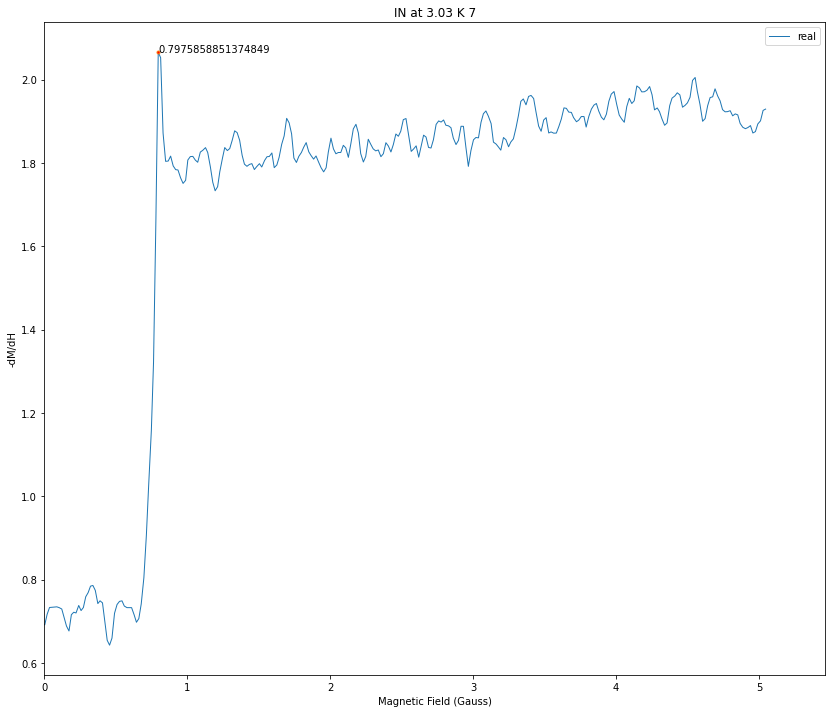

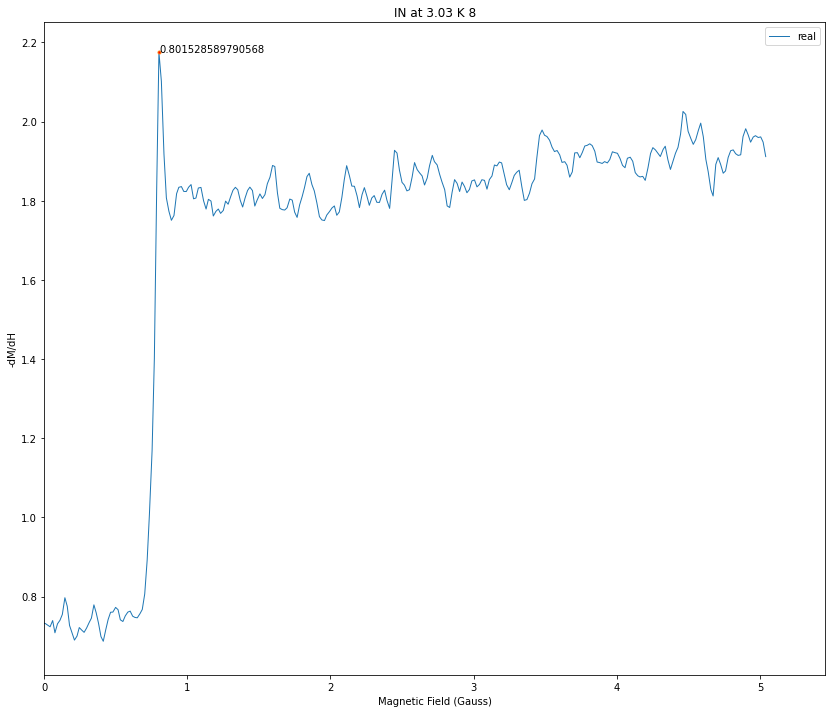

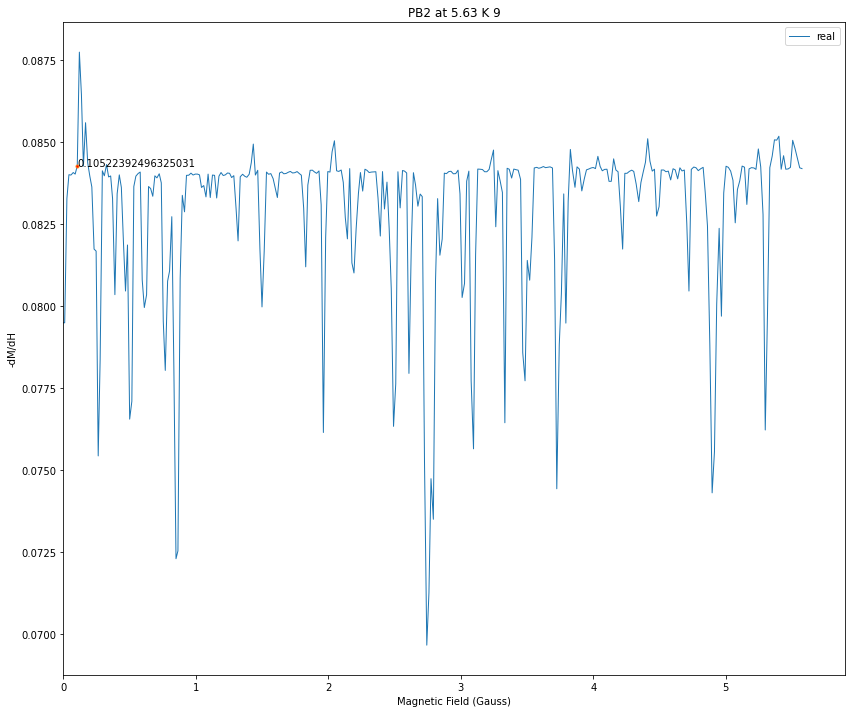

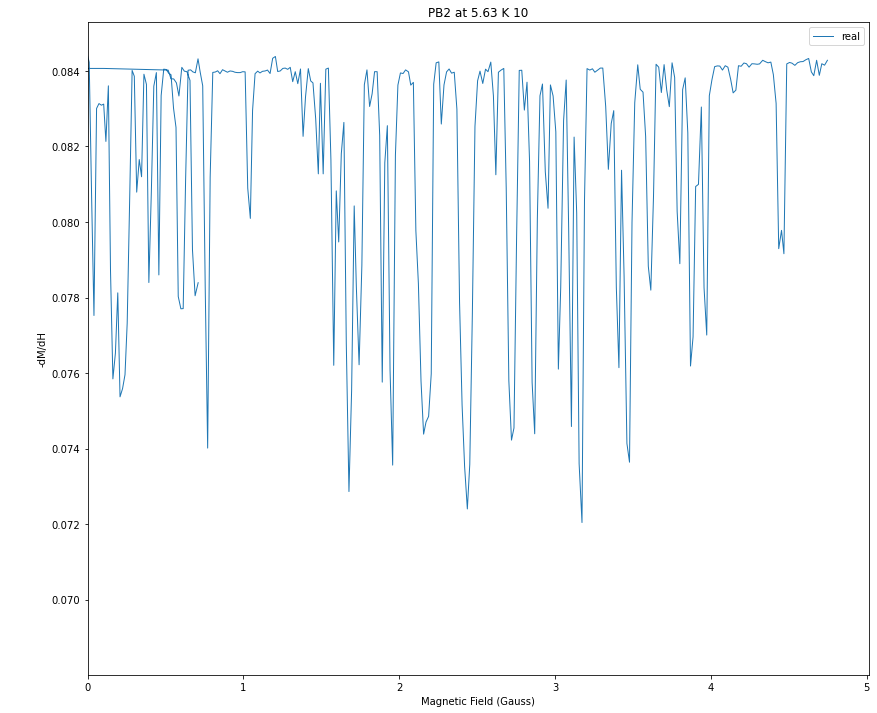

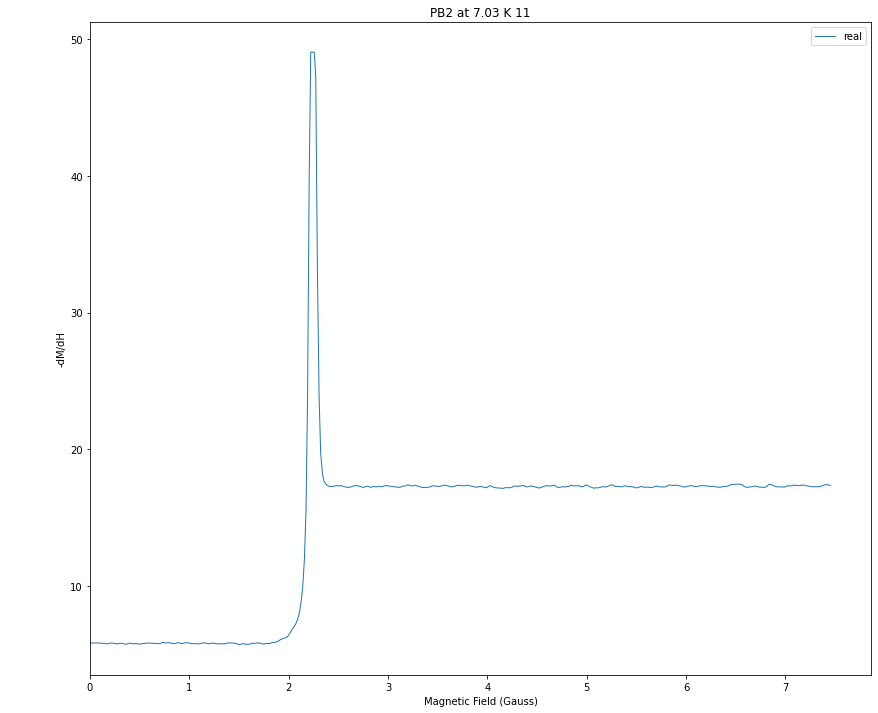

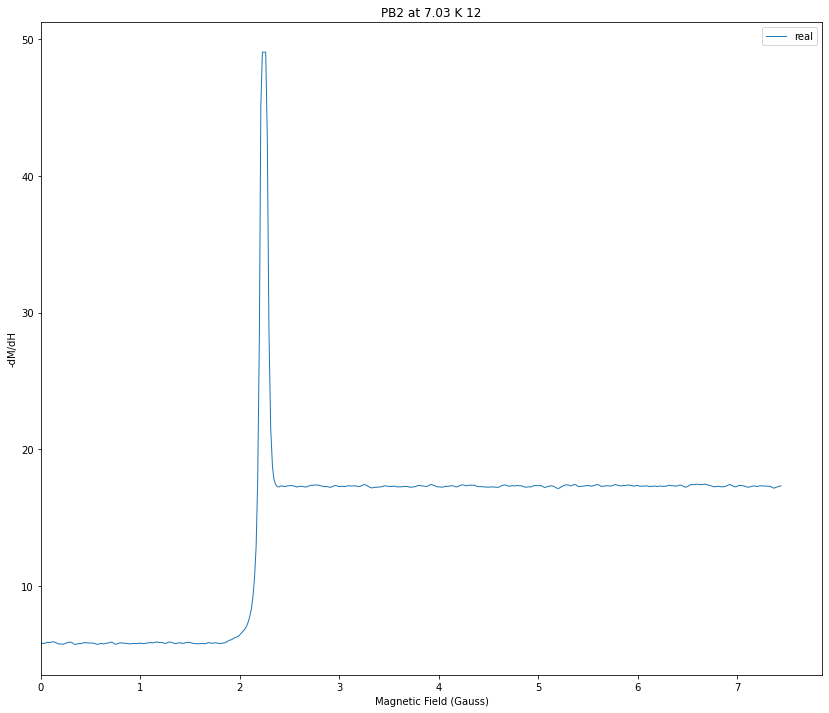

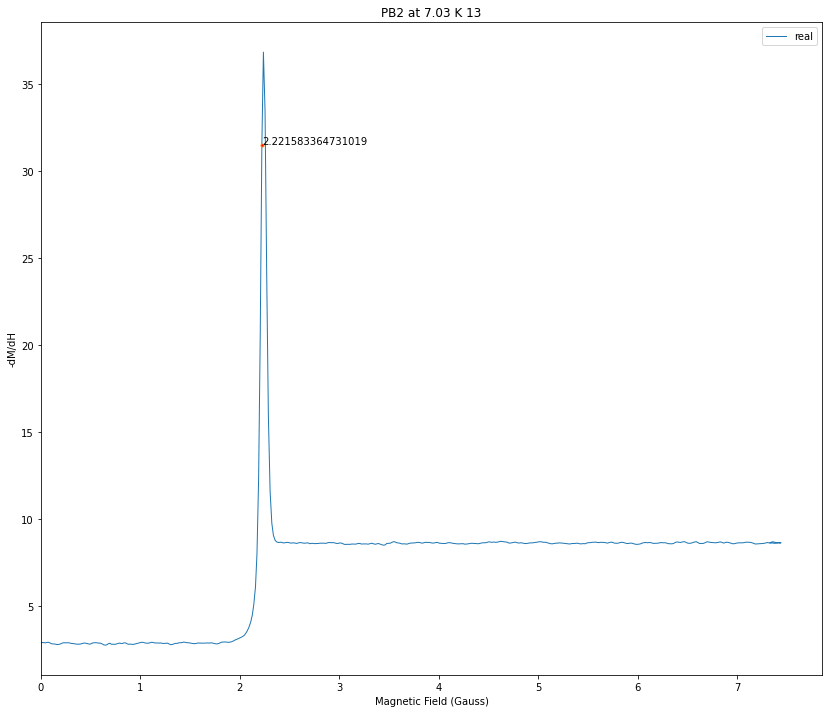

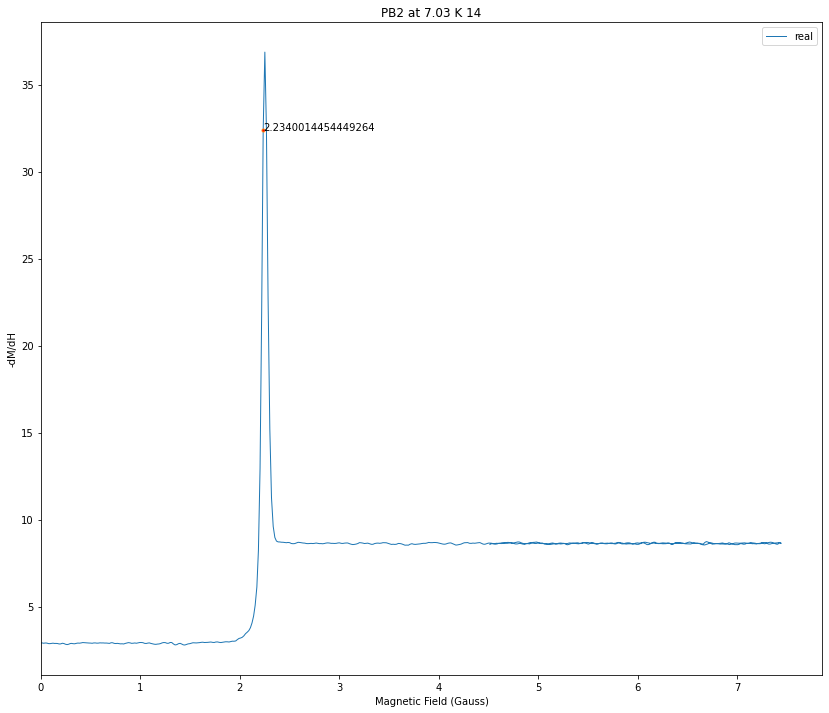

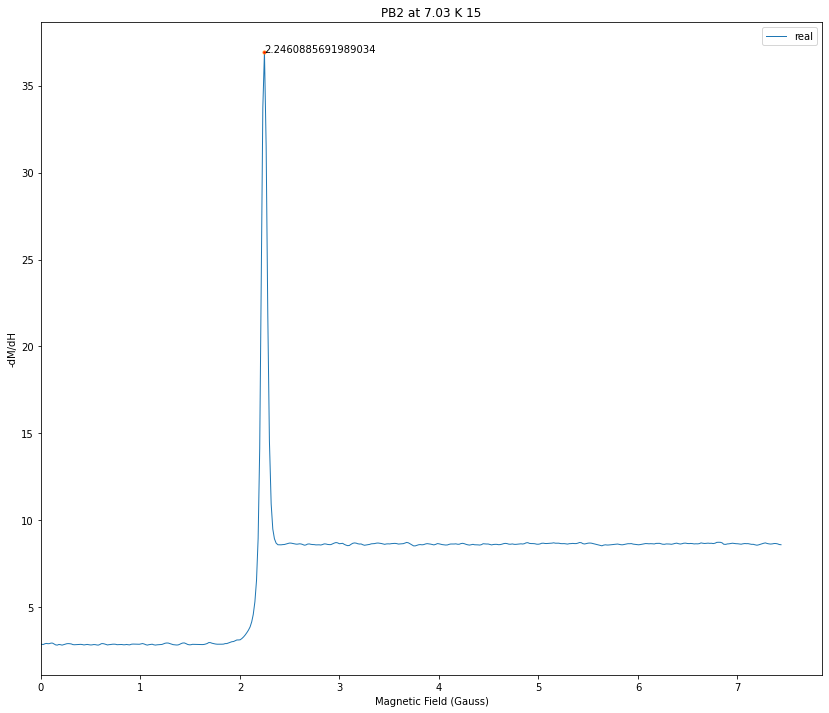

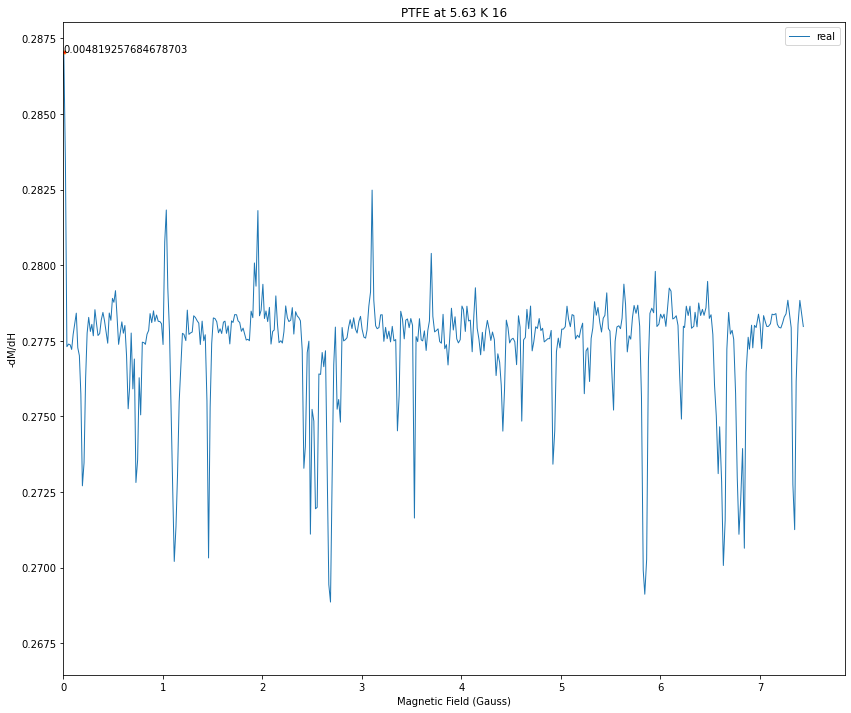

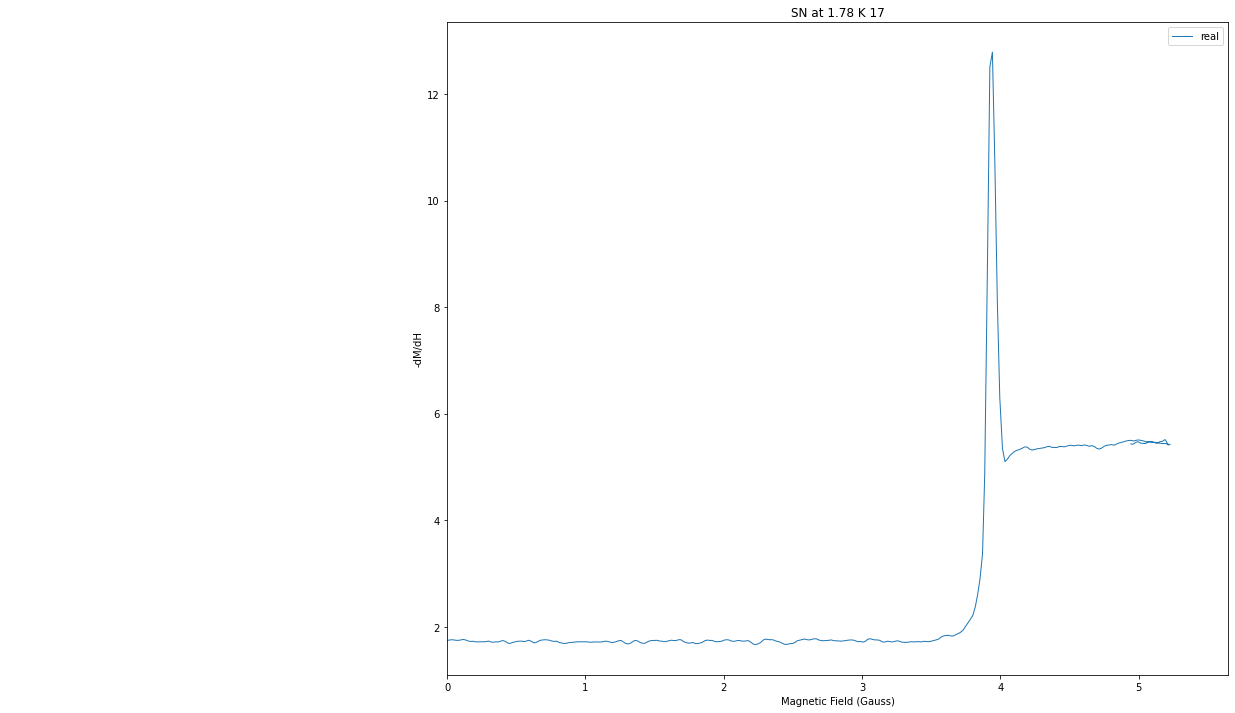

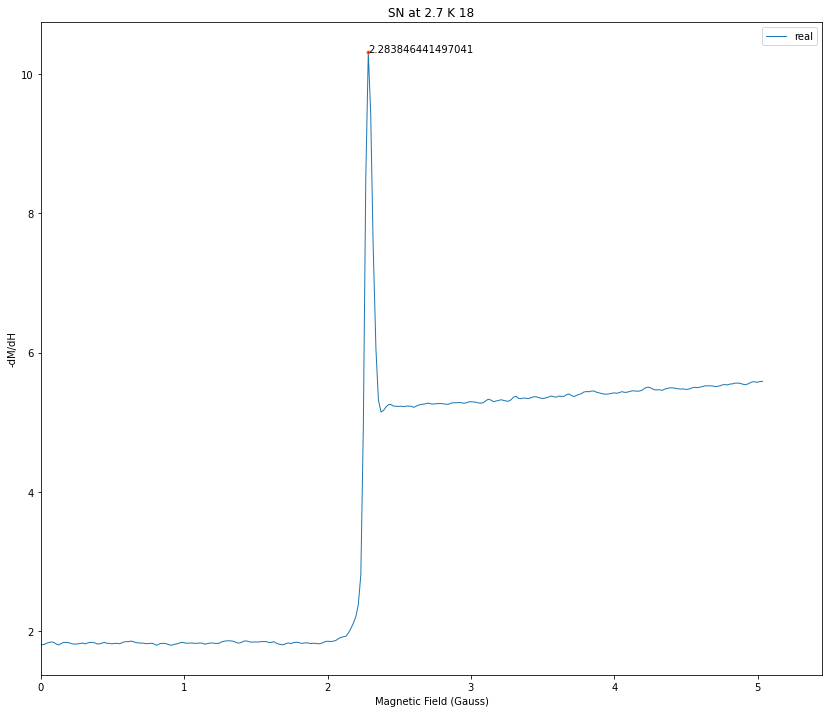

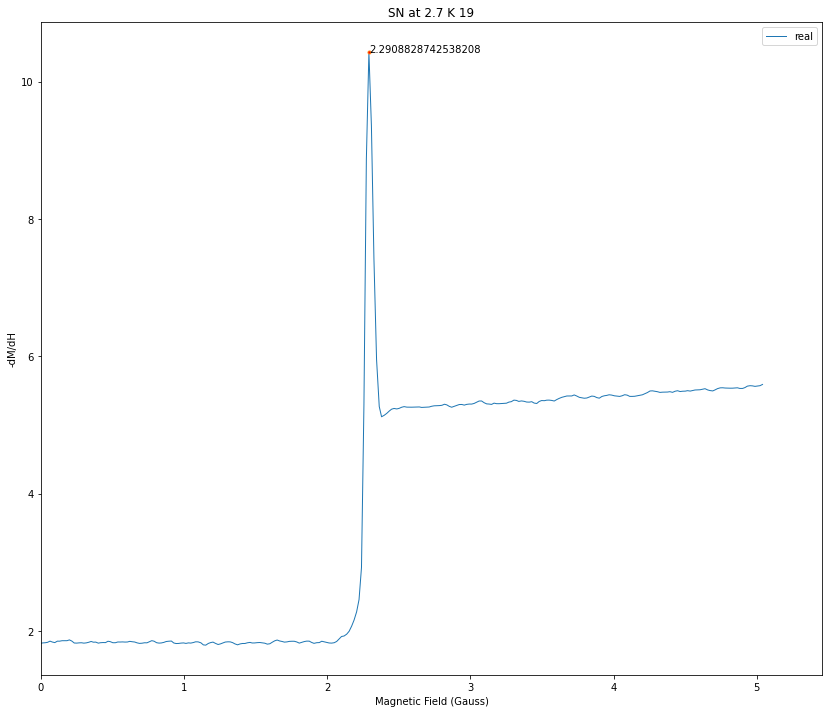

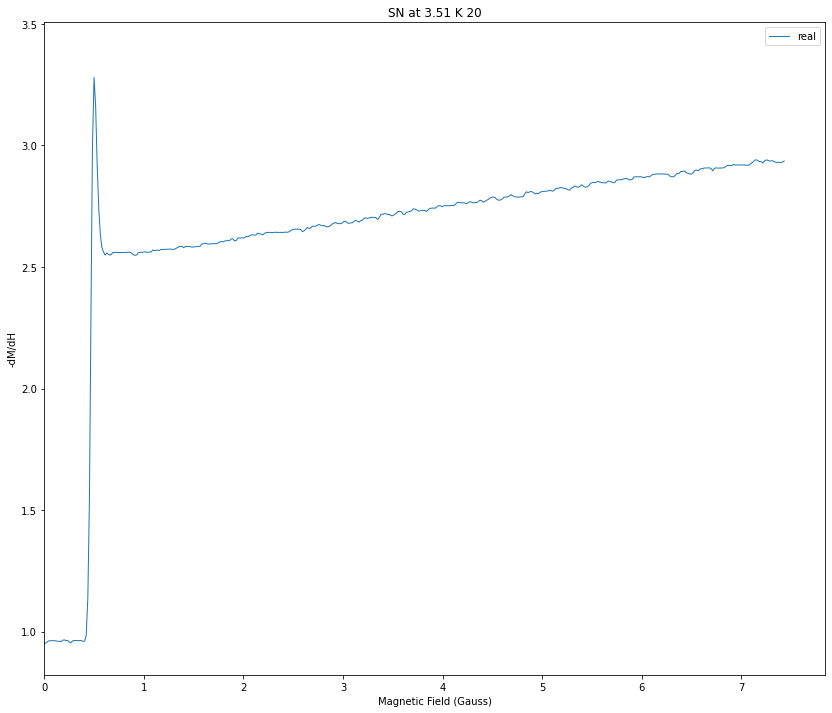

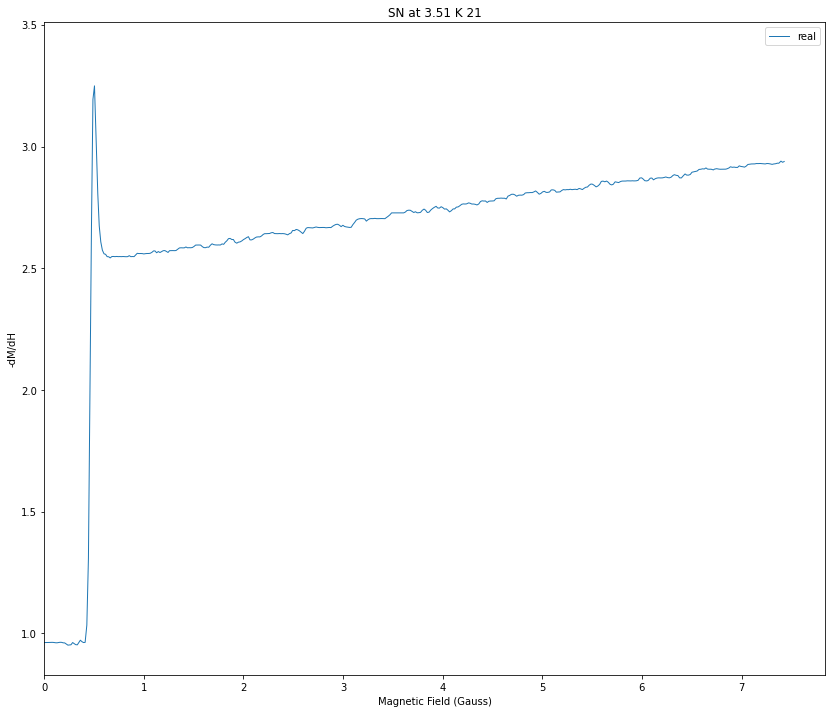

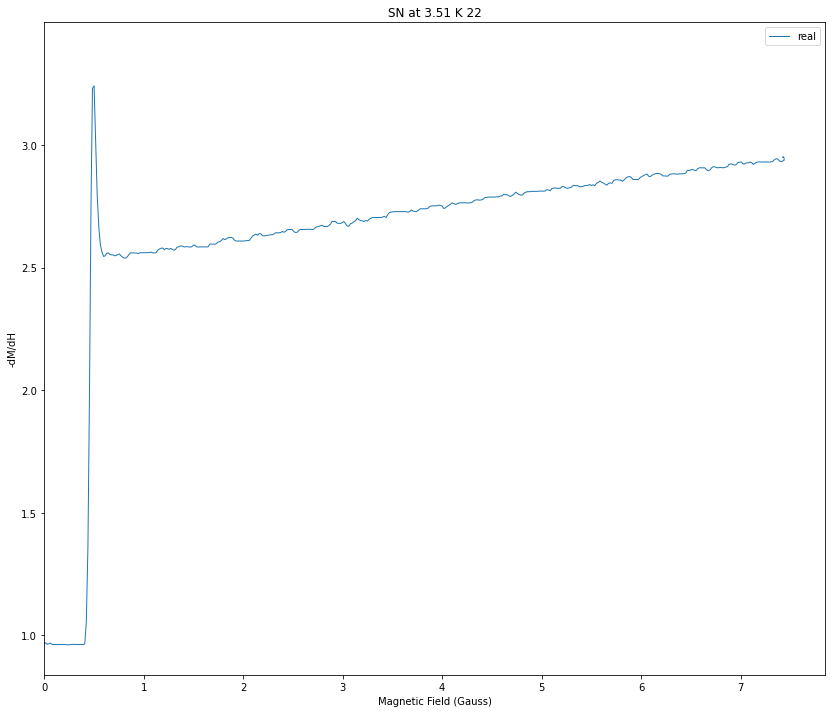

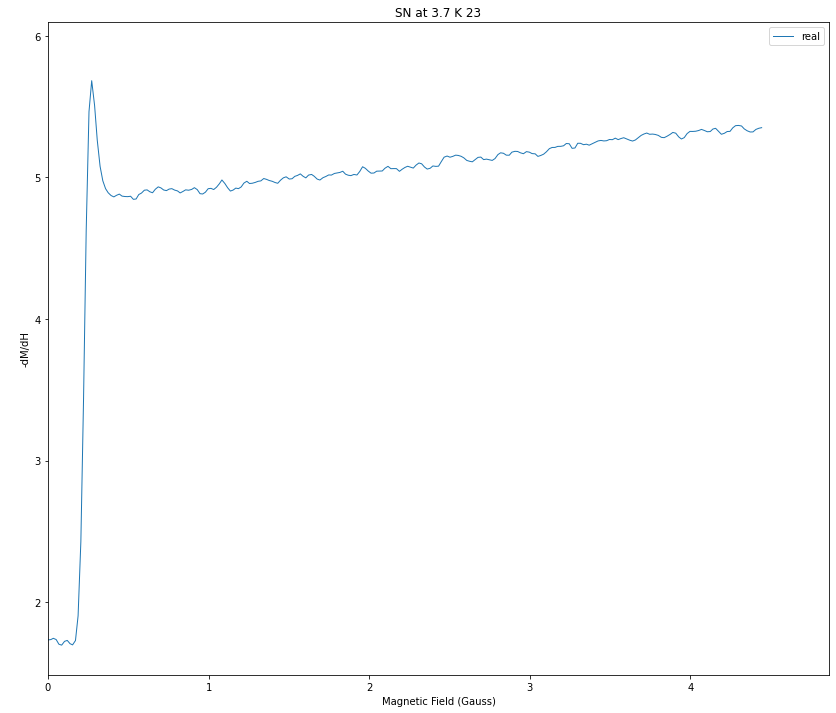

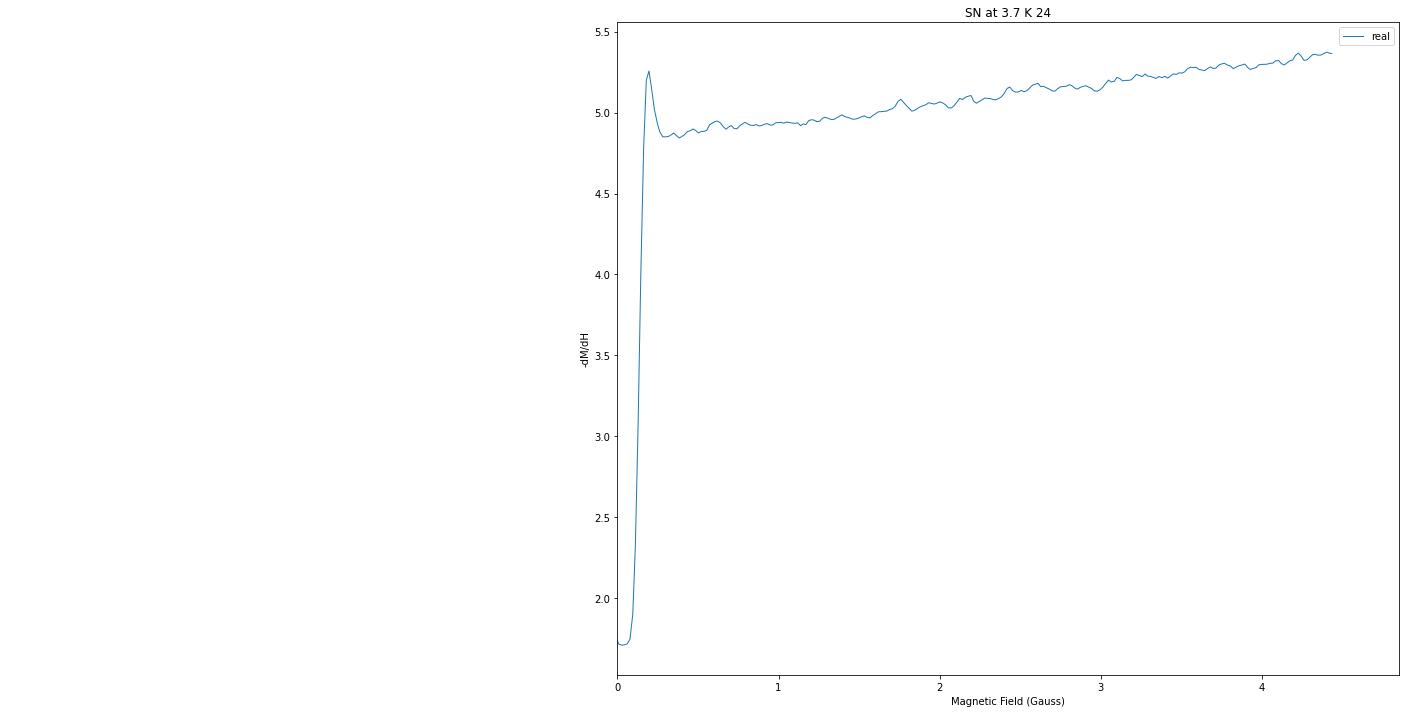

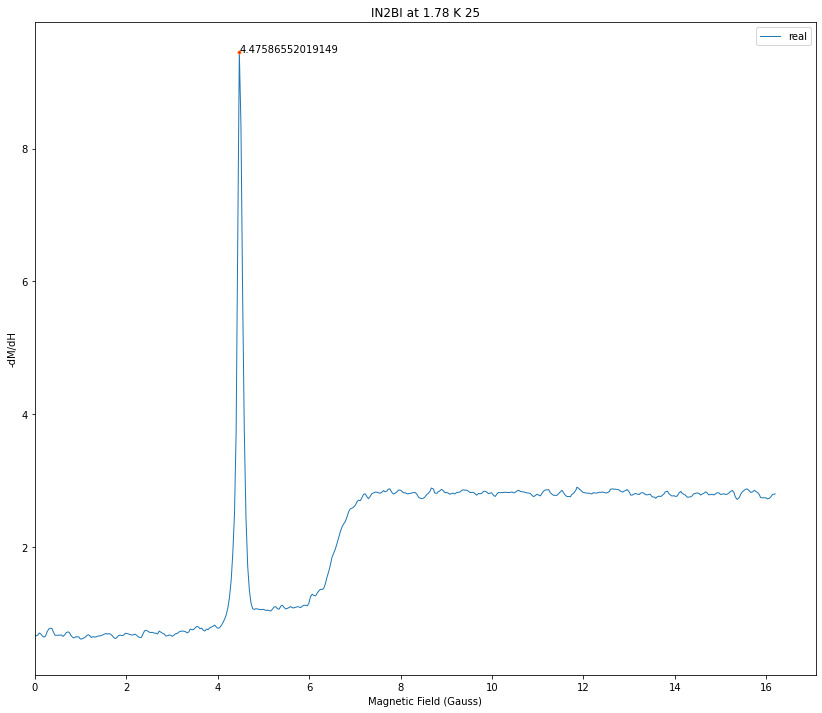

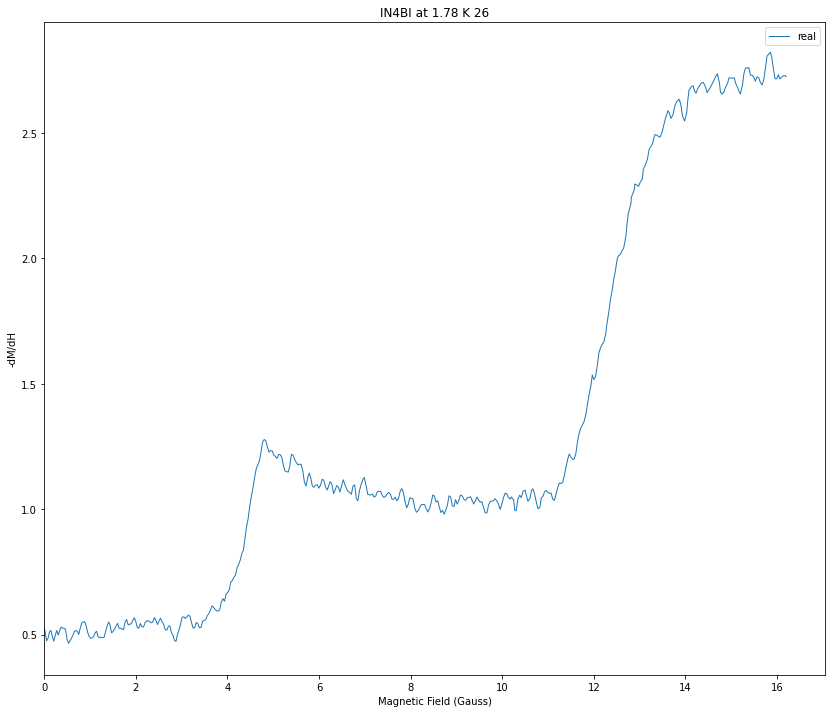

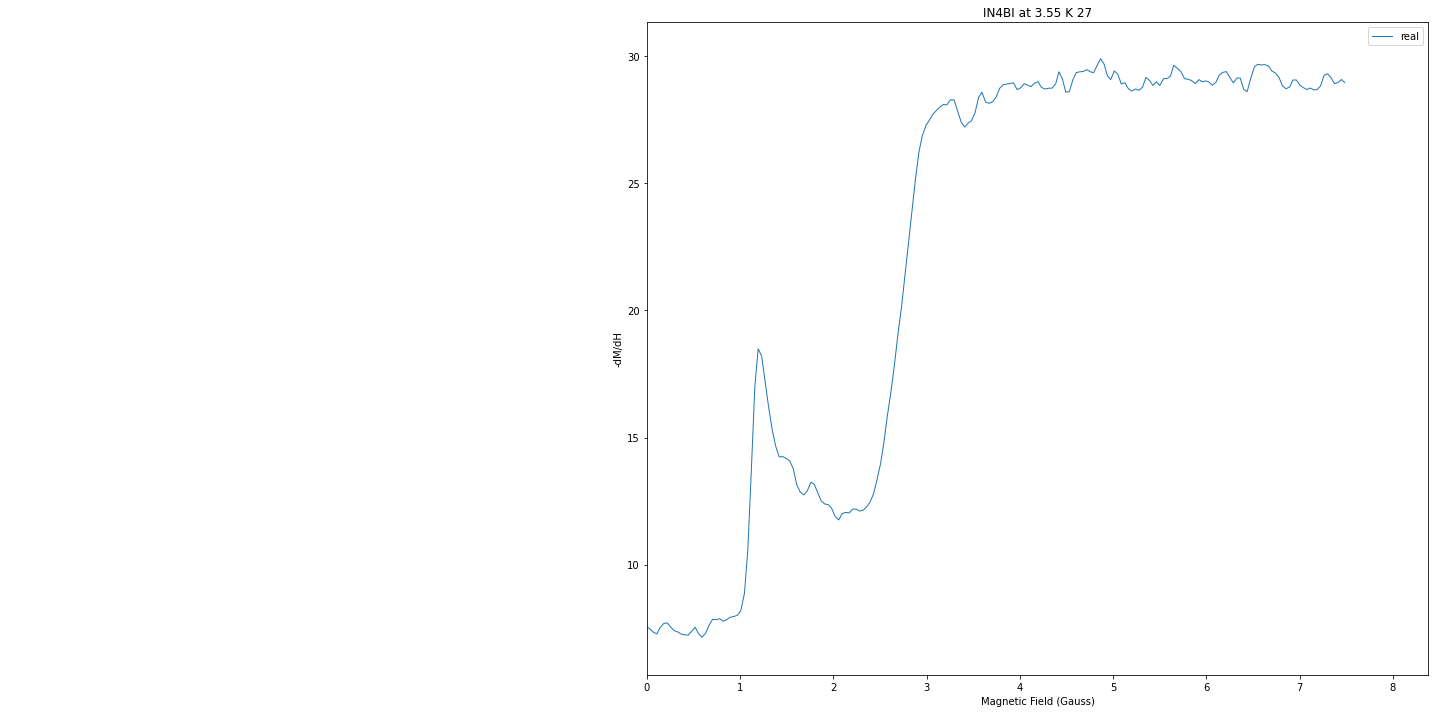

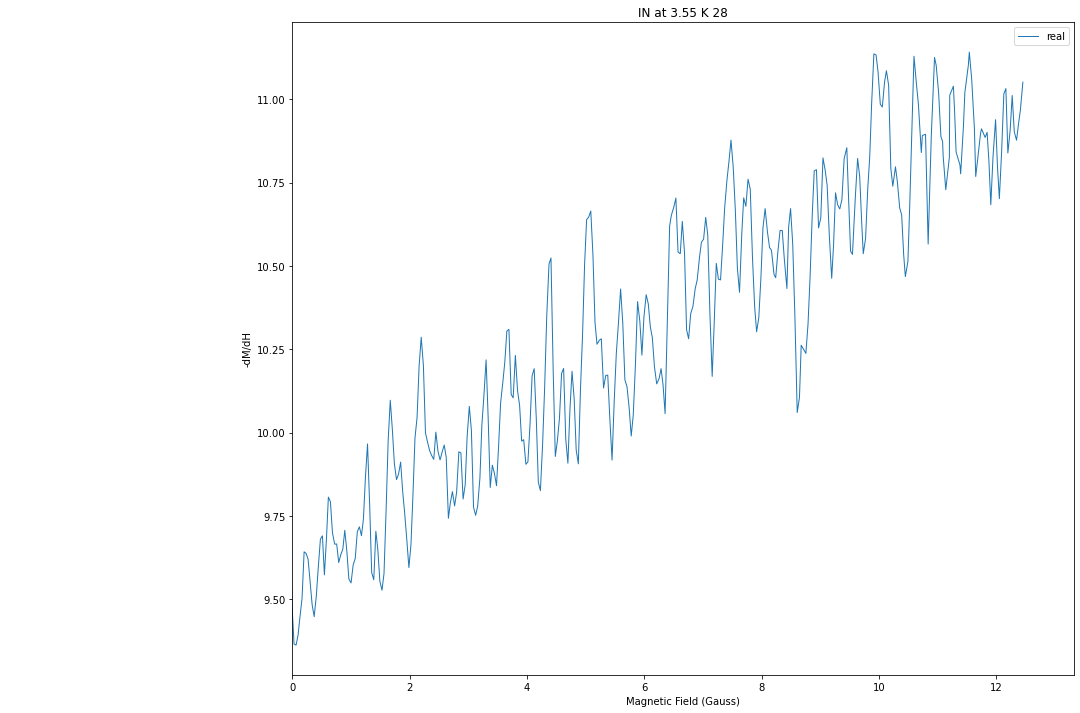

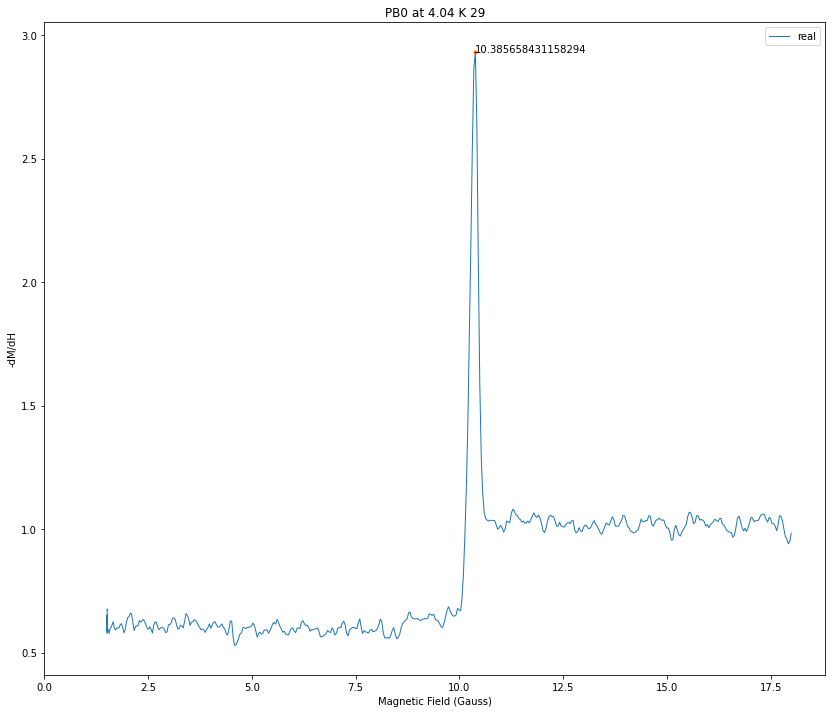

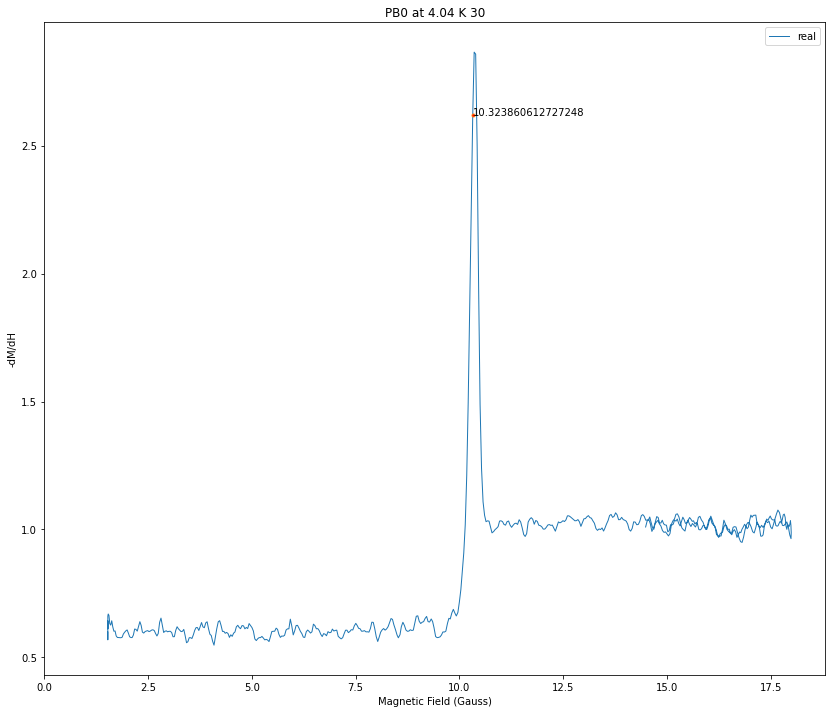

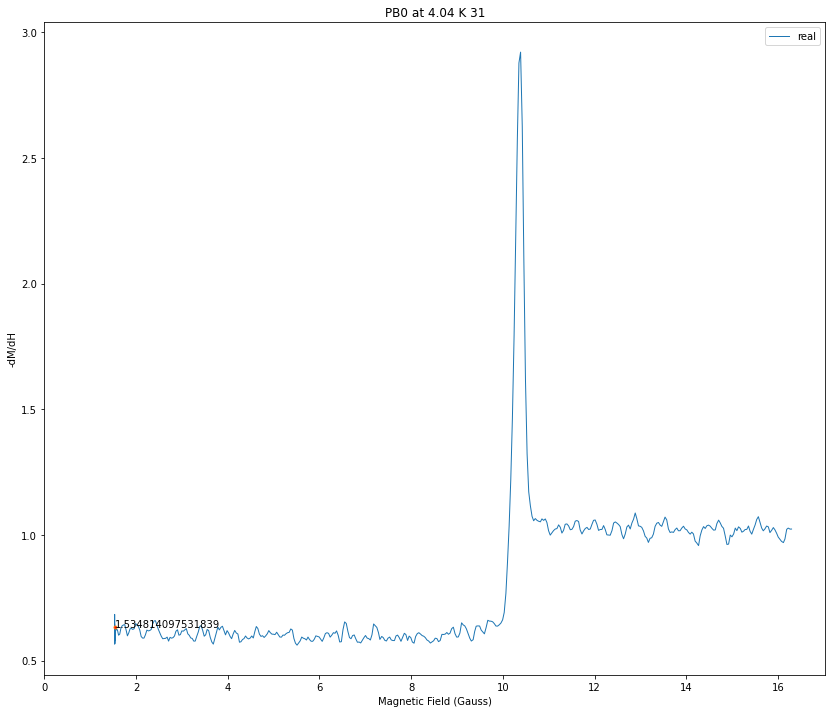

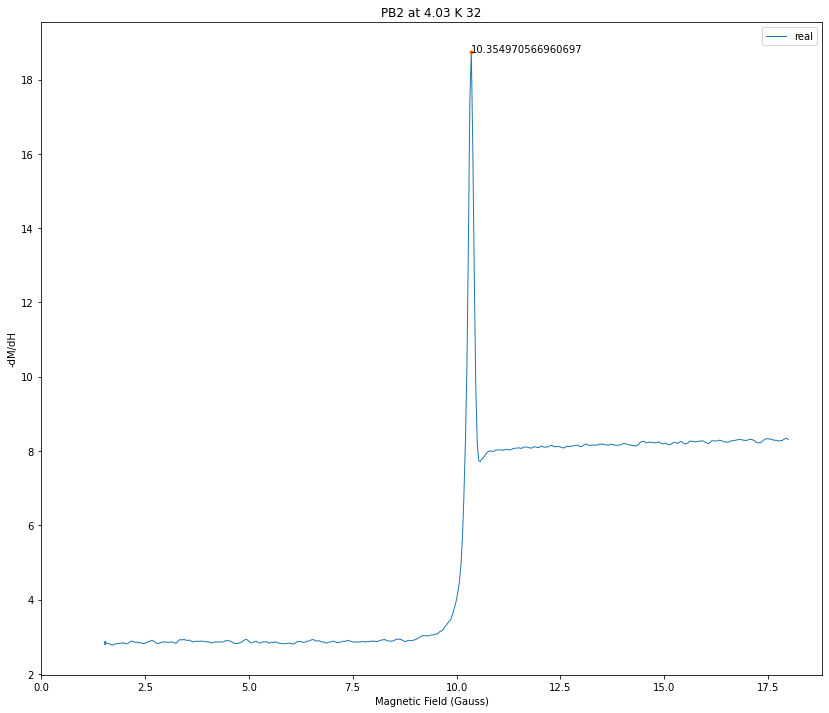

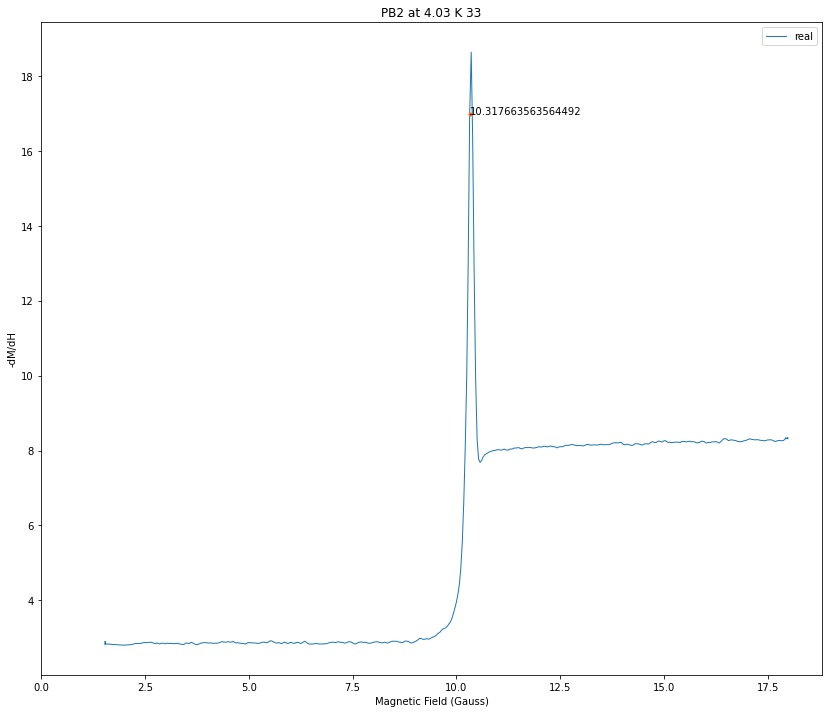

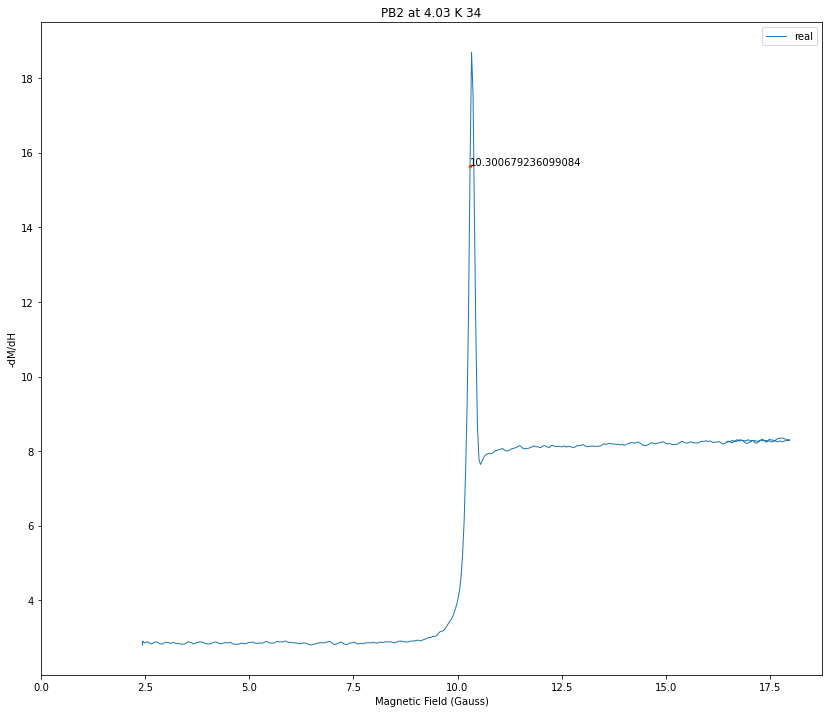

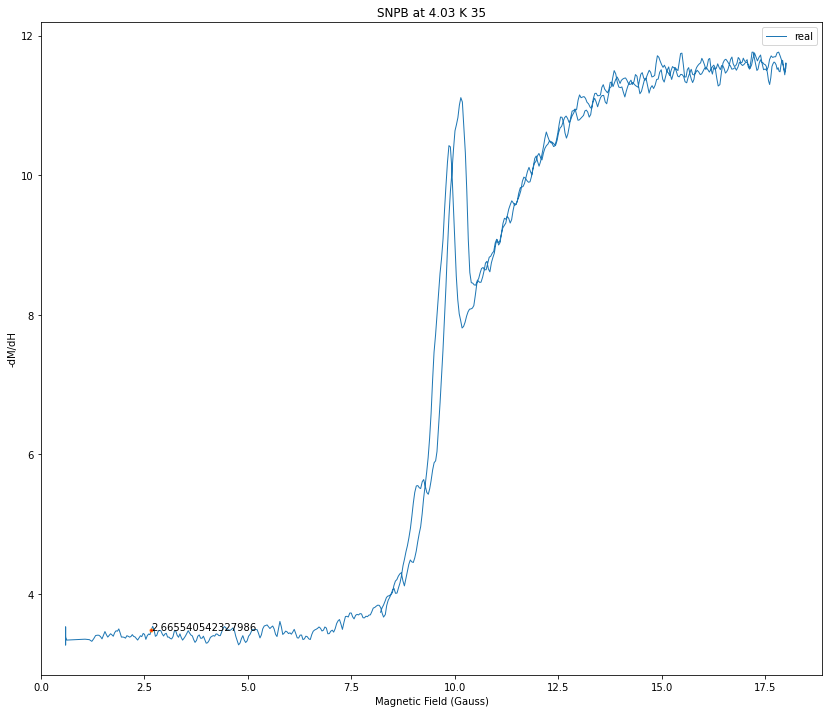

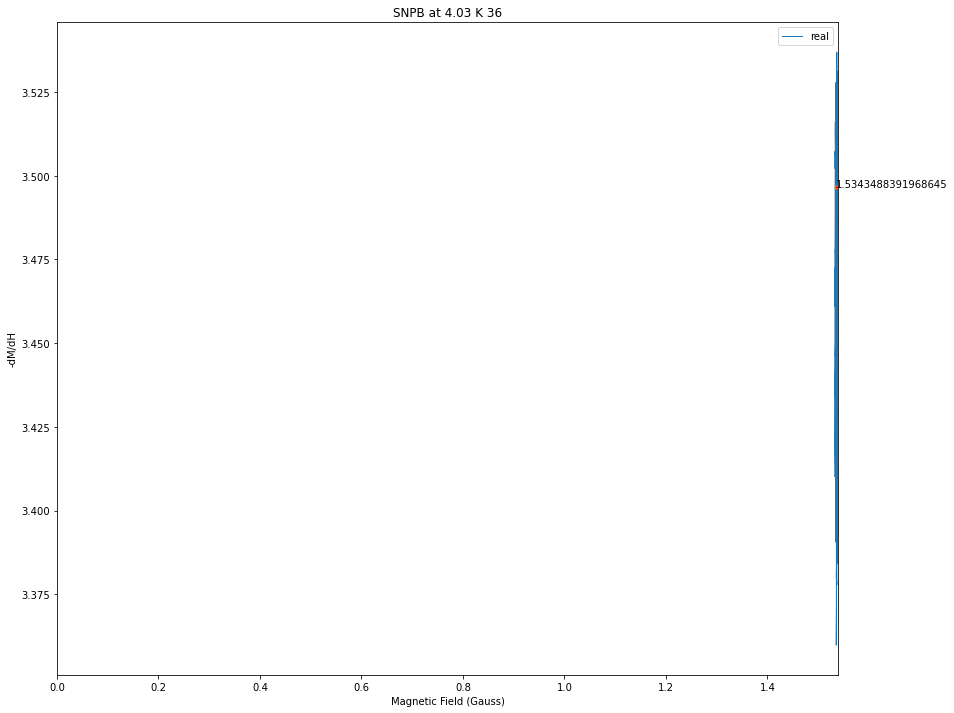

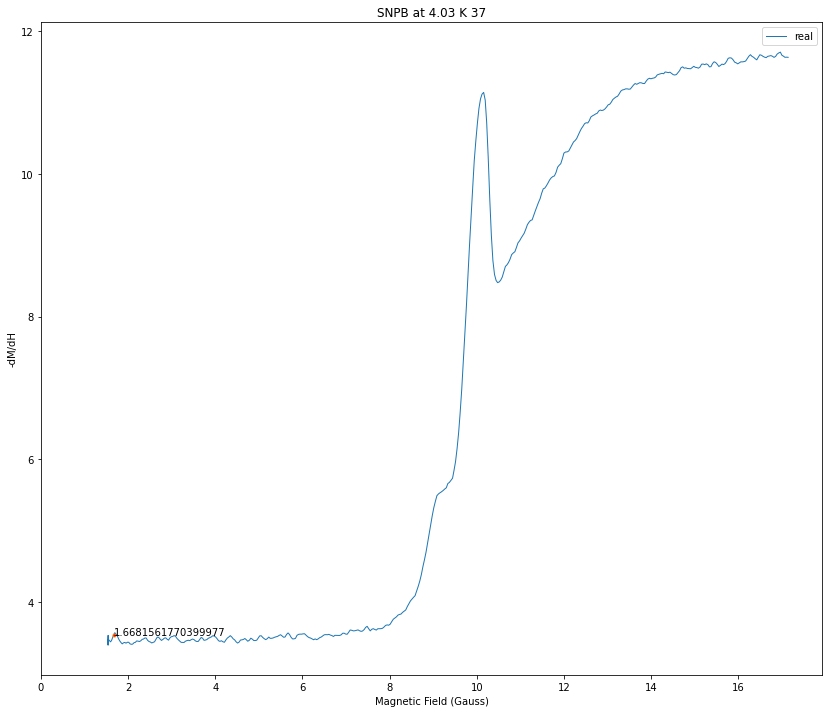

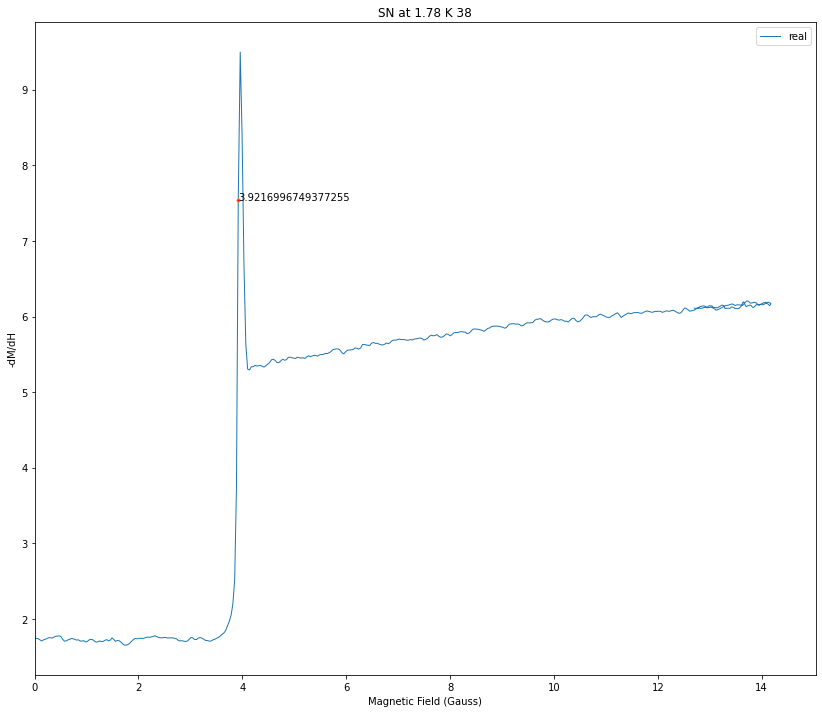

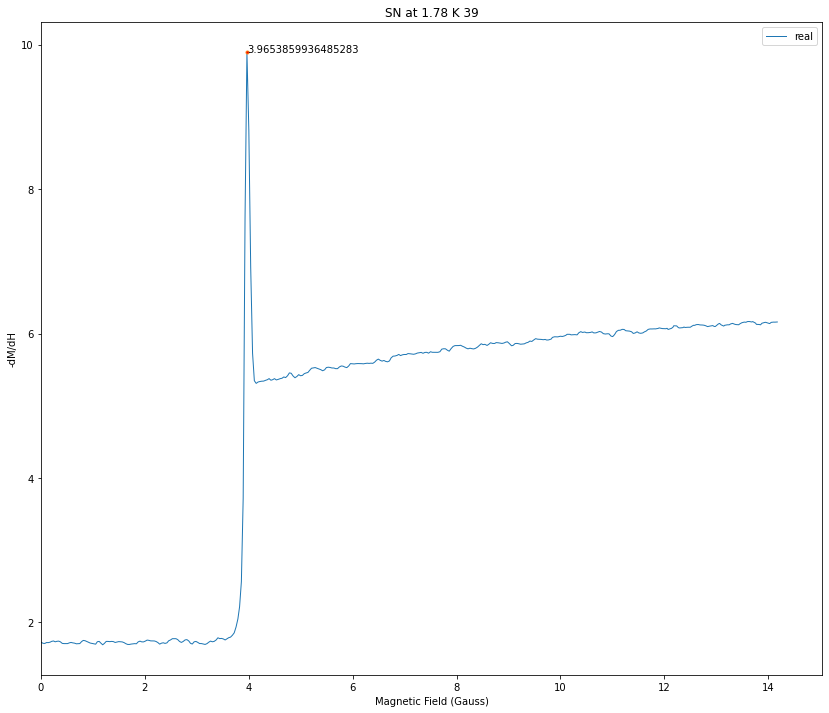

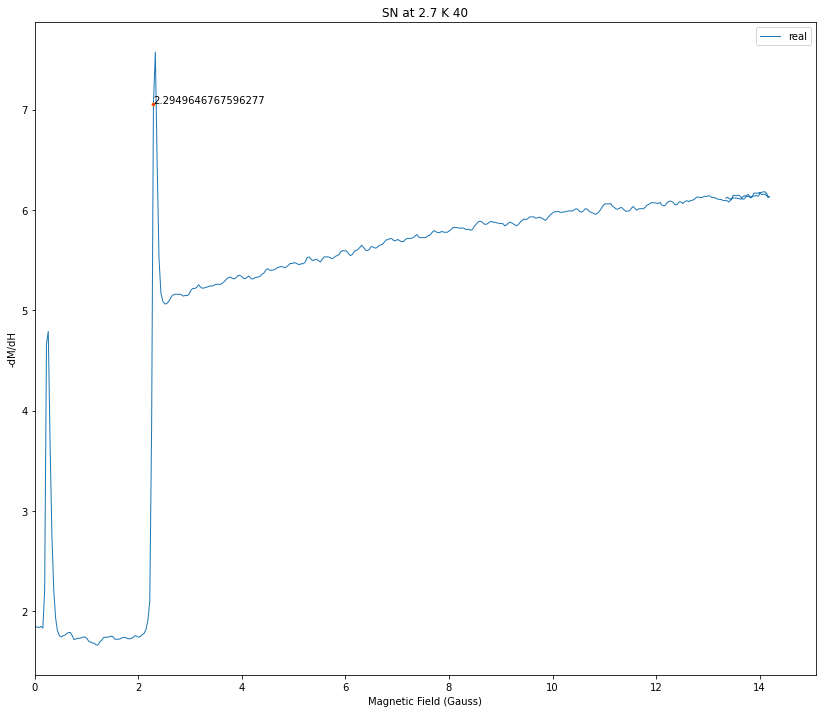

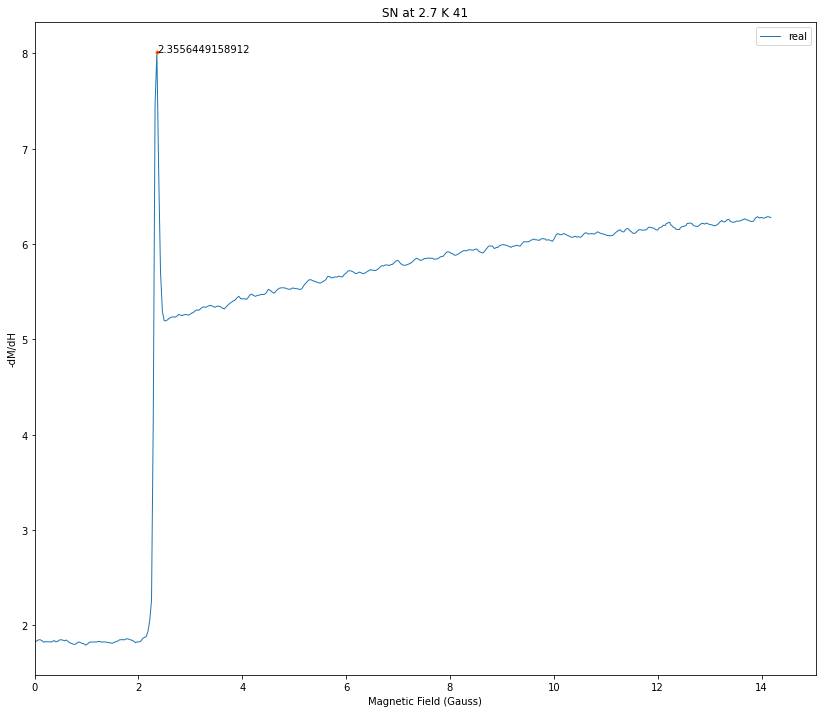

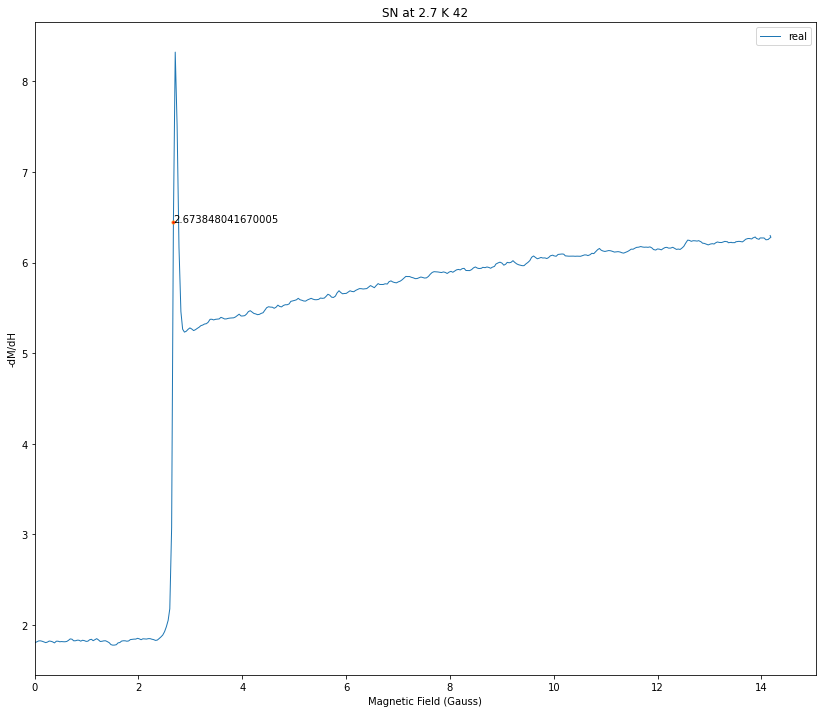

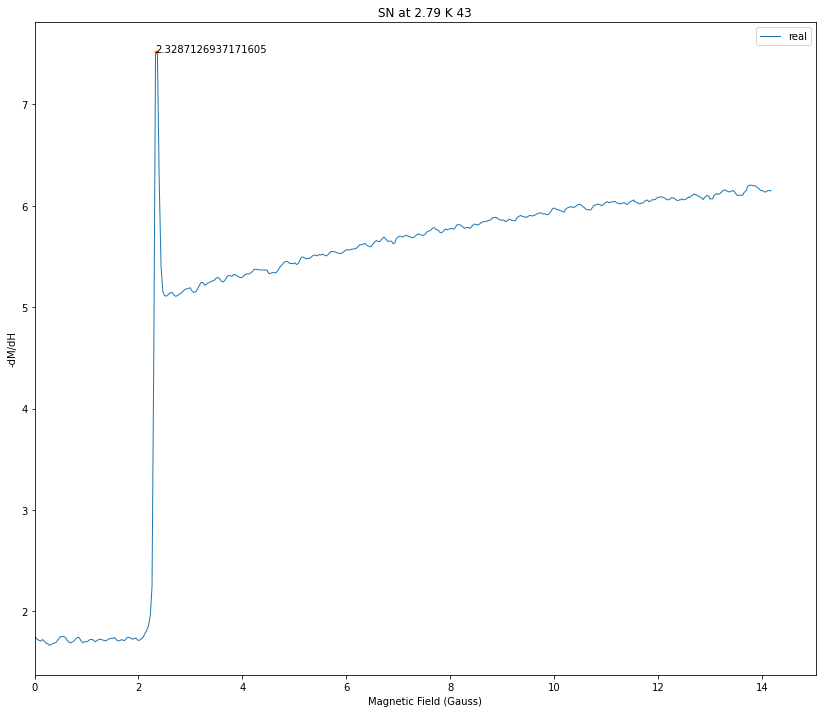

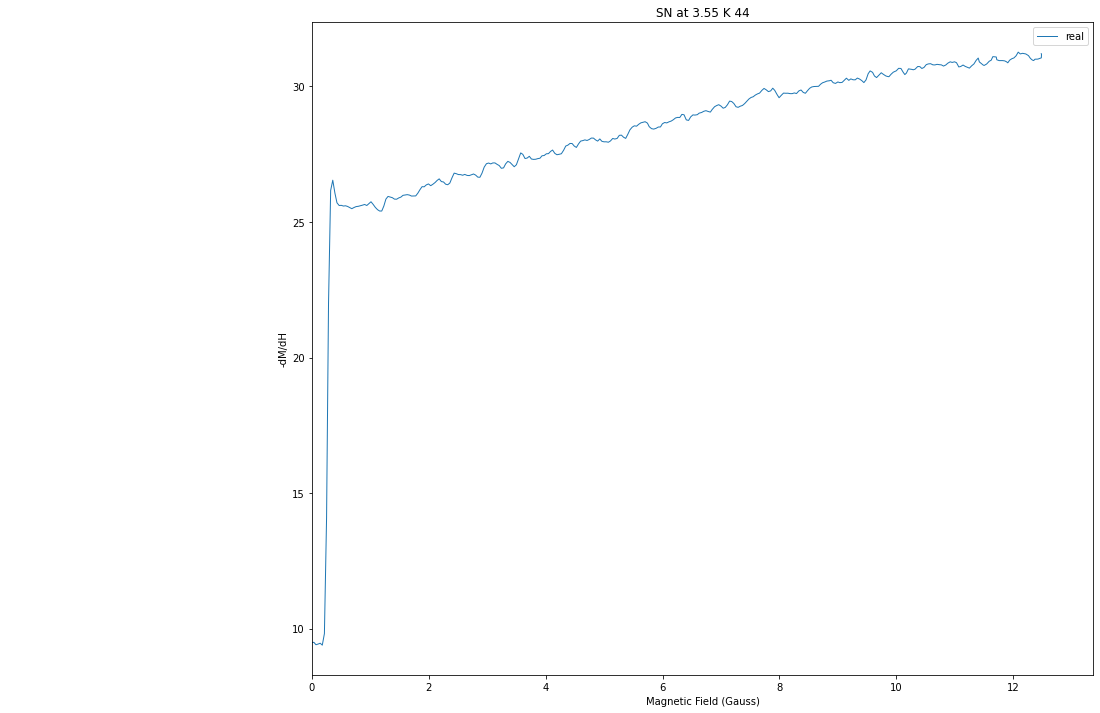

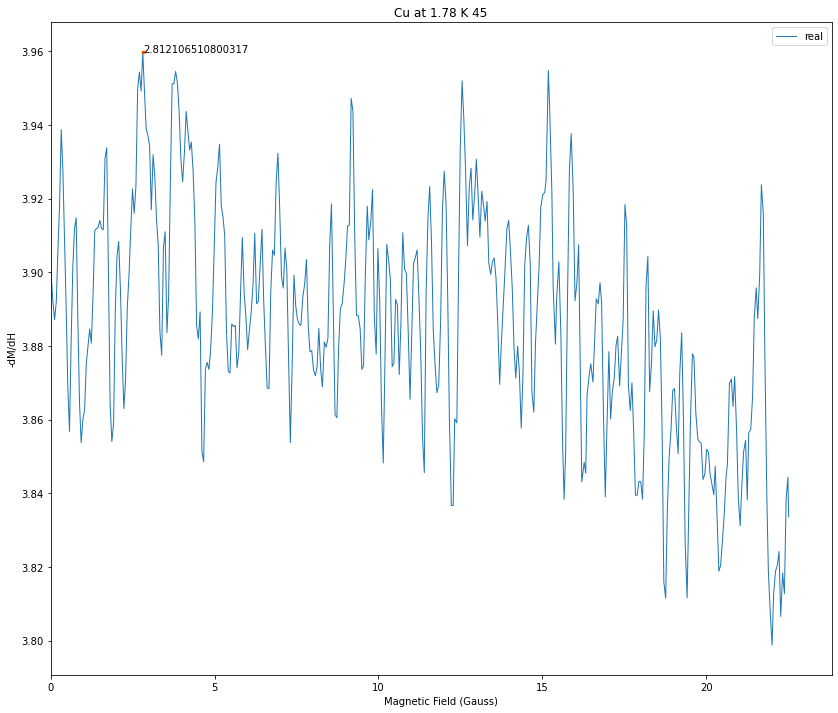

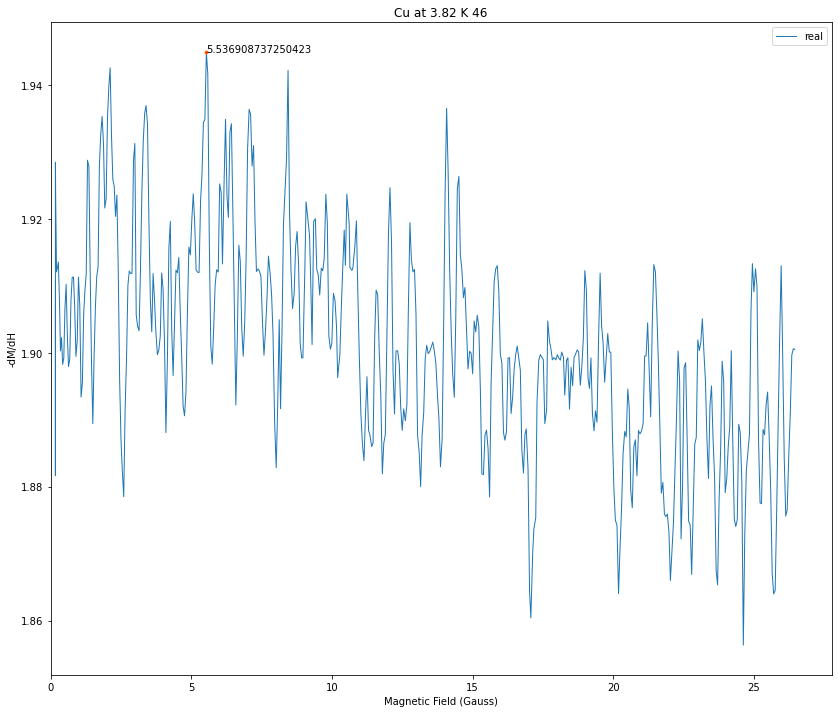

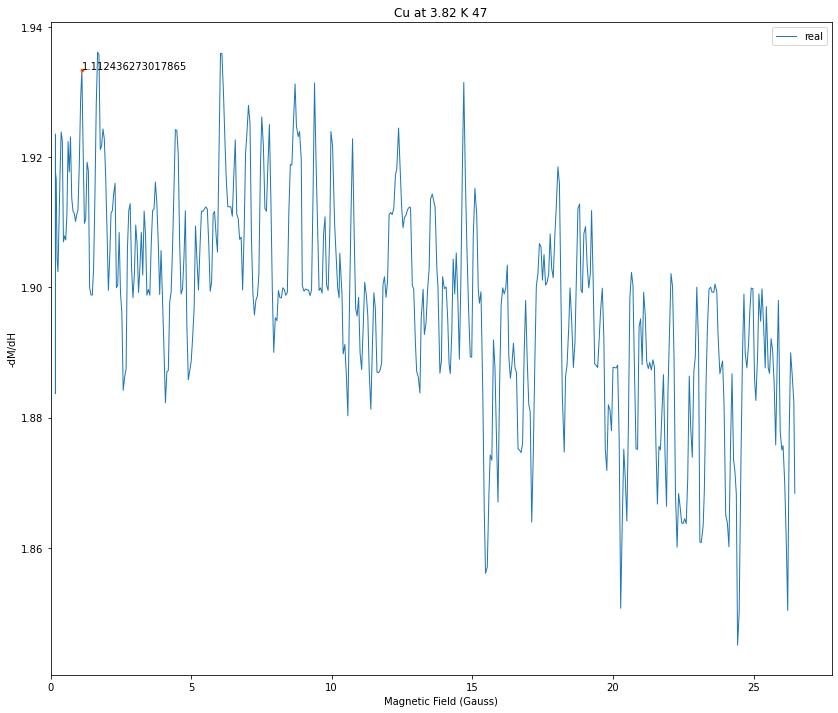

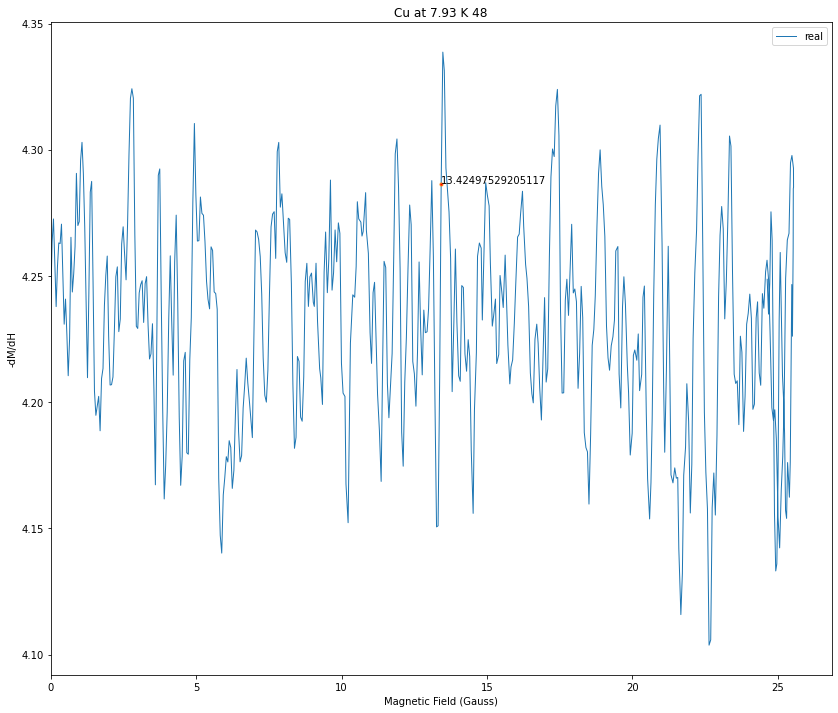

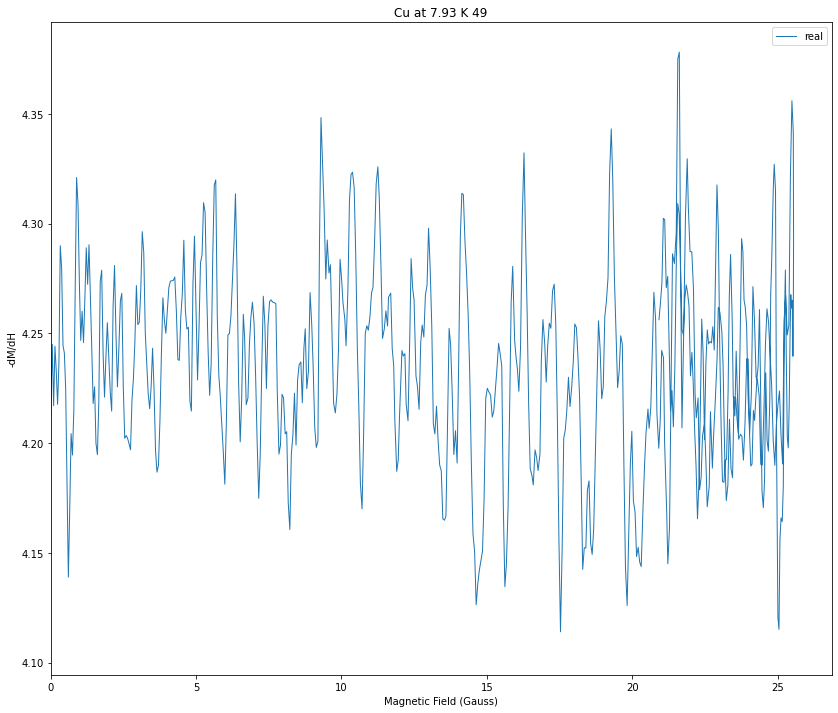

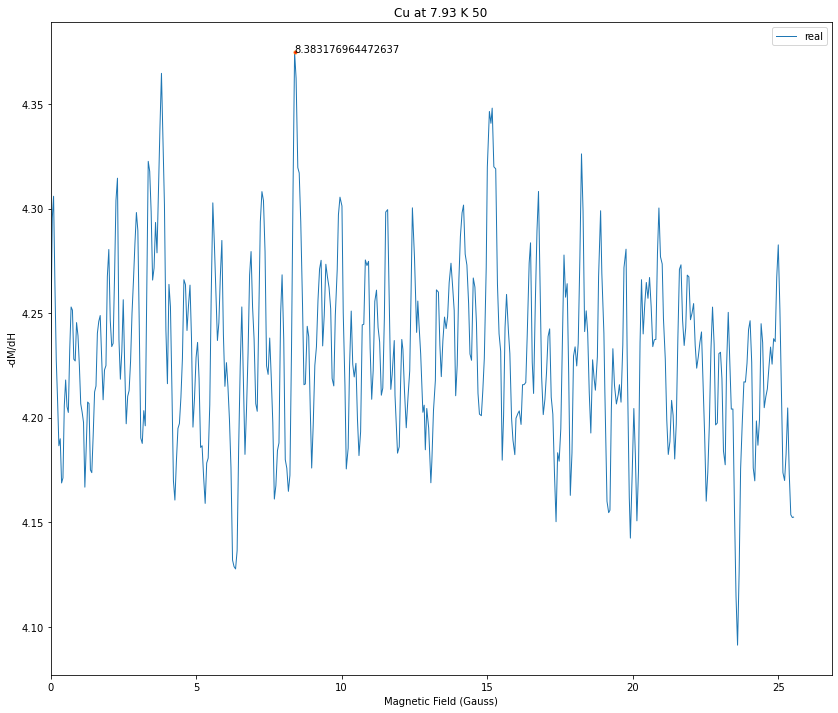

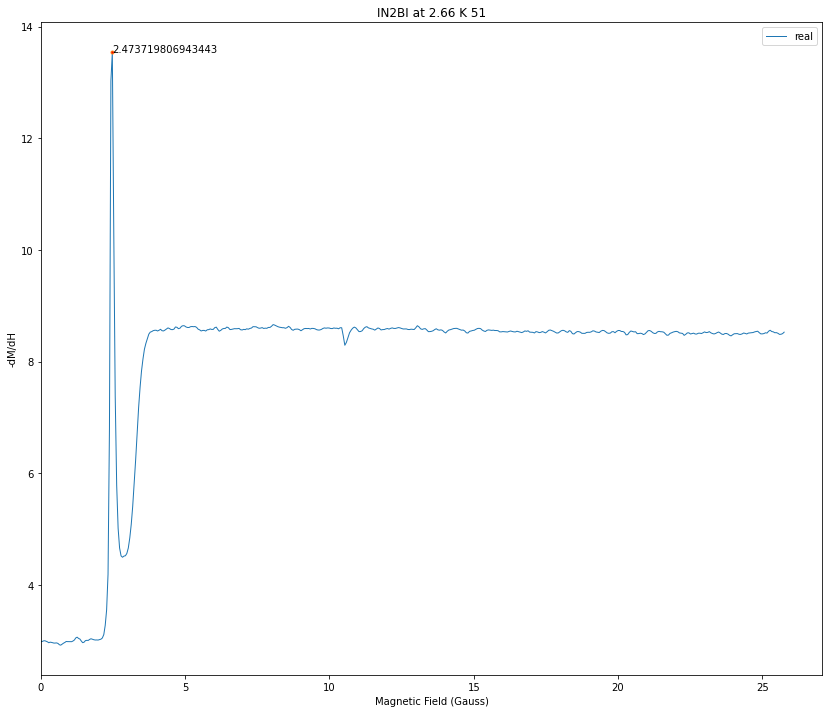

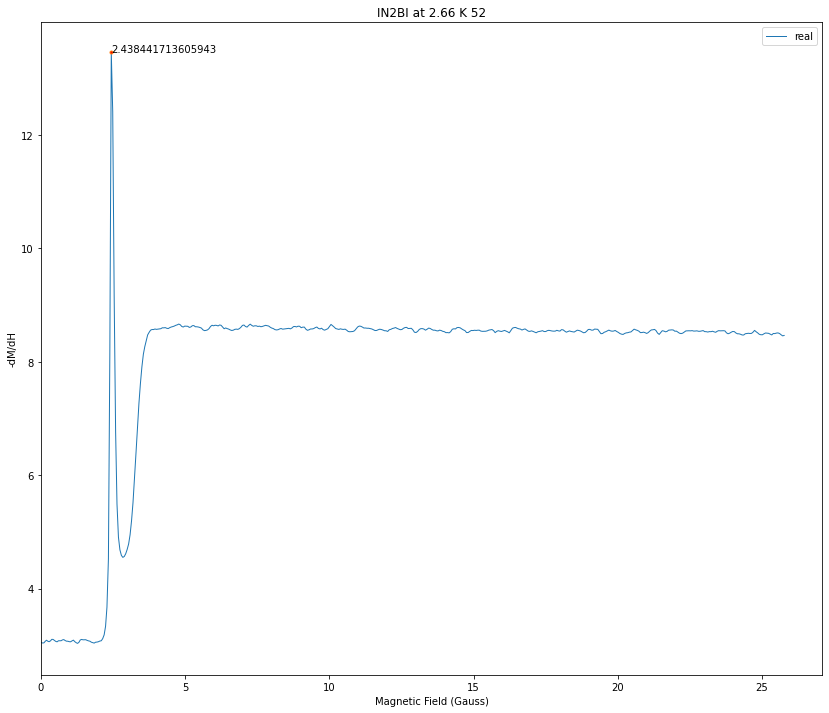

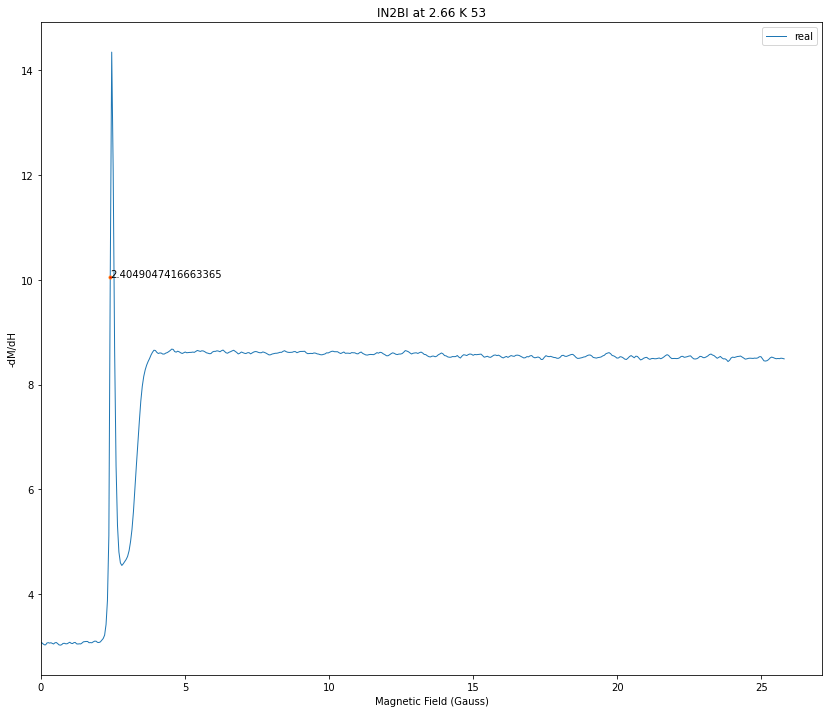

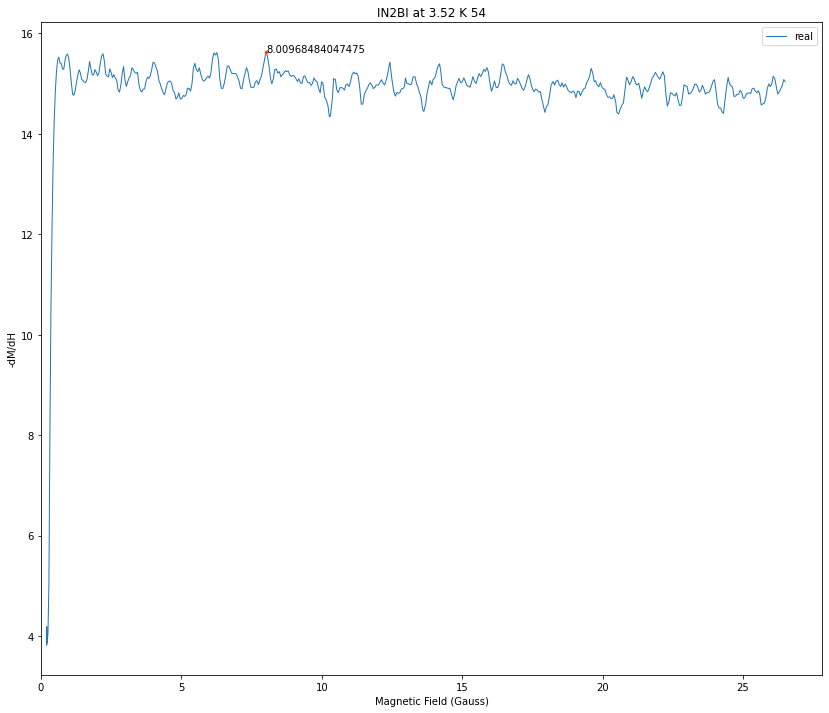

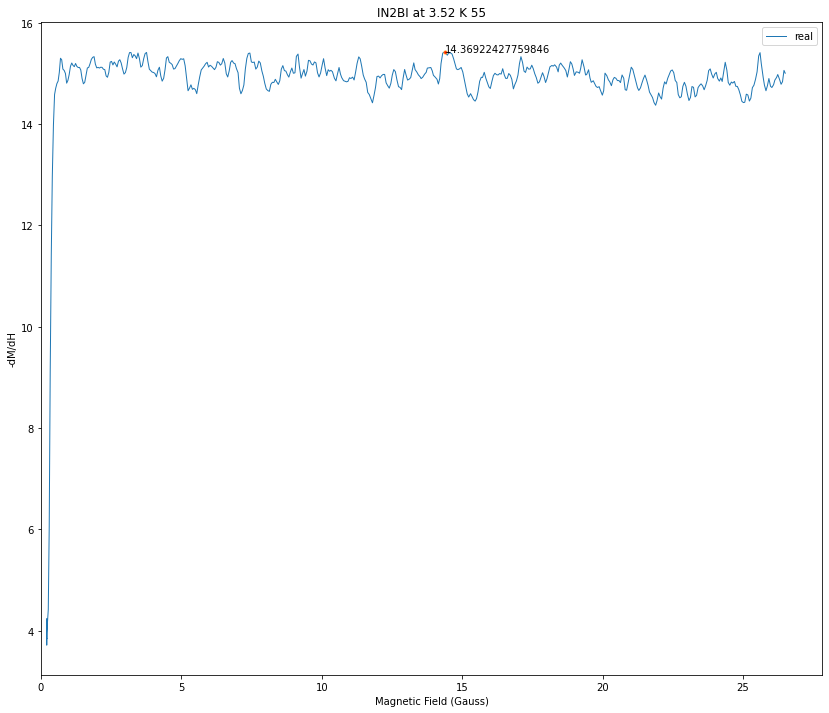

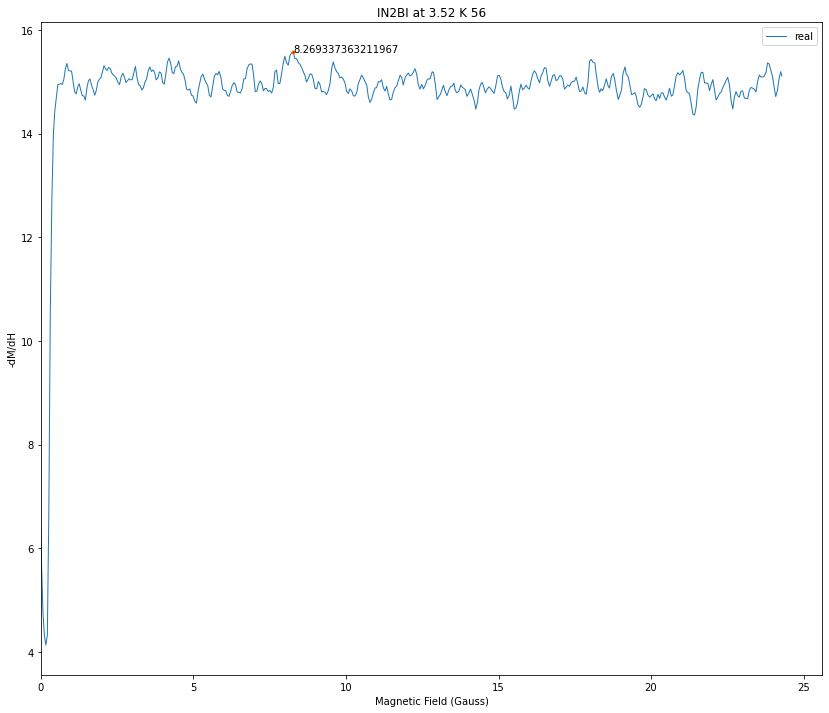

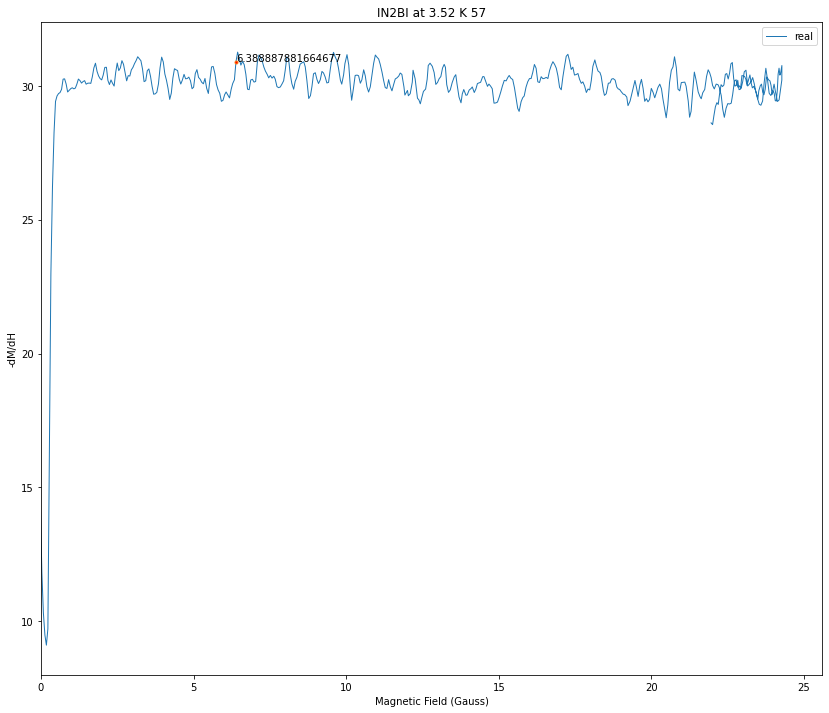

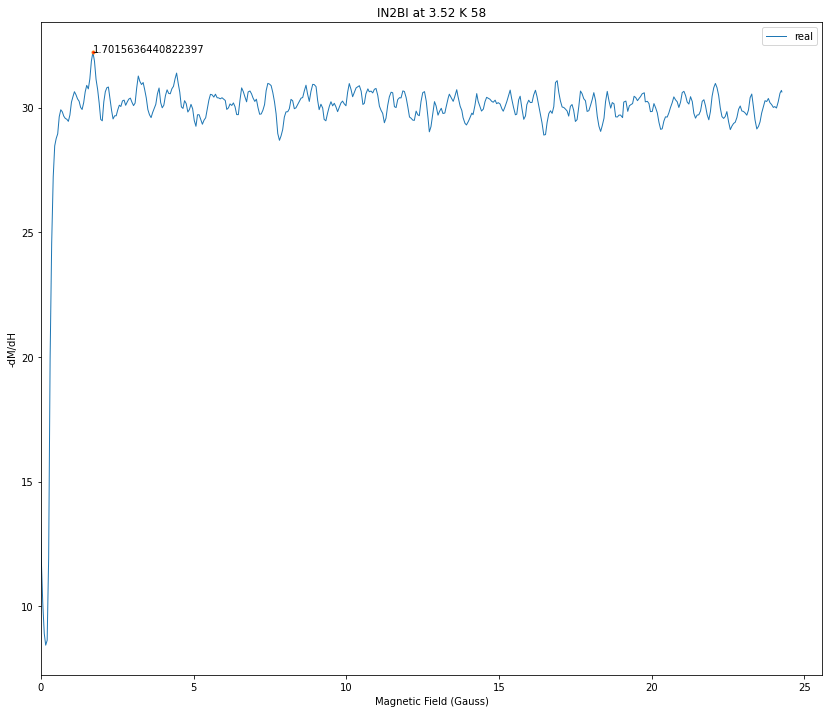

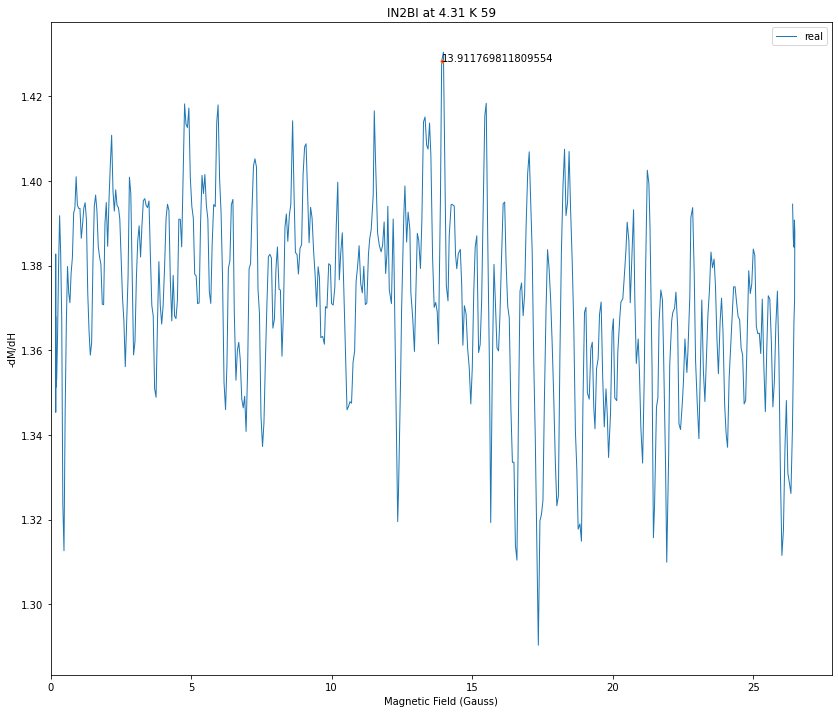

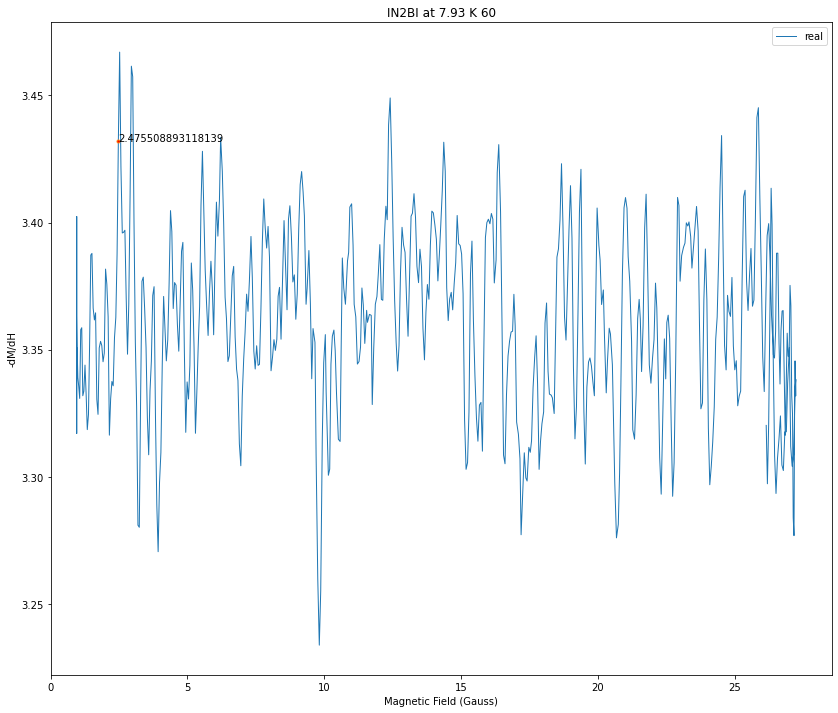

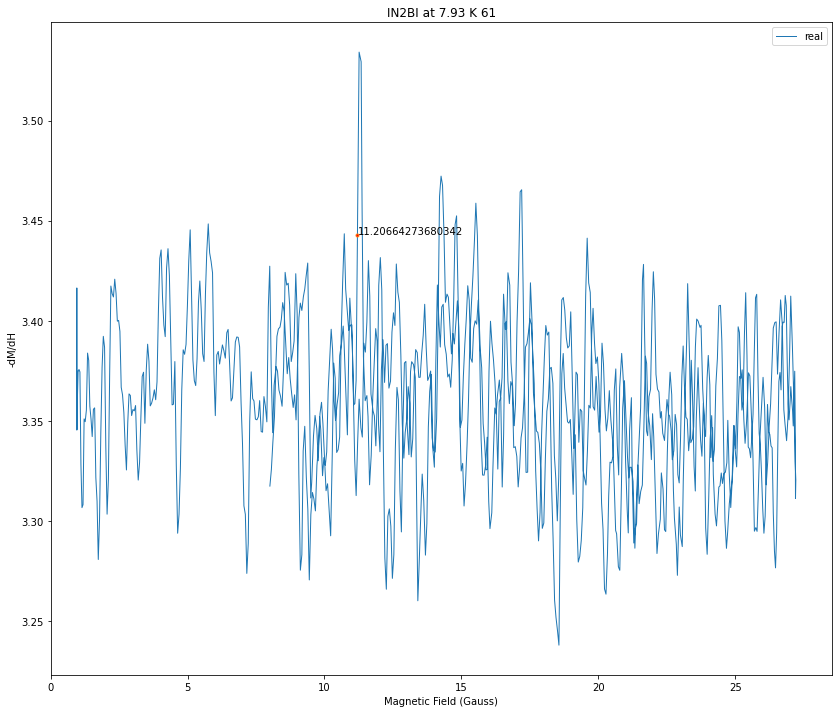

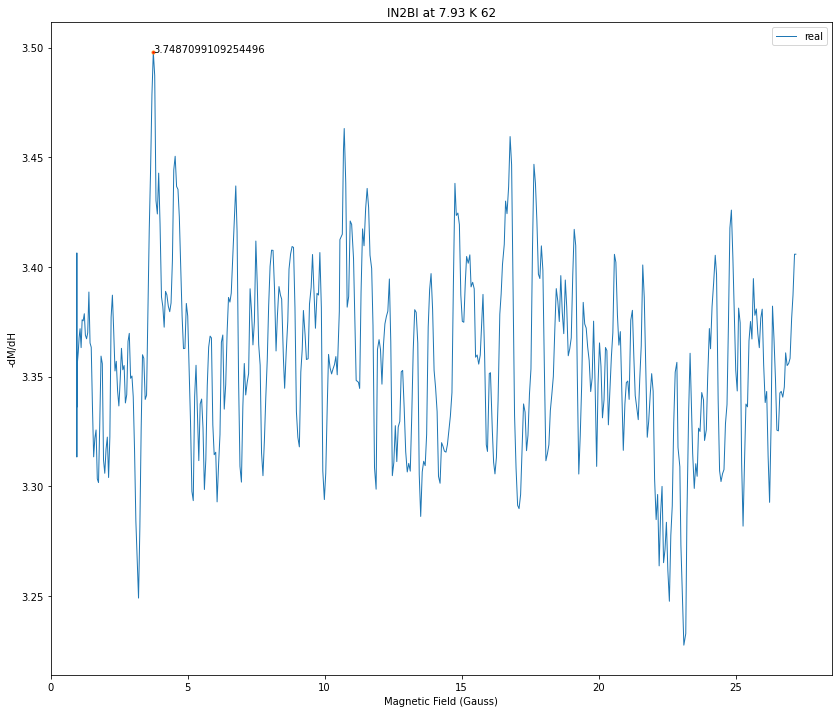

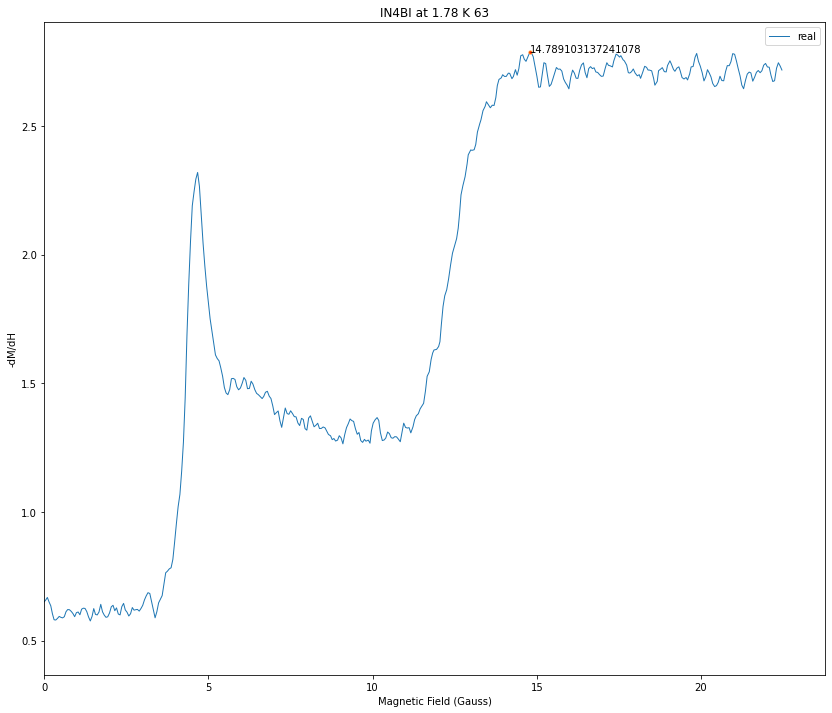

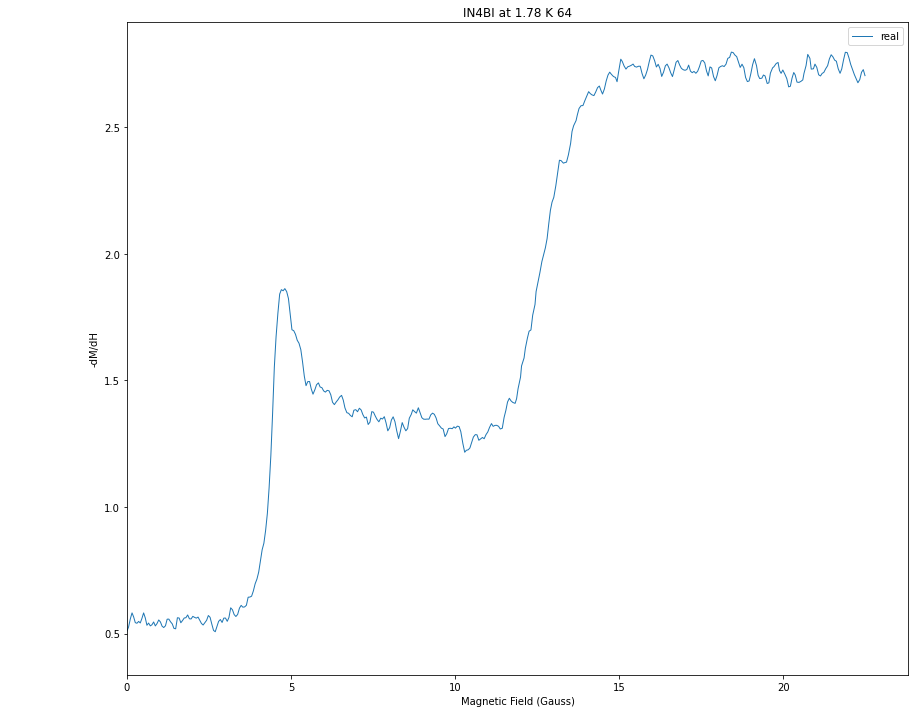

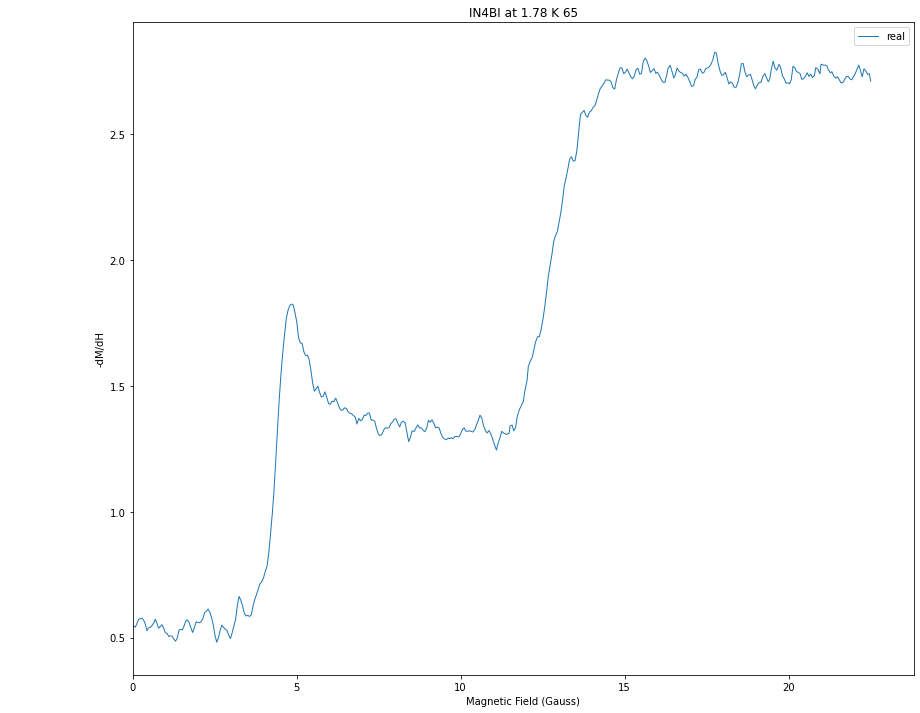

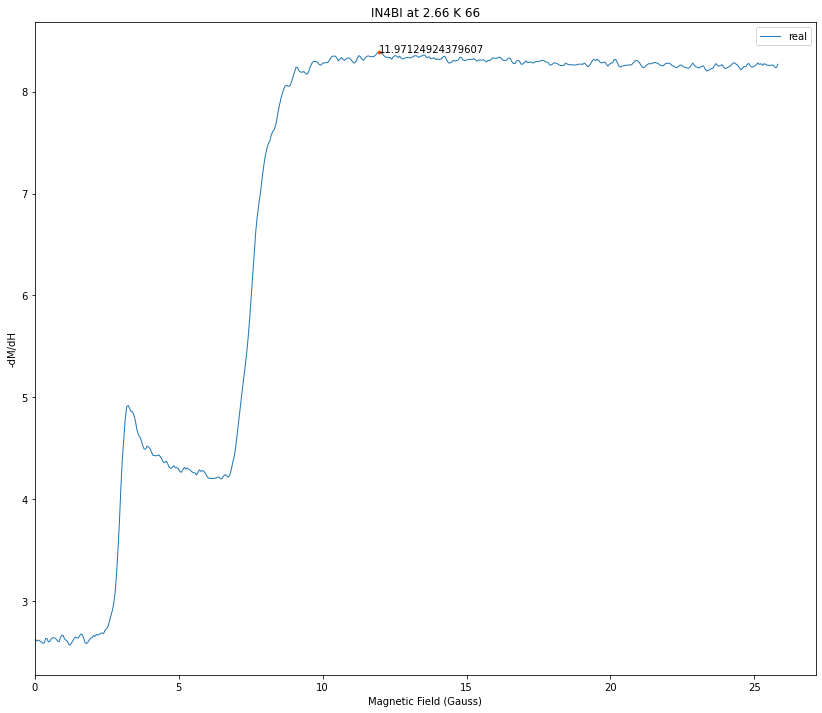

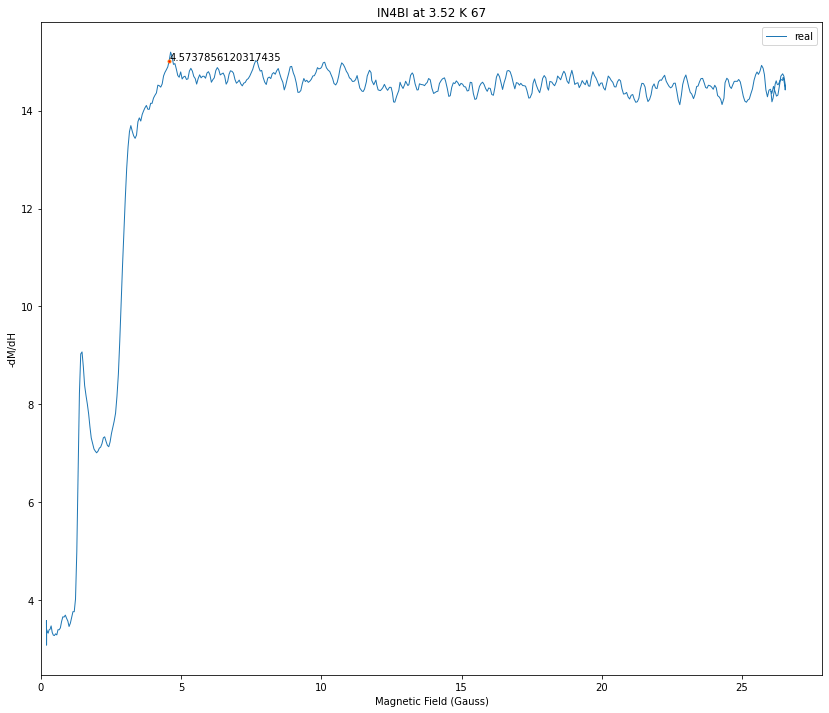

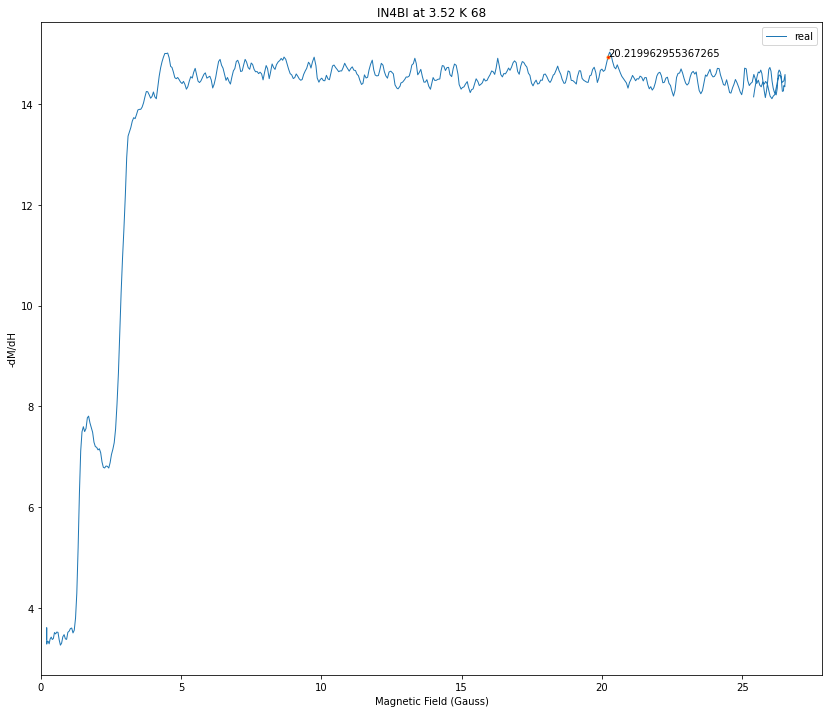

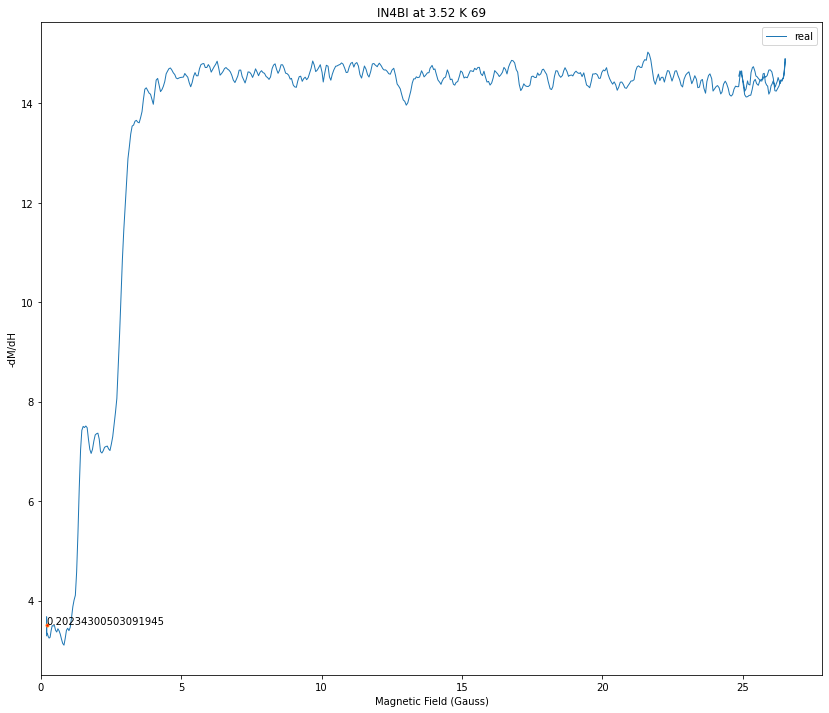

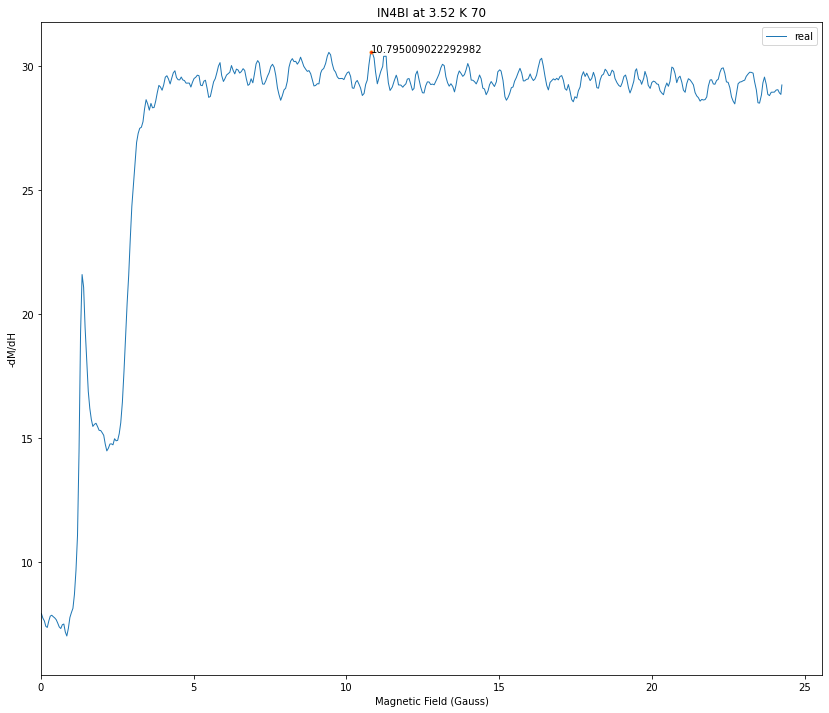

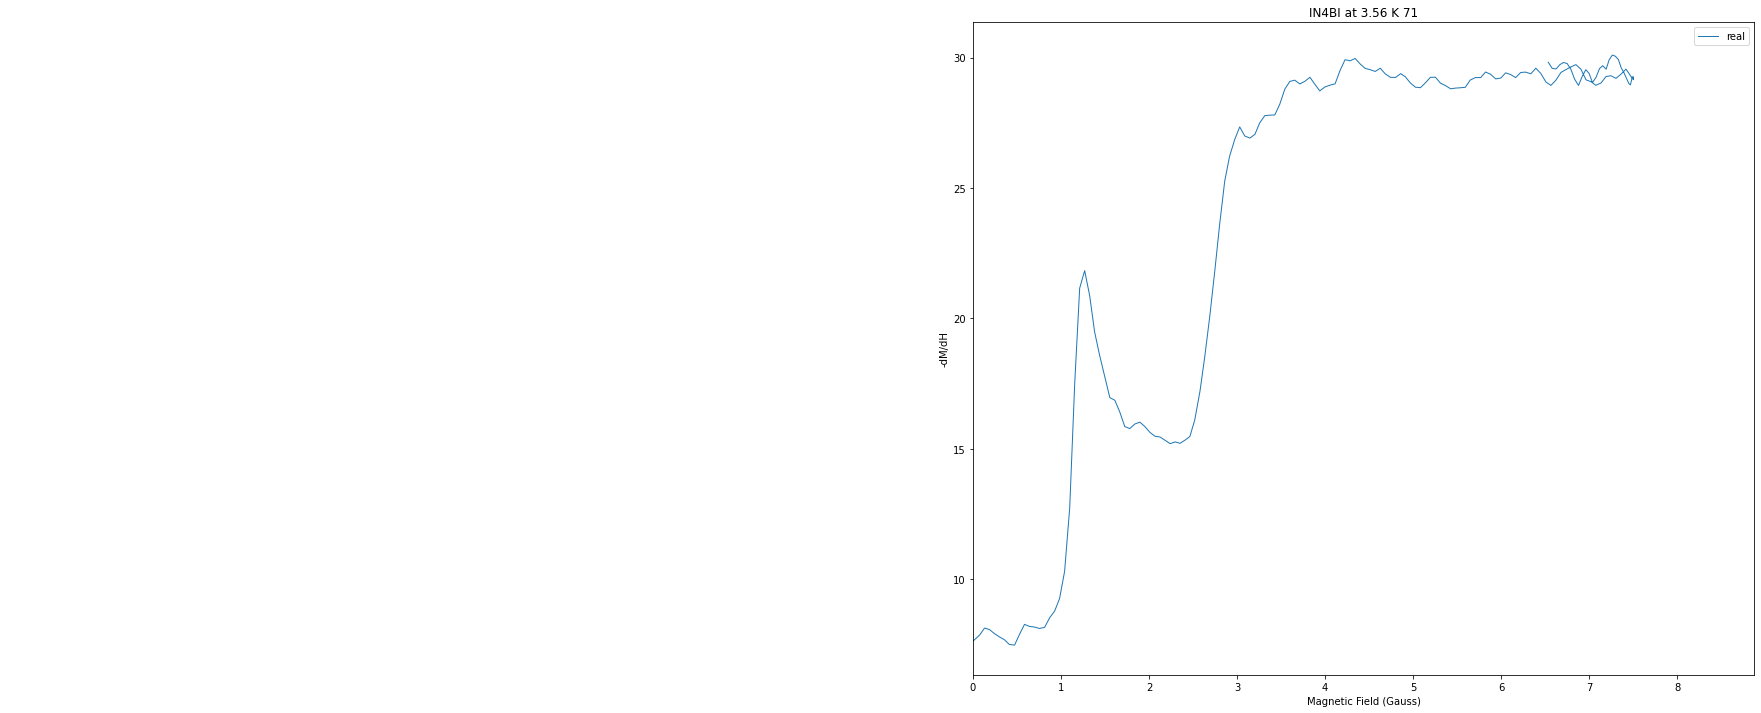

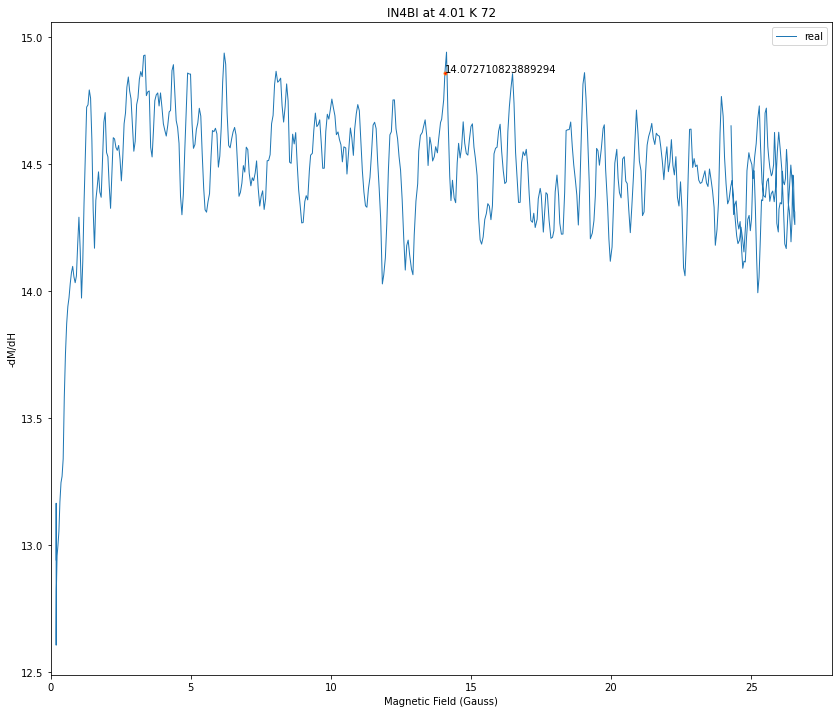

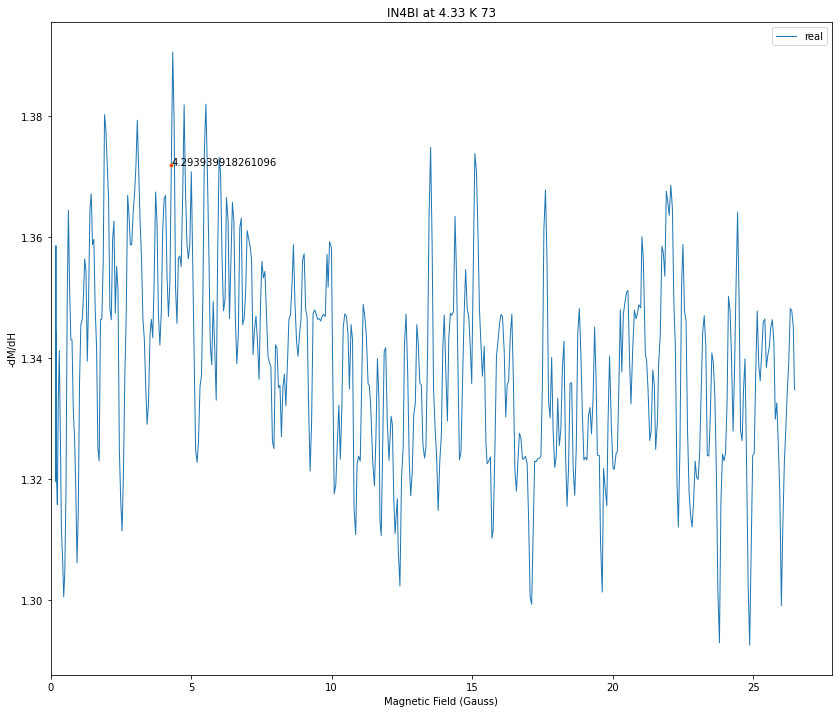

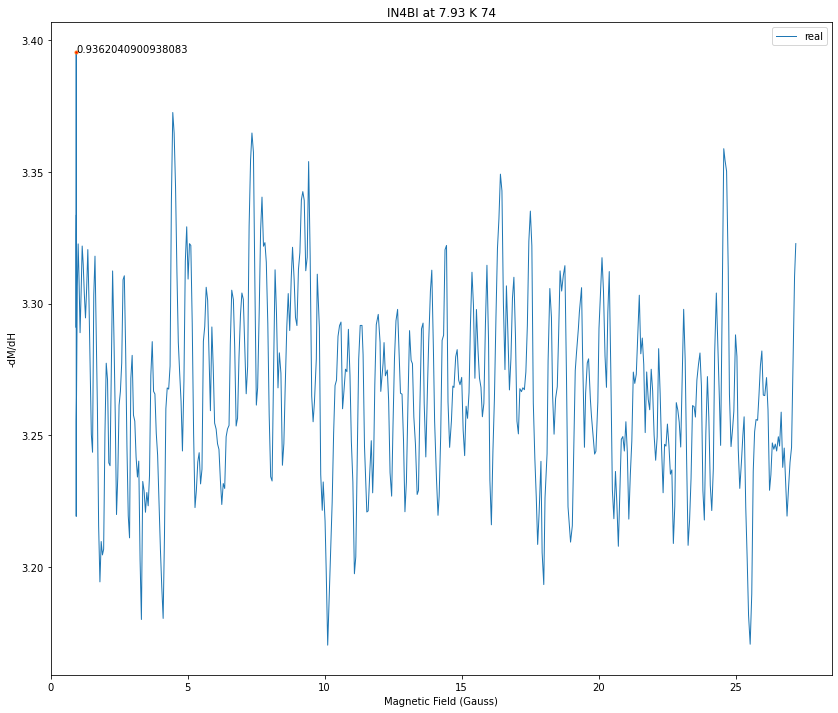

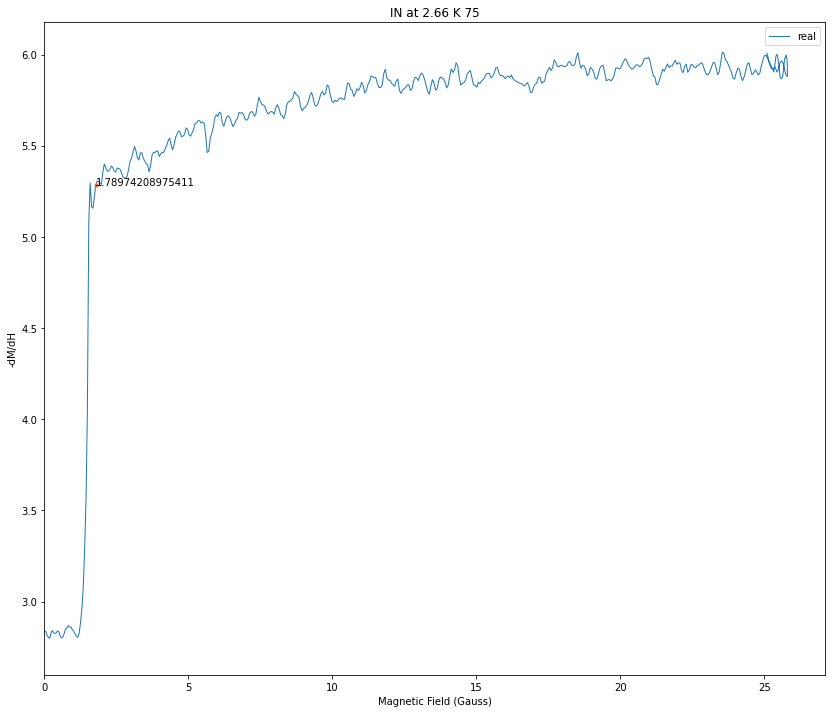

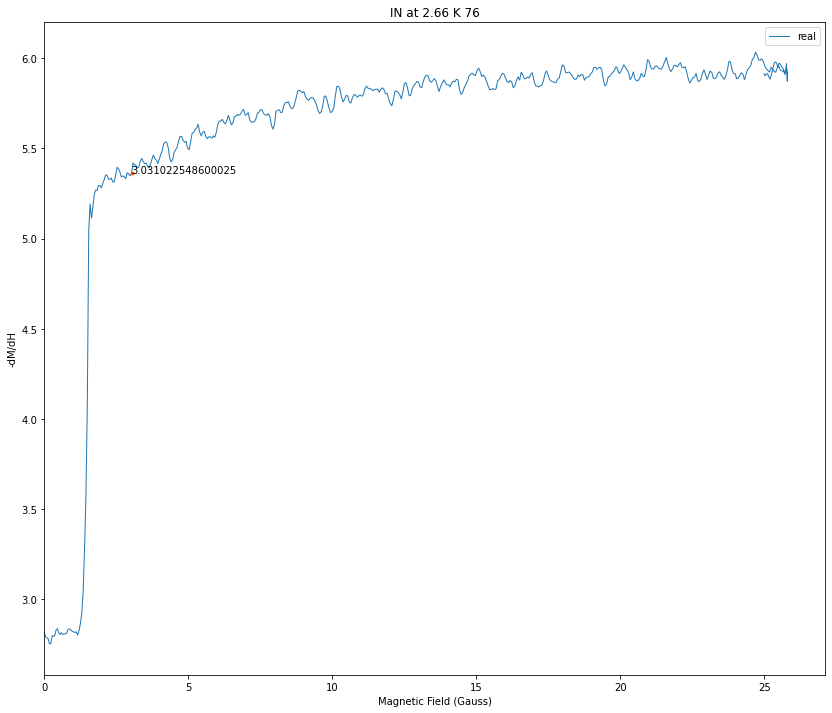

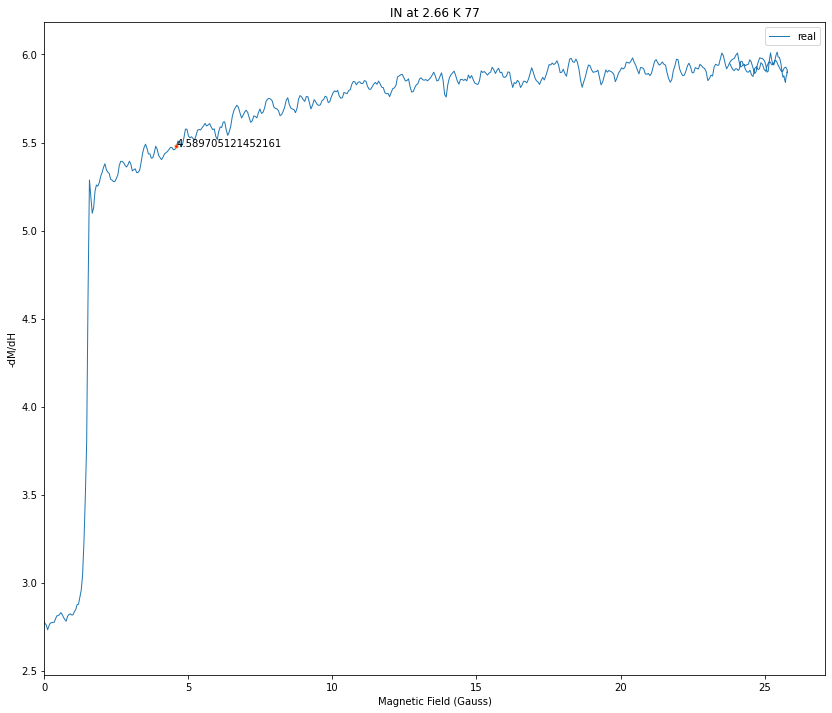

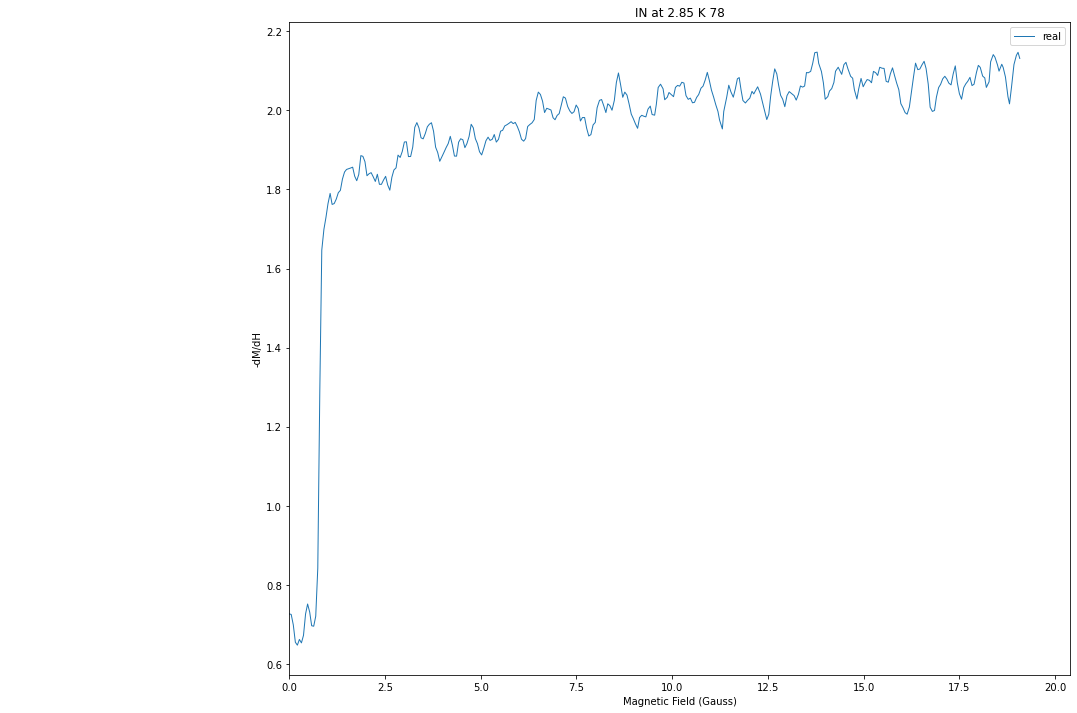

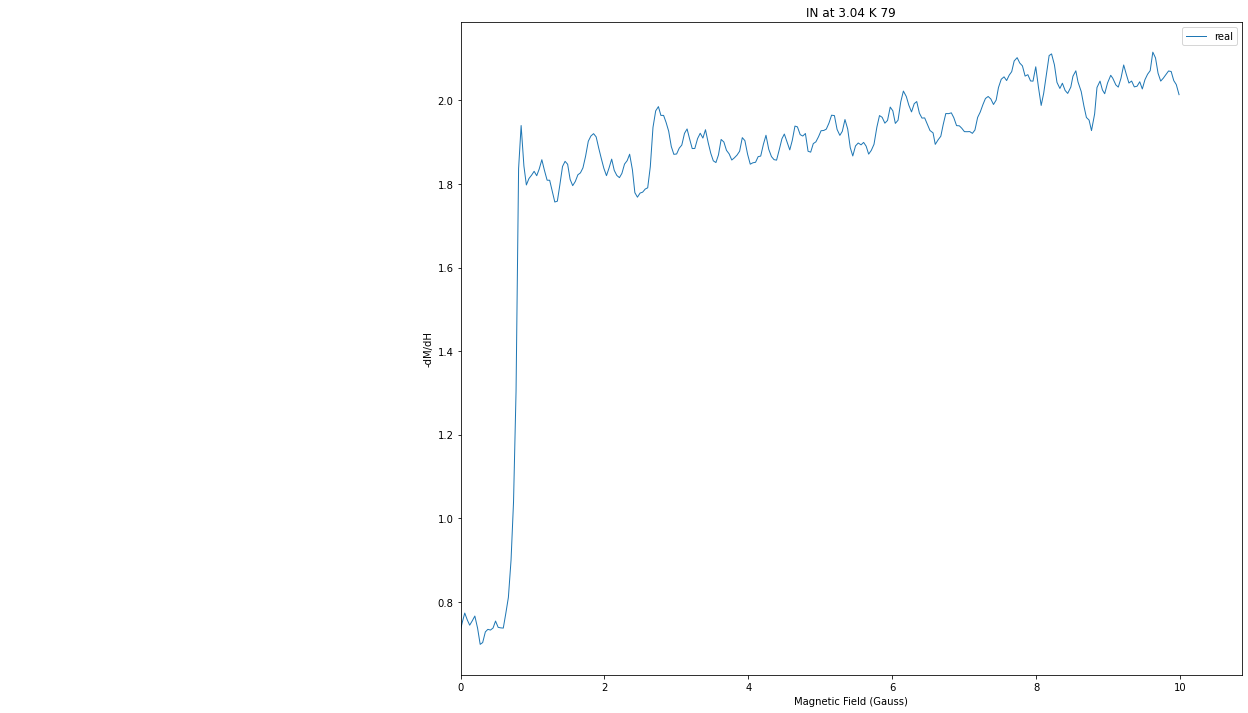

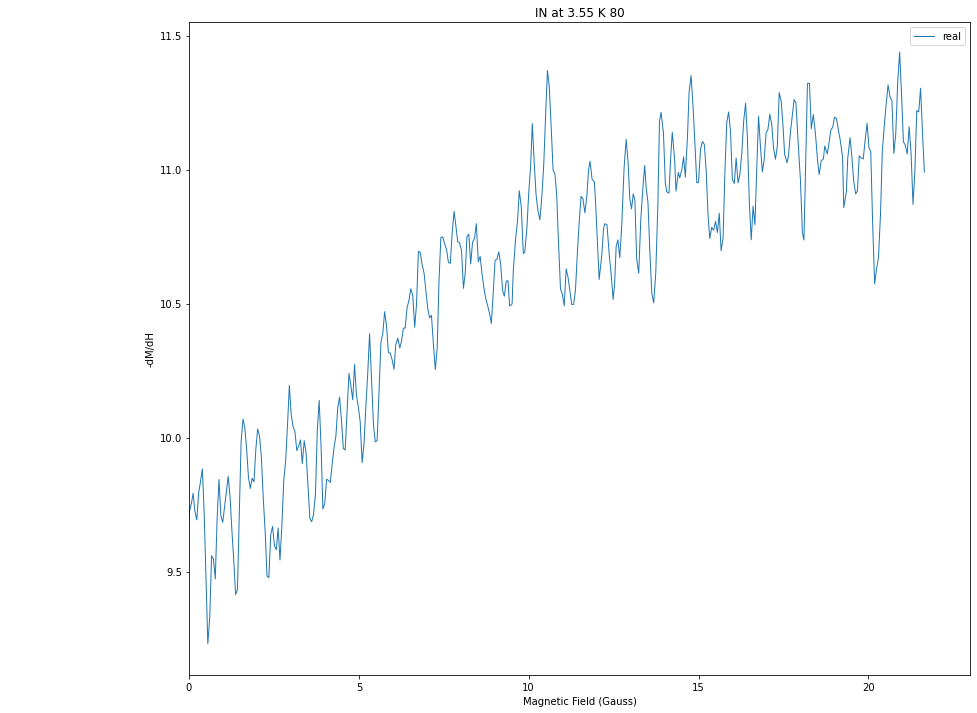

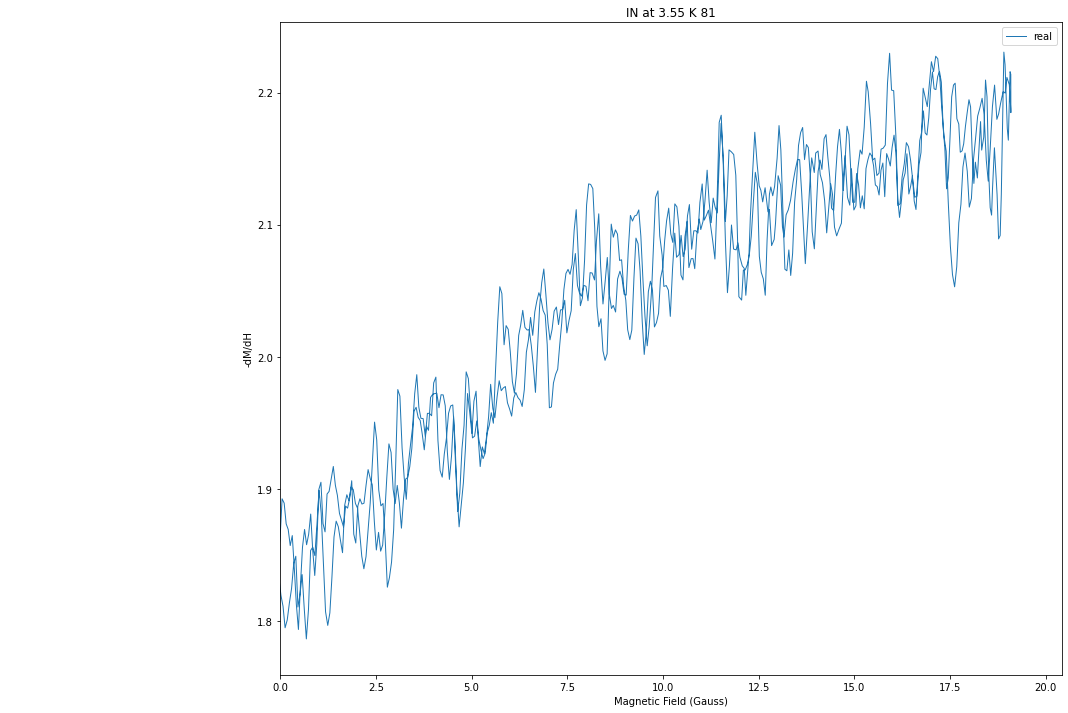

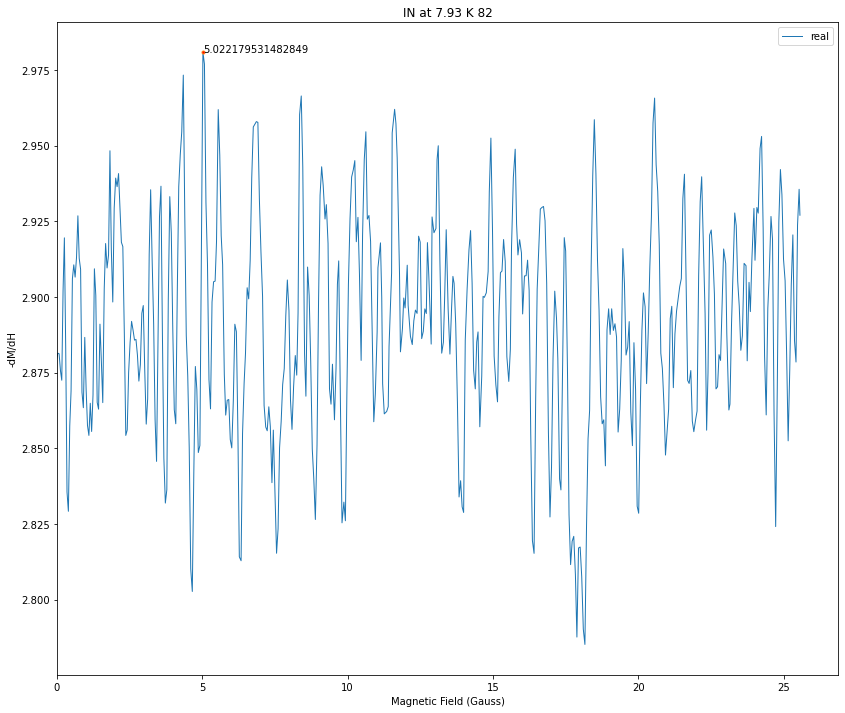

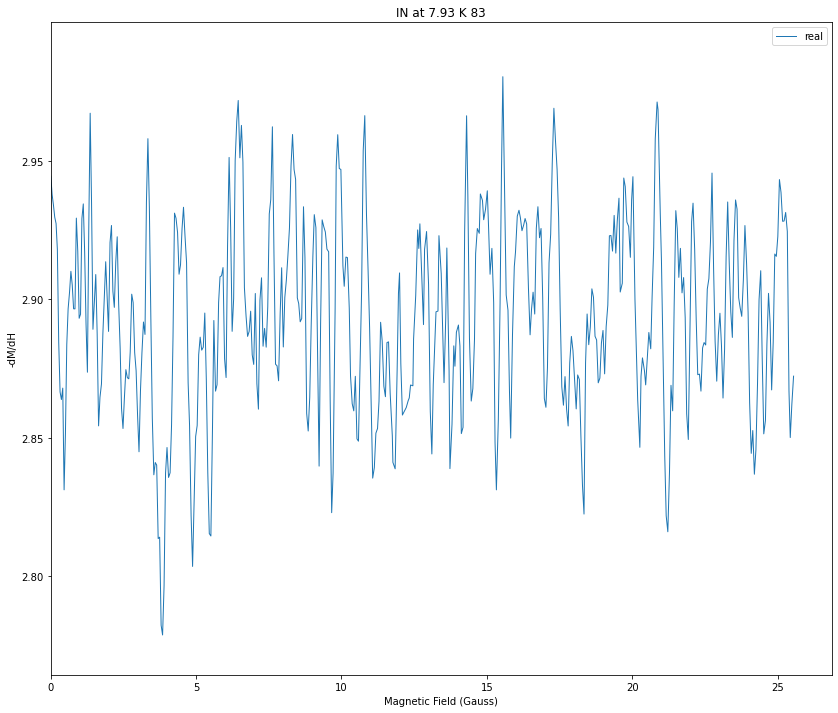

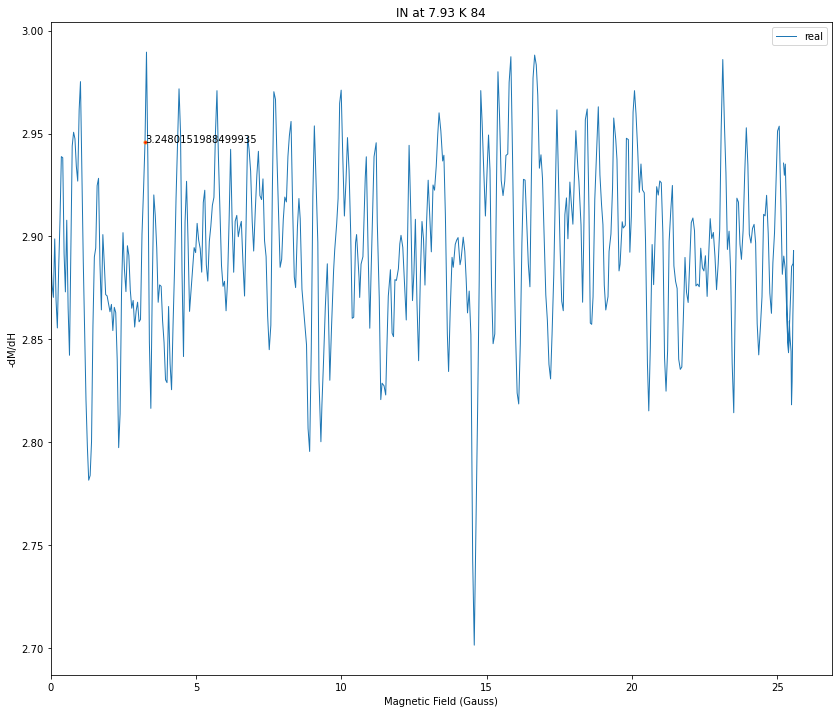

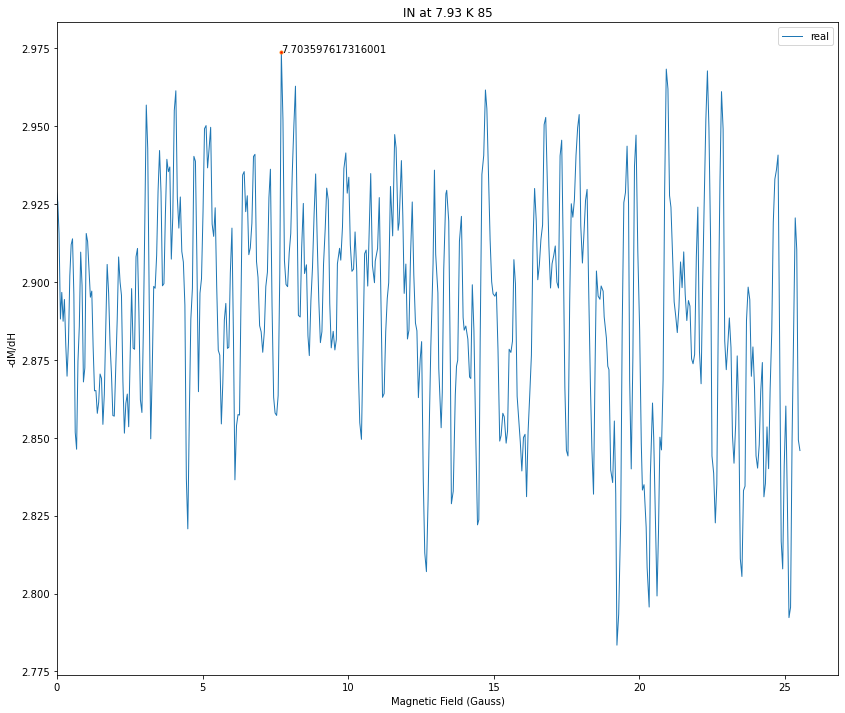

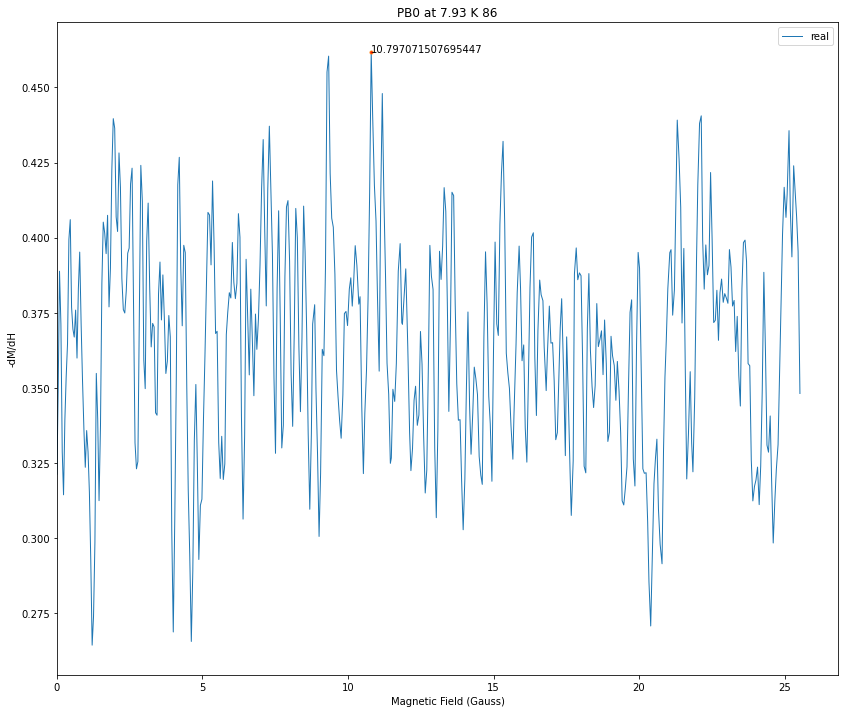

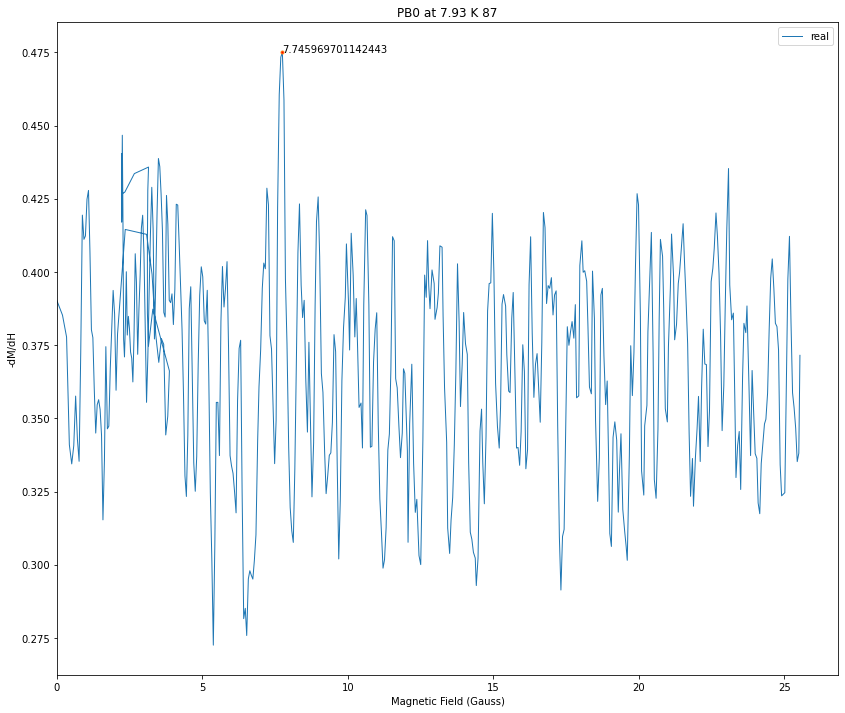

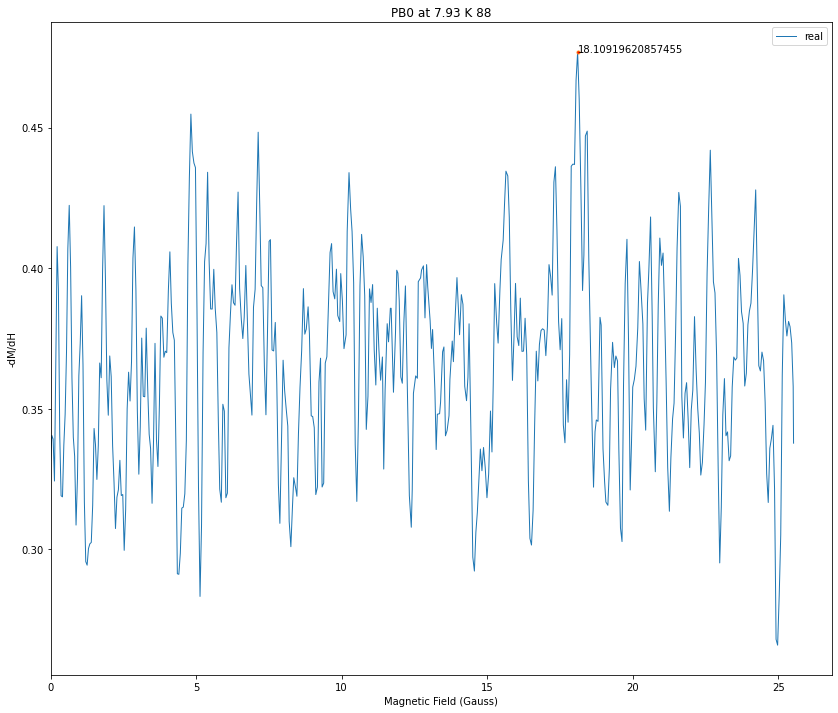

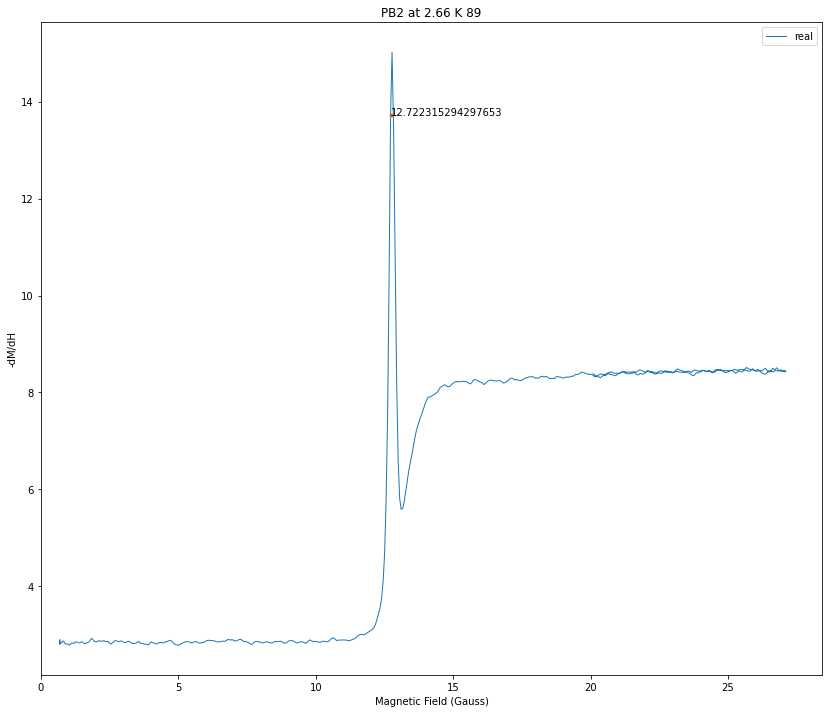

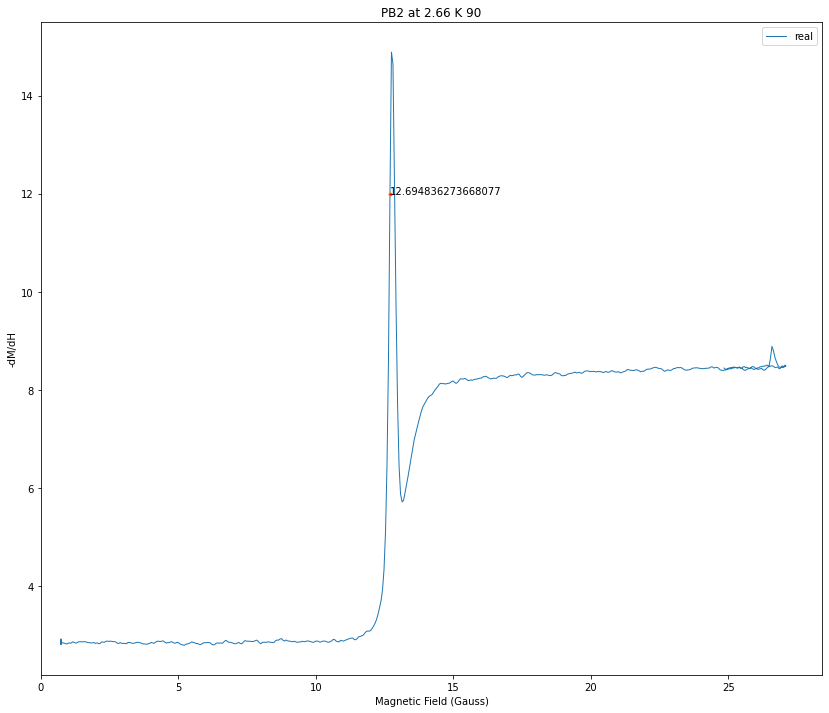

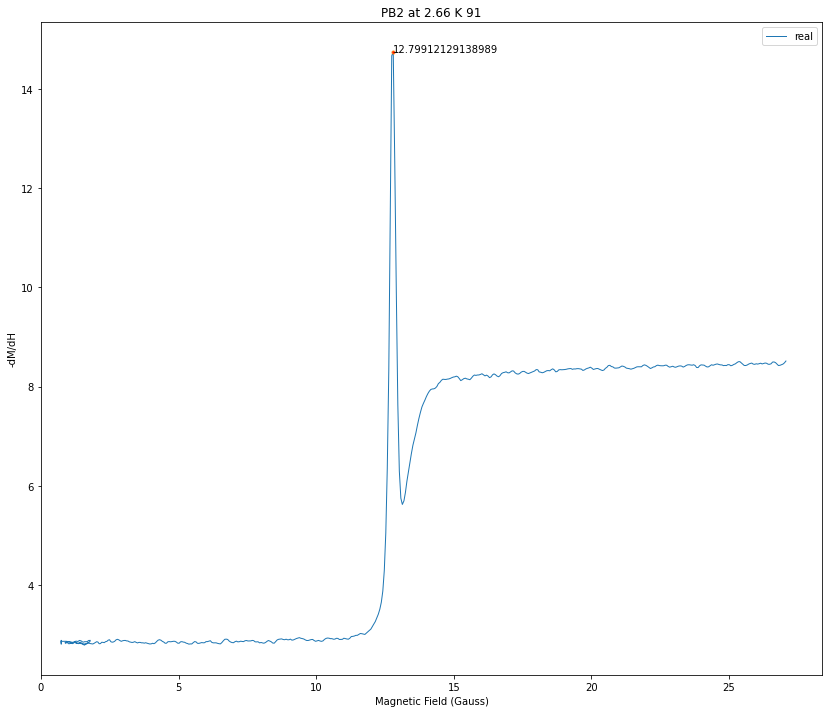

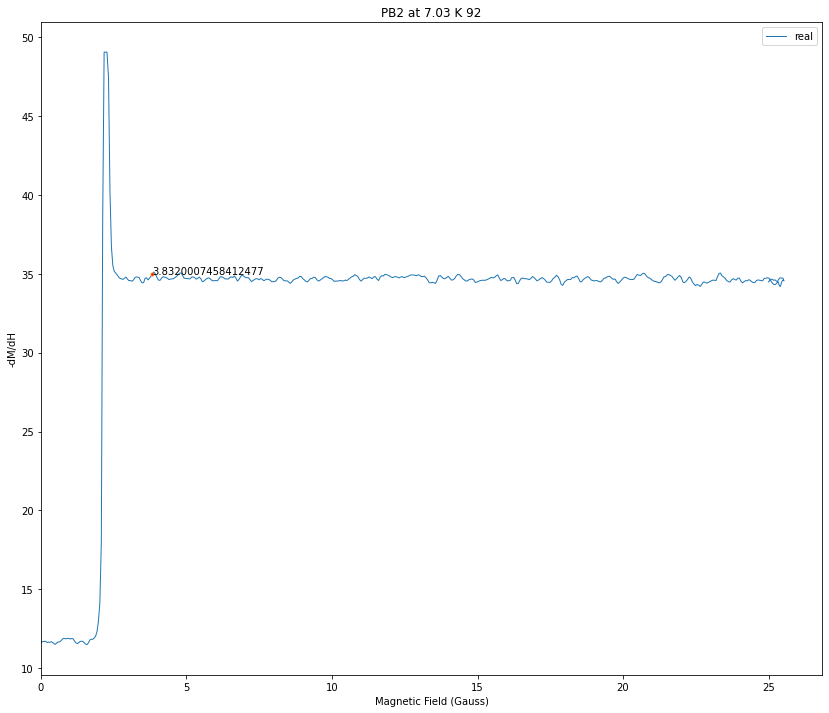

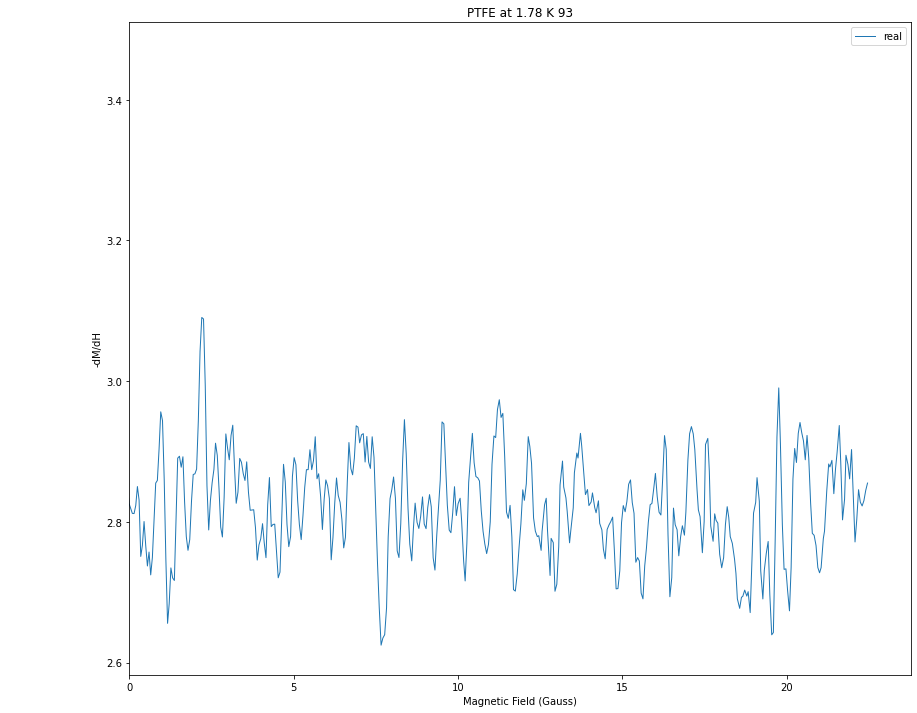

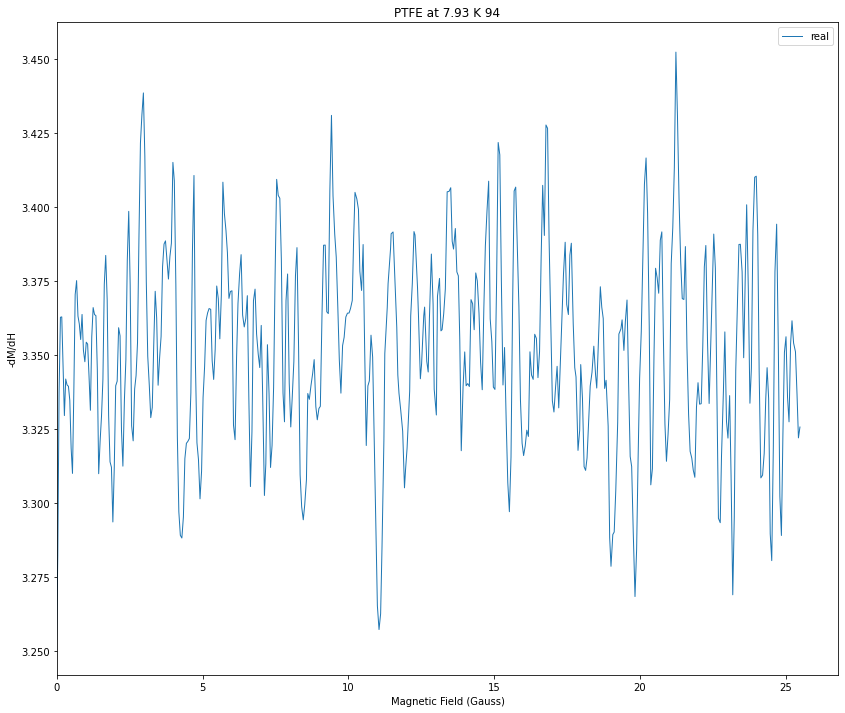

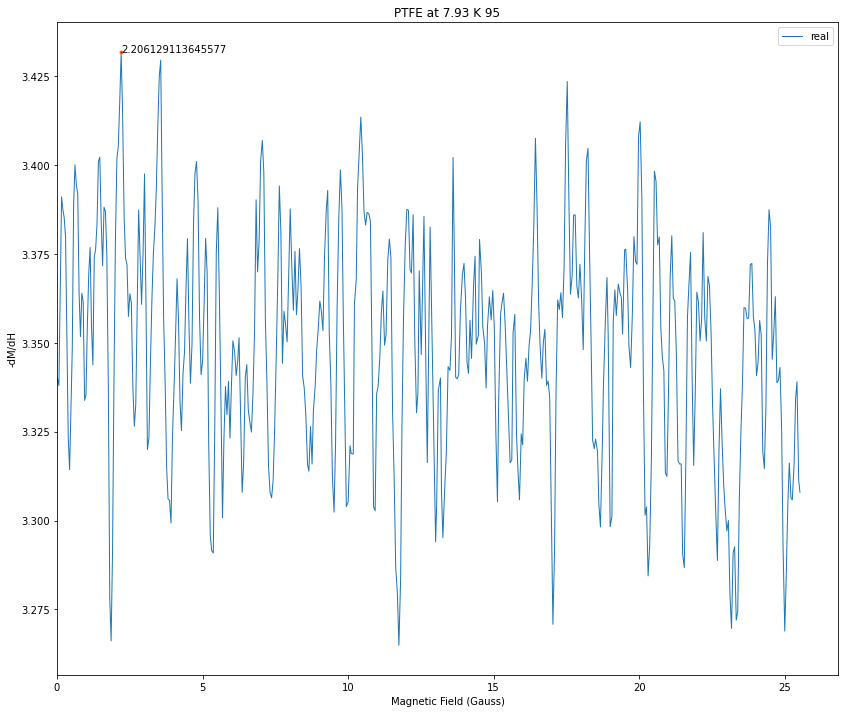

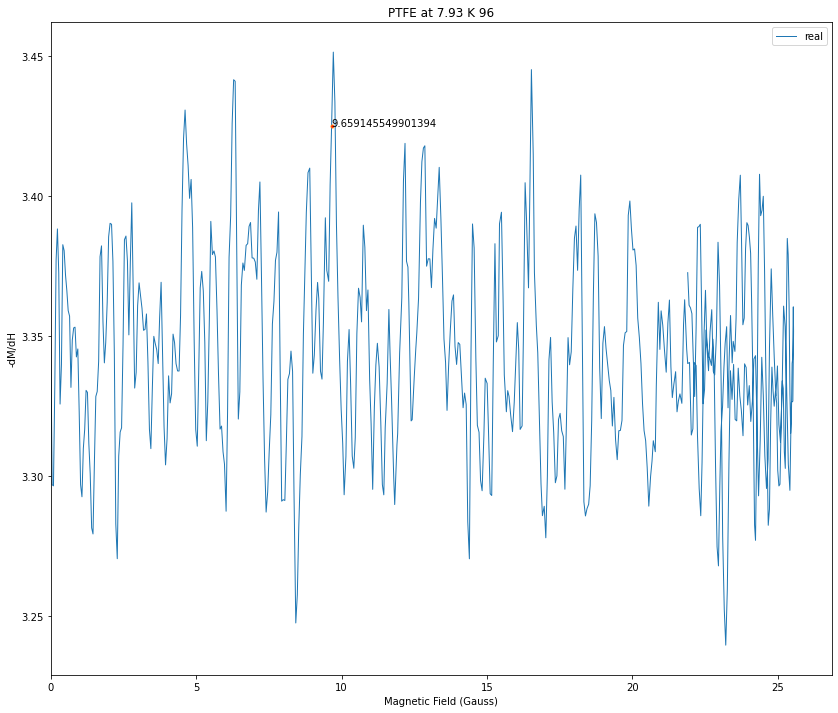

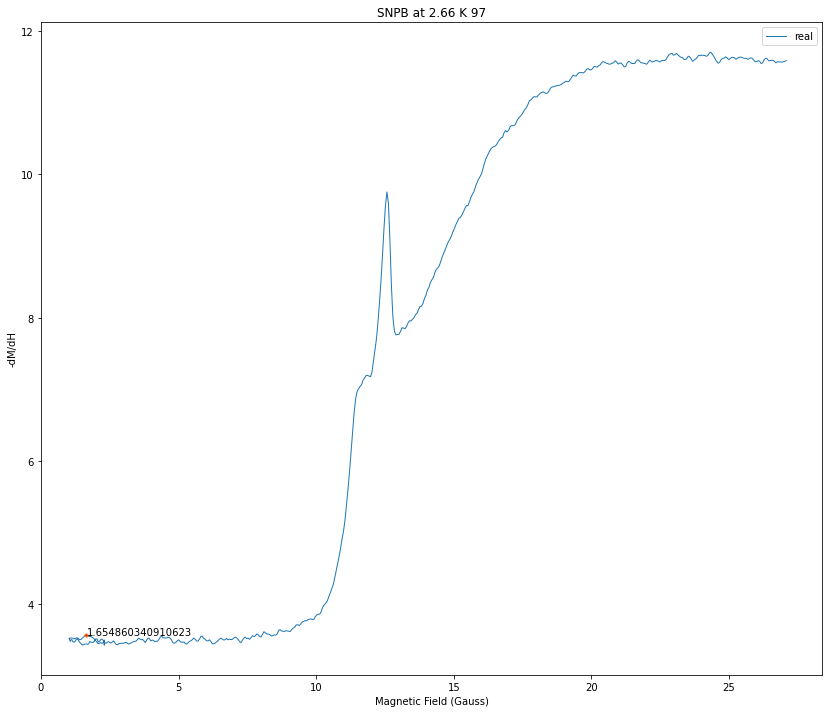

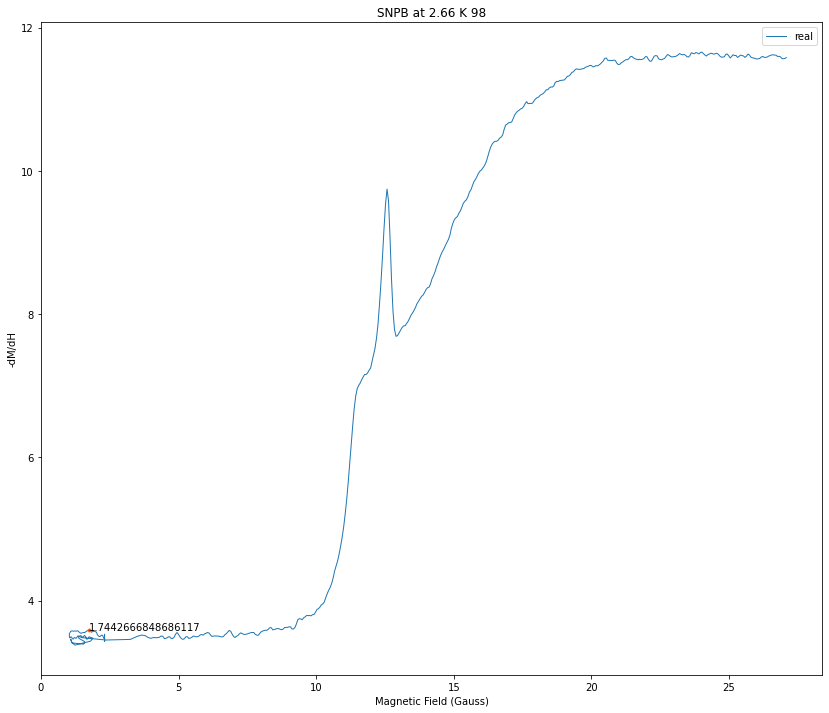

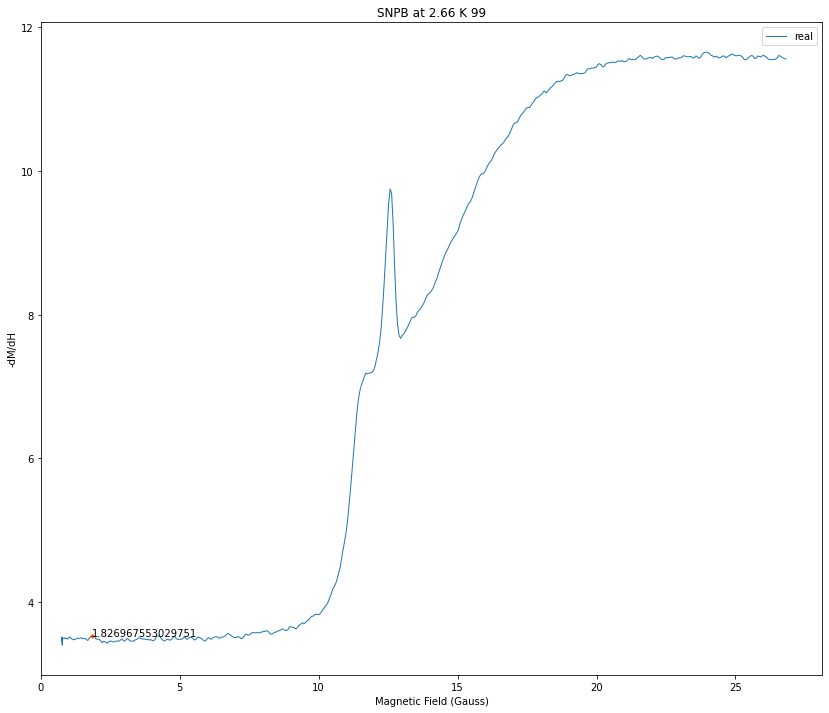

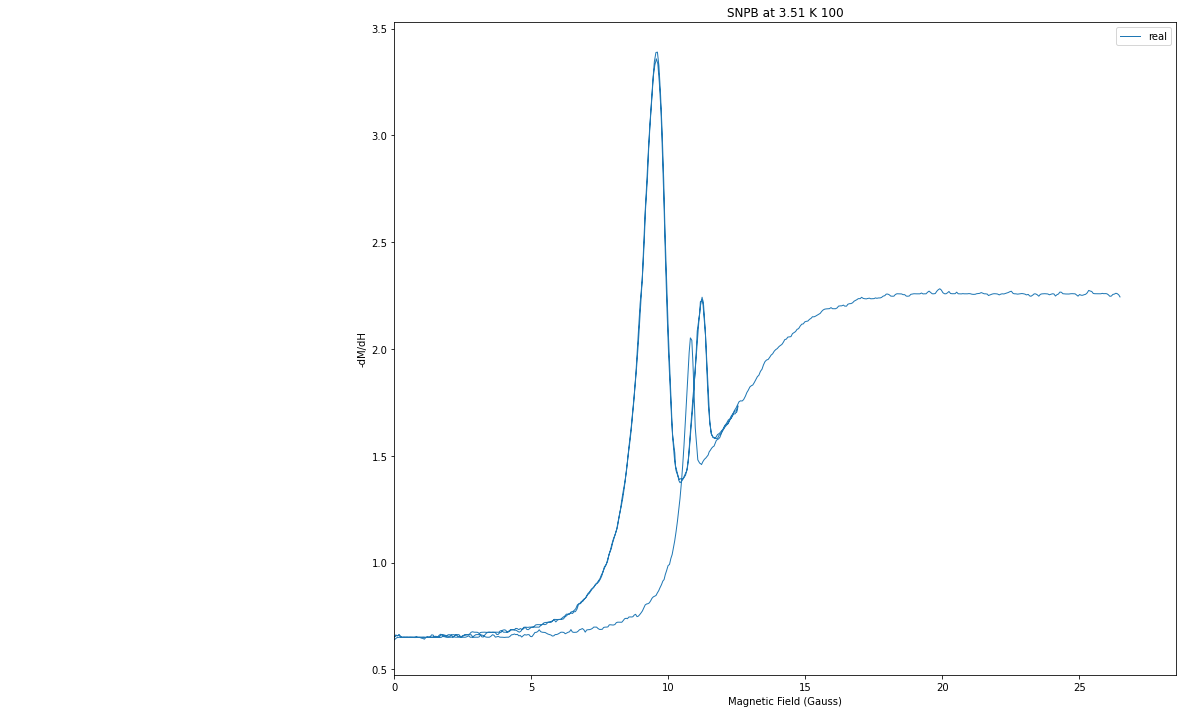

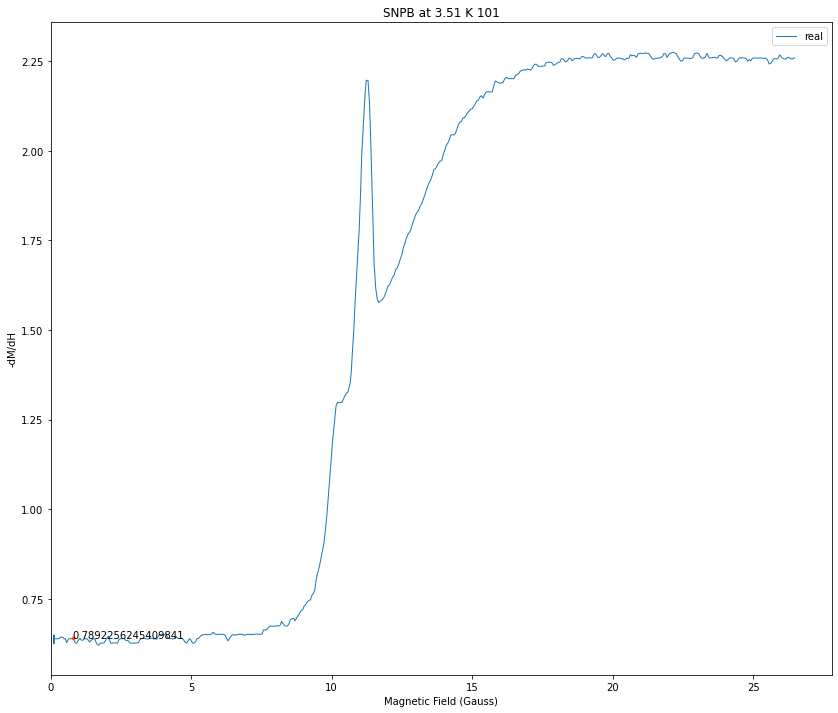

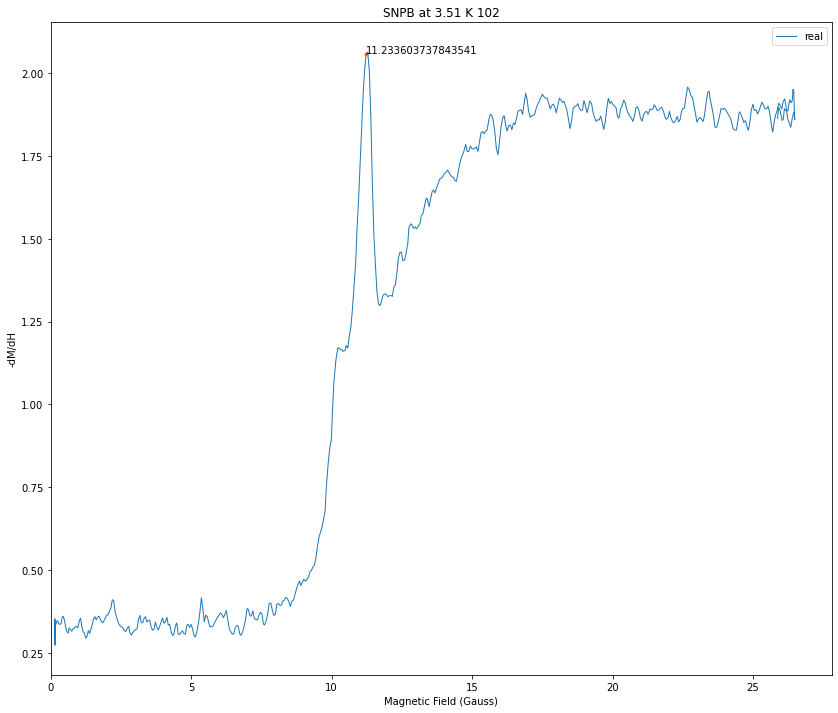

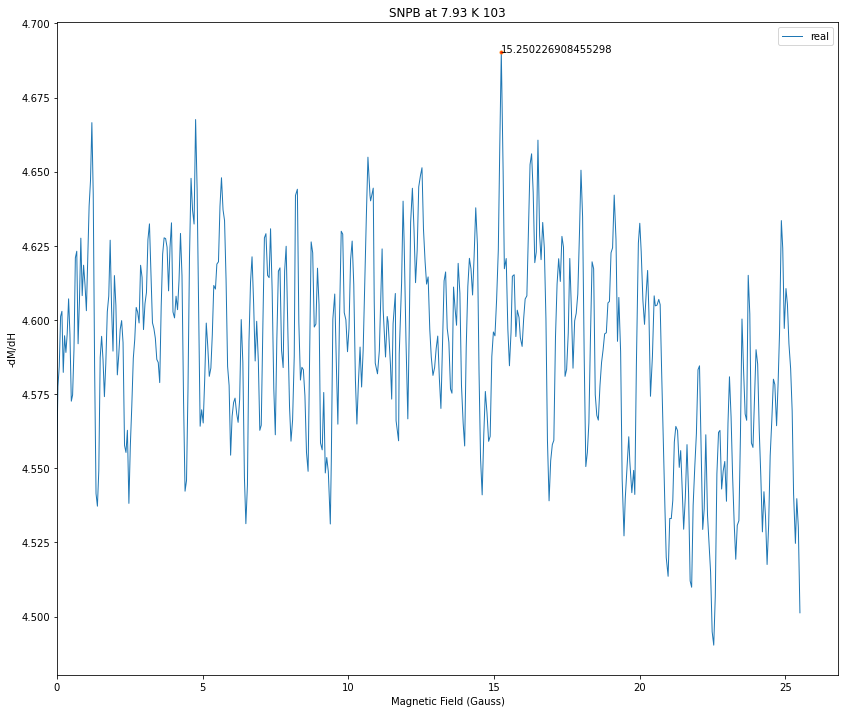

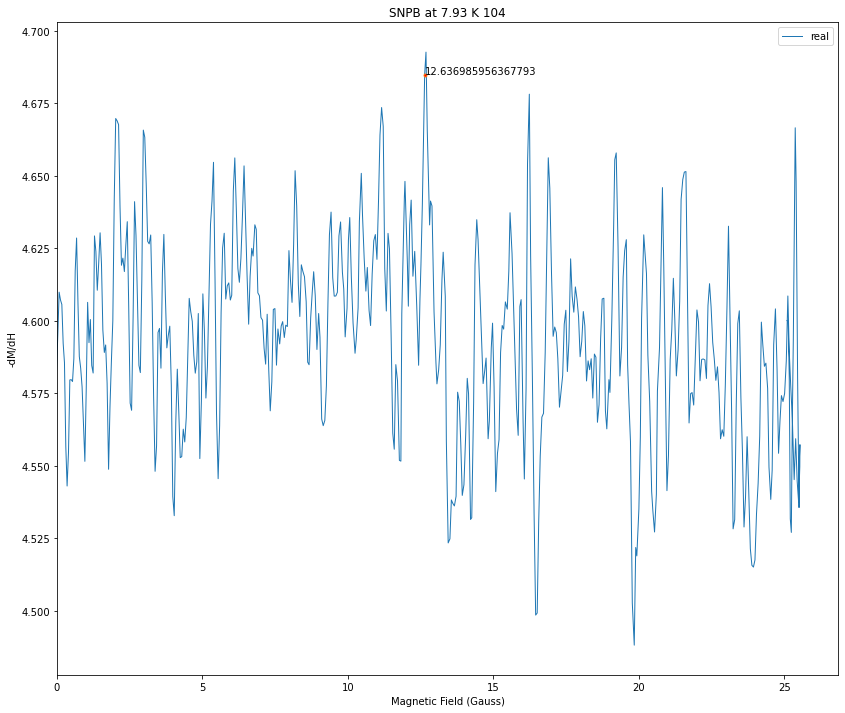

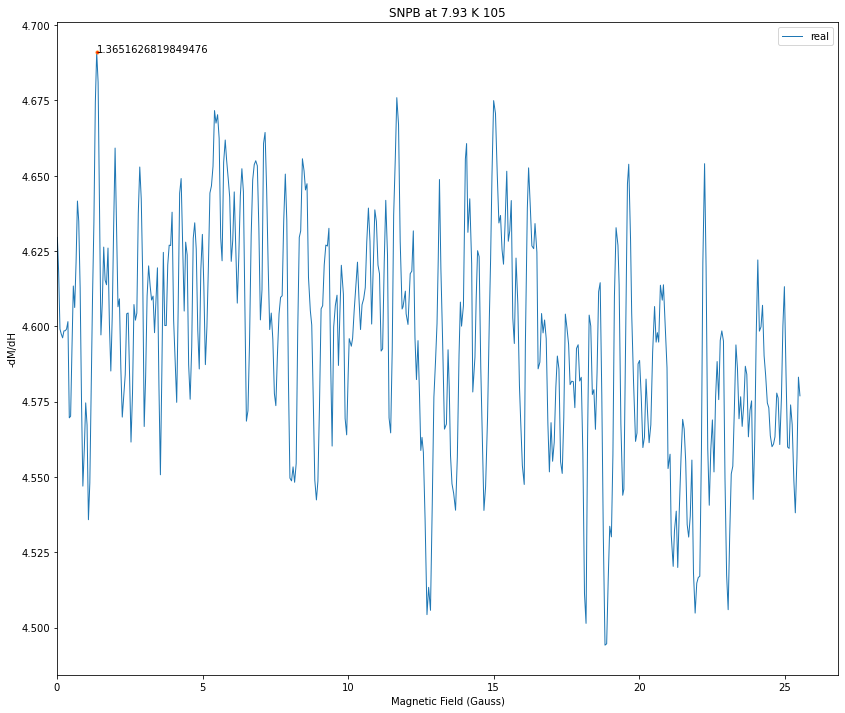

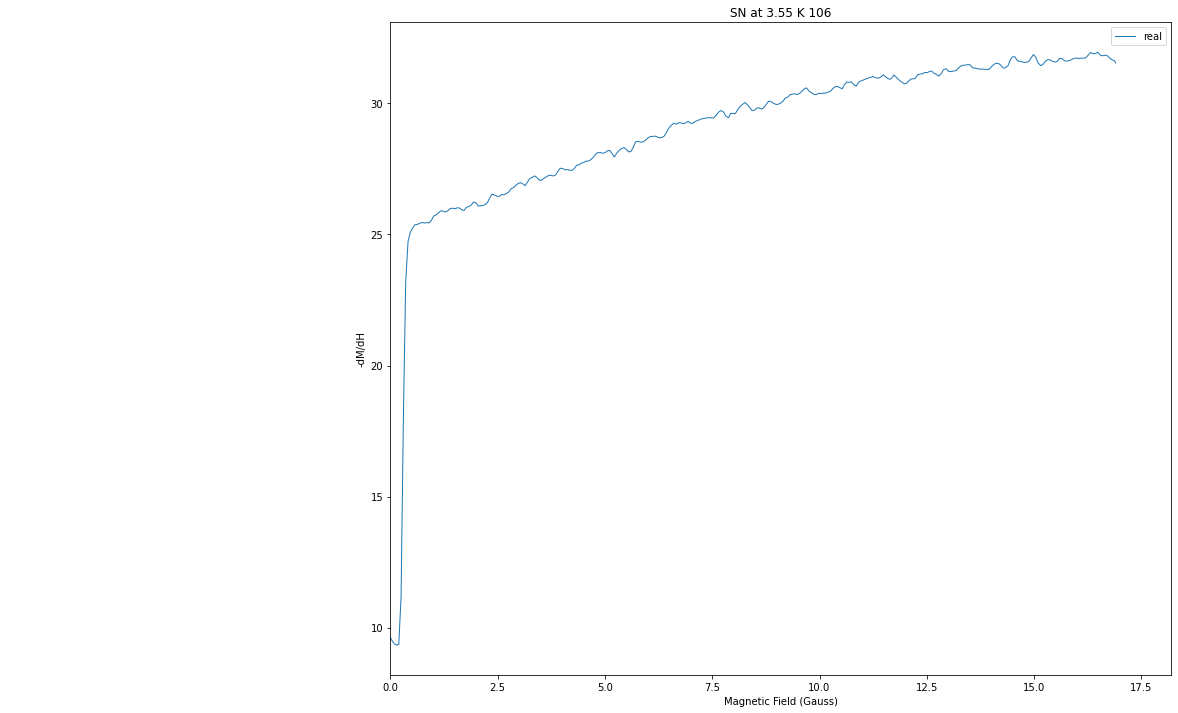

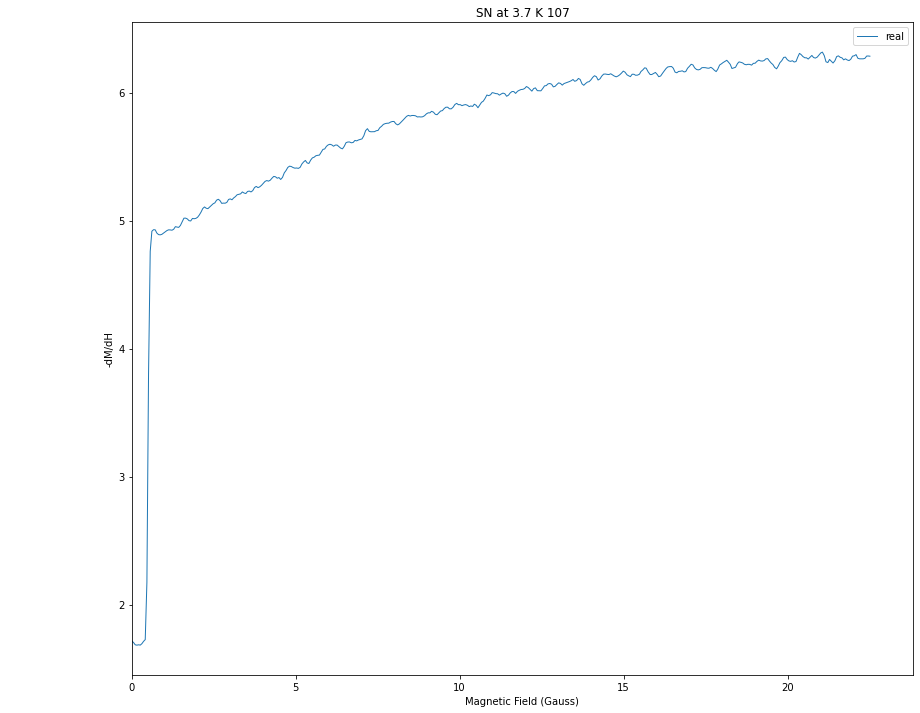

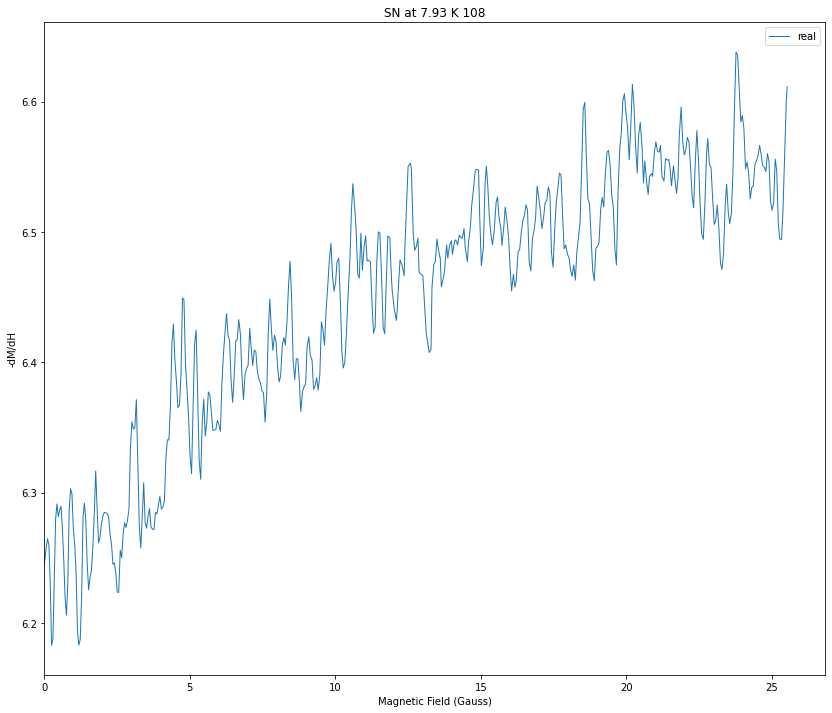

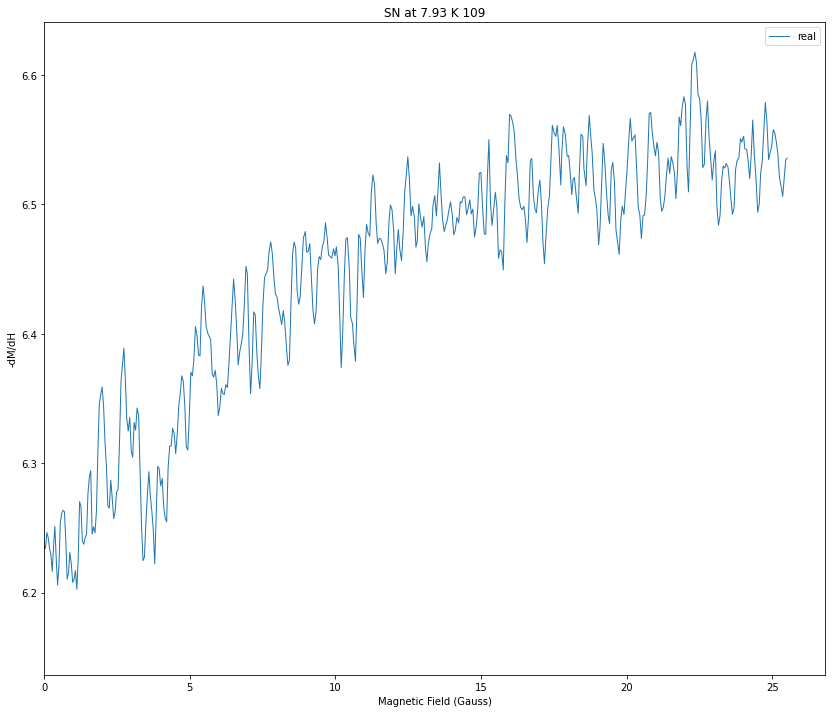

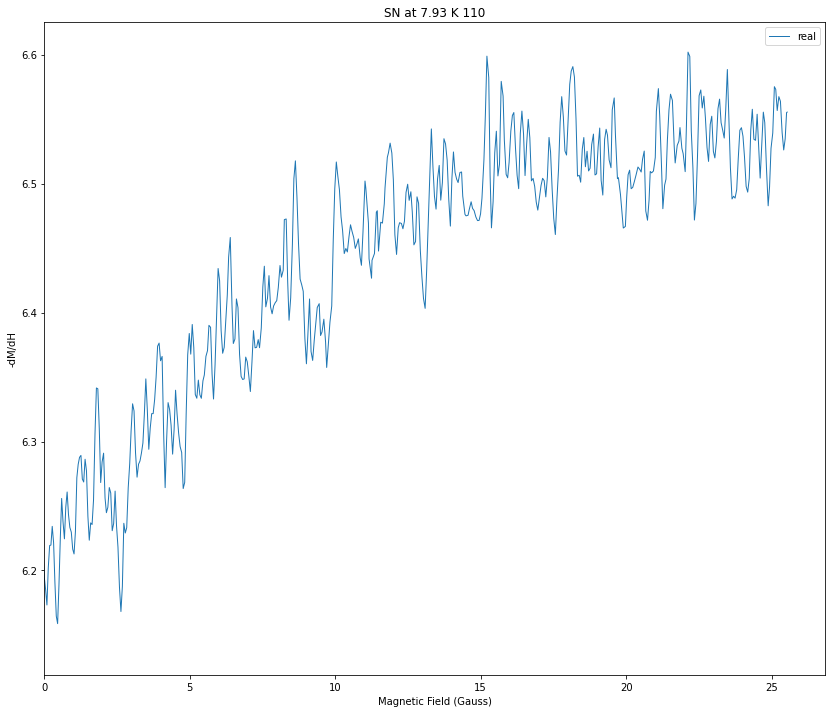

In [4]:
#### determinr HC at zero temperature and Tc by doing a fit 
files = glob.glob('*.txt')
files.sort()


list_samples = []
list_temperatures = []
list_critical_B = []

def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

for i, file in enumerate(files):   
    df = pd.read_table(file,names = ['v0','v1','v2','v3'])
    
    #dropping the second half of the sweep down (hysterisis) because the way down often doesn't even have a peak 
    try: 
        row_drop1 = df[df['v0']== max(df['v0'])].index[0]
    except IndexError: 
        row_drop1 = int(len(df['v0'])/2) #if there is an nan error, just takes the half of the length of the total series 

    row_drop2 = len(df['v0'])
    df = df.drop(labels=range(row_drop1, row_drop2), axis=0)
    
    df = df.dropna()
    df = m*df + b
    
    
    
    #finding second derivative in order to find the peaks in the voltage vs. magnetic field 
    #first_derivative = df.diff()
    #second_derivative = first_derivative.diff()
    #df['2derivative'] = second_derivative['v1']
    
    ######df['smooth'] = df['v1'].rolling(window=10).mean()
    #df['smooth'] = scipy.signal.savgol_filter(df['v1'], 11, 3 )
    
    
    peak_position = find_peaks(df['v1'], height = .001 , threshold = .001, distance = 400 )
    #print(peak_position)
    #peak_position = df['2derivative'].idxmin() #x axis position

    
    index1_temp = find_nth(file, "_", 2) + 1
    index2_temp = find_nth(file, "K", 1)
    
    index1_name = find_nth(file, "_", 1) + 1 
    index2_name = find_nth(file, "_", 2) 
    
    sample_temperature = file[index1_temp:index2_temp]
    sample_name = file[index1_name: index2_name]

    
    if sample_name == "PTFE" and index2_temp == -1:
        index1_temp = find_nth(file, "_", 2) + 1
        index2_temp = find_nth(file, "T", 2)
        sample_temperature = file[index1_temp:index2_temp]
        
        if float(sample_temperature) == 115e-1: 
            sample_temperature = 1.78
        elif float(sample_temperature) == 450: 
            sample_temperature = 3.7
 
    if index2_temp == -1: 
        index1_temp = find_nth(file, "_", 2) + 1
        index2_temp = find_nth(file, "T", 1)
        sample_temperature = file[index1_temp:index2_temp]

        if float(sample_temperature) == 115e-1: 
            sample_temperature = 1.78
        elif float(sample_temperature) == 450: 
            sample_temperature = 3.7
        
    
    sample_temperature = float(sample_temperature)


    
    list_samples.append(sample_name)
    list_temperatures.append(sample_temperature)
    
    
    peak_position = peak_position[0][0]
    list_critical_B.append(df['v0'][peak_position])
    

    fig = plt.figure(figsize=(14,12))
    ax = fig.add_subplot(111)


    df.plot(x = 'v0', y = ['v1'],label=['real'], linewidth=1, ax=ax)
        #df.plot(x = 'v0', y = ['v1', 'smooth', '2derivative'],label=['real', 'smooth', '2nd derivative'], linewidth=1, ax=ax)

        #df.plot(x = 'v0', y = ['v1','2derivative'],label=['real','2nd derivative'], linewidth = 1, ax=ax)



    #     plt.plot(df['v0'][peak_position], df['v1'][peak_position], marker="o", markersize=3, markerfacecolor= "red", label = df['v0'][peak_position])
    #     plt.xlabel("Magnetic Field (Gauss)")
    #     plt.ylabel("-dM/dH")
    #     plt.annotate(str(df['v0'][peak_position]), (df['v0'][peak_position], df['v1'][peak_position]), ha = 'left')
    #     plt.xlim(left= 0)
    #     plt.title(sample_name + " at " + str(sample_temperature) + " K")

    ax.plot(df['v0'][peak_position], df['v1'][peak_position], marker="o", markersize=3, markerfacecolor= "red", label = df['v0'][peak_position])
    ax.set_xlabel("Magnetic Field (Gauss)")
    ax.set_ylabel("-dM/dH")
    ax.annotate(str(df['v0'][peak_position]), (df['v0'][peak_position], df['v1'][peak_position]), ha = 'left')
    ax.set_xlim(left= 0)
    ax.set_title(sample_name + " at " + str(sample_temperature) + " K " + str(i+2))
    
    
   
#plt.close("all")
#print(list_critical_B)


0    1.78
1    1.78
2    1.78
3    3.03
4    3.03
5    2.66
6    2.66
7    2.66
8    2.85
9    3.04
Name: 0, dtype: float64
0    3.370
1    3.412
2    3.408
3    0.798
4    0.802
5    1.595
6    1.592
7    1.572
8    1.069
9    0.842
Name: 0, dtype: float64


KeyError: (slice(None, None, None), None)

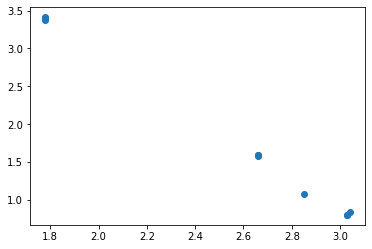

In [43]:
## samples = ['IN','PB2','SNPB','IN2BI','IN4BI', 'SN'] #superconducting
#controls = ["PTFE", "Cu"] #non-superconducting
PB0 = [[], []]
PB1 = [[], []]
IN = [[], []]
PB2 = [[], []]
SNPB = [[], []]
Cu = [[], []]
PTFE = [[], []]
IN2BI = [[], []]
IN4BI = [[], []]
SN = [[], []]

all_samples = {"IN": IN, "PB2": PB2, "SNPB": SNPB, "Cu": Cu, "PTFE": PTFE, "IN2BI": IN2BI, "IN4BI": IN4BI, "SN": SN, "PB0": PB0, "PB1":PB1}

df_critical_B = pd.read_csv("MeissnerEffectData.csv")

df_critical_B = df_critical_B.drop(["Unnamed: 3","Unnamed: 4","Unnamed: 5"], axis =1 )
df_critical_B = df_critical_B.dropna()

def dict_temp_critical_B(df_critical_B):
    '''
    Params: dataframe of csv data (name, temp, critical B)
    Returns: Dictionary: Key are sample names. Values are two lists one of temp and one of critical B
    
    '''
    for index, row in df_critical_B.iterrows(): #add some error bars 
        #print(row)
        key = row["Sample Name"]
        sample = all_samples[key.strip()]
        #print(sample)
        sample[0].append(row['Temperature (K)'])
        sample[1].append(row['Critical B Field'])
    
    return all_samples
dict_temp_critical_B(df_critical_B) #moving all csv data into dictionary


for key in all_samples:
    #print(key)
    #print(all_samples[key][0])
    
    if key not in ["PB0", "PB1", "PTFE", "Cu"]: #excluding the non-superconducting samples or the samples we don't want to look at
        plt.figure()
        
        x_meissner = all_samples[key][0]
        y_meissner = all_samples[key][1]
        
        x_meissner = pd.DataFrame(x_meissner)
        y_meissner = pd.DataFrame(y_meissner)
        
        plt.scatter(x_meissner, y_meissner )
        
        print(x_meissner[0])
        print(y_meissner[0])
        
        popt, pcov = curve_fit(func, x_meissner[0], y_meissner[0])
 
        plt.plot(x_meissner, func(x_meissner, popt[0], popt[1]))
        
        plt.xlabel("Temperature (K)")
        plt.ylabel("Critical B Field")
        plt.title(key)



In [ ]:
        x_meissner_array = np.array(x_meissner)
        y_meissner_array = np.array(y_meissner)
        #print(x_meissner_array)
        #print(y_meissner_array)
        #print(len(x_meissner_array))
        #print(len(y_meissner_array))
        
        x_meissner_array = x_meissner_array.reshape(-1, 1)
        y_meissner_array = y_meissner_array.reshape(-1, 1)
        
        fit = LinearRegression().fit(x_meissner_array, y_meissner_array)  # perform linear regression
        y_pred_meissner_array = fit.predict(x_meissner_array)  # make predictions
        plt.plot(x_meissner_array, y_pred_meissner_array, color='purple', linewidth = 1 )
        plt.errorbar(x_meissner, y_meissner, yerr = .1, xerr = .1) #what is the error on the calibration????
        m_meissner = float(fit.coef_)
        b_meissner = float(fit.intercept_)
        